# 0. Setting up the Notebook
First we import the necessary libraries and define methods for plotting, style, etc:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import math
import matplotlib
import datetime
import warnings

import plotly.graph_objects as go
import plotly.tools as plotly_tools

# Weather imports
from scipy import stats
import scipy
import requests # library for making HTTP requests

plt.style.use('seaborn-whitegrid')


In [ ]:
import folium
from IPython.core.display import display, HTML
from folium.plugins import TimestampedGeoJson

def folium_deepnote_show(m):
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 609px;', 1)
    display(HTML(data_fixed_height))

In [ ]:
#Just for bokeh in deepnote
import tempfile
from IPython.display import IFrame
from IPython.core.display import display, HTML


from bokeh.models import ColumnDataSource, Legend
from bokeh.plotting import figure, output_file, show, save
from bokeh.models.ranges import FactorRange
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool



def bokeh_deepnote_show(plot):
    tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    output_file(tmp_output_filename)
    save(plot)

    f = open(tmp_output_filename, "r")
    display(HTML(f.read()))

The data in this project uses UTM coordinates which we need to convert to lonlat coordinates. For this, we install and use the UTM package:

In [ ]:
!pip install utm
import utm

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6093 sha256=5249b1b1d425fdcac9933c96e43c2acde23c529c3326bf47da782445b54e47e7
  Stored in directory: /root/.cache/pip/wheels/a5/b0/12/7ee4fdb0f9fbb4157100bd02390436ed5d58ebfd3c6d6a0886
Successfully built utm


# 1. Motivation

Our dataset consists of hourly countings of passing cyclists as 13 different locations in Copenhagen. The countings are recorded using sensors on the ground which registers every time a bicycle passes it. This also allow the sensor to detect what direction the bike is headed, which is a part of the data too. The data consists of these hourly countings over 10 years, where some years are measuring more roads than others. 

Therefore this dataset provide very detailed information on the danish bicycle patterns. We chose to work with this data, as we all bicycle a lot around in Copenhagen, and therefore found it very intersting to analyse something this familiar, relateable and local to us. We furthermore thought that this could provide additional value in the analysis at places were people less familiar with the topic might not detect the same patterns. Finally, if our analysis would yield any value to the subject, we also like the idea of making a difference at something we can relate to.

So the goal for the end user in this analysis is if first of all to give an understanding of the data in depth. Most people would have several expectations and assumptions for these patterns, like the most trafficked hours, months etc. Therefore we want to provide a detailed overview of how the data is distributed along different time perspectives. In particular, we want to show how the distributions have changed over the years, as this may interest many people from an environmental perspective, where many hope to see more transportation alternatives to cars. Moreover, we also want to show to what extent introducing phenomenons like "super bike lanes" has an impact on this. And finally, we want to give the user a understanding of how the weather impacts these patterns, as a interesting perspective on the subject. 

# 2. Basic Stats 

In this section, we'll look into the data in order to better understand it. This includes an initial exploration to first clean and preprocess the data, and subsequently we will explore the different attributes of the data in more detail.

## 2.1 Initial Exploration for Data Cleaning and Preprocessing
Before we can clean any data, we need to know what to clean. Therefore, we'll first attempt to get an overall impression of the data. The bike data comes as different files for each year between 2005 and 2014.

Below, the 2013 bike data is loaded and printet:




In [ ]:
df_bike = pd.read_excel('data/cykeltaellinger-2013.xlsx',skiprows=10,usecols="A:AD")

# Translate column names into english
df_bike.columns = ['RoadID','RoadName', 'Lane', 'X', 'Y', 'Date', 'kl.00-01', 'kl.01-02','kl.02-03','kl.03-04','kl.04-05','kl.05-06','kl.06-07','kl.07-08','kl.08-09','kl.09-10','kl.10-11','kl.11-12','kl.12-13','kl.13-14','kl.14-15','kl.15-16','kl.16-17','kl.17-18','kl.18-19','kl.19-20','kl.20-21','kl.21-22','kl.22-23','kl.23-24']
df_bike

,RoadID,RoadName,Lane,X,Y,Date,kl.00-01,kl.01-02,kl.02-03,kl.03-04,...,kl.14-15,kl.15-16,kl.16-17,kl.17-18,kl.18-19,kl.19-20,kl.20-21,kl.21-22,kl.22-23,kl.23-24
0,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,724048,6176945,07.01.2013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,724048,6176945,08.01.2013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,724048,6176945,09.01.2013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,724048,6176945,10.01.2013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,724048,6176945,11.01.2013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11242,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,27.12.2013,64.0,47.0,26.0,20.0,...,358.0,390.0,326.0,256.0,248.0,211.0,149.0,144.0,114.0,128.0
11243,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,28.12.2013,101.0,87.0,54.0,47.0,...,359.0,372.0,295.0,345.0,327.0,204.0,261.0,222.0,178.0,195.0
11244,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,29.12.2013,190.0,113.0,115.0,58.0,...,332.0,327.0,356.0,361.0,331.0,244.0,211.0,204.0,156.0,154.0
11245,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,30.12.2013,151.0,71.0,32.0,27.0,...,530.0,597.0,564.0,537.0,404.0,286.0,224.0,217.0,206.0,198.0


It appears that one data point contains 30 features. From the data source (https://www.opendata.dk/city-of-copenhagen/faste-cykeltaellinger), we note that the ``RoadID`` ends with a ``+`` ``-`` or ``T`` which stands for the passing cyclist's direction according to increasing house numbers (``+``), decreasing (``-``) or the total passed cyclists (``T``). Note that a ``T`` row is only included if both a ``+`` and ``-`` row for the same date and road is in the data. Besides that, the ``RoadID`` is the ID of the road, with name, ``RoadName``. The exact position of the countings are encoded as ``X`` and ``Y`` UTM coordinates. Finally, we see that the remaining 24 features are hourly time intervals distributed over the 24 hours of the days.

There is also a ``Lane`` feature, which only has a value when there are multiple bike lanes. Of the measured bike roads in this dataset, only ``Dr. Louises Bro (ml. Nørrebrogade og Frederiksborggade)`` contains multiple bike lanes:

In [ ]:
# Find all unique roads, where lane is not nan:
set(df_bike[df_bike['Lane'].notna()]['RoadName'])

{'Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)'}

Thus, what we end up with is that each data point contains countings for passing cyclists on a specific date, location and direction. And these countings are measured on an hourly basis throughout the day. So for the the 2013 bike data set above, we see that we have 11247 data points. 



Instead of encoding the direction into the ``RoadID``, we will add this as a new feature; ``Direction``. From previous inspection, we found out that roughly 2% of the data includes ``+1``, ``+2`` or ``+3`` rather than just ``+`` in the ``RoadID``. Inspecting a couple of these data points...

In [ ]:
df_bike[df_bike['RoadName'].str.contains("Dr. Louises Bro") & np.logical_not(df_bike['RoadID'].str.contains(" T"))].sample(10)[["RoadID", "RoadName", "Lane", "Date"]]

,RoadID,RoadName,Lane,Date
55,101 1011358-0 0/ 15 +3,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,3.0,08.01.2013
14,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,21.01.2013
4,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,11.01.2013
65,101 1011358-0 0/ 15 +3,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,3.0,18.01.2013
28,101 1011358-0 0/ 15 +2,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,2.0,08.01.2013
48,101 1011358-0 0/ 15 +3,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,3.0,01.01.2013
71,101 1011358-0 0/ 15 +3,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,3.0,24.01.2013
16,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,23.01.2013
6,101 1011358-0 0/ 15 +1,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,1.0,13.01.2013
37,101 1011358-0 0/ 15 +2,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,2.0,17.01.2013


... shows that the number following the ``+`` is just a additional representation of the ``Lane`` feature. Therefore, we'll just add the sign before the number as a new feature to represent the direction of the cyclist. This we do for every bike data set and merge them into a single .csv file:

In [ ]:
# The initial DF which we will concat with the other dfs
merged_bike_df = pd.read_excel('data/cykeltaellinger-2005.xlsx',skiprows=10,usecols="A:AD")

# Merge datasets
for i in ["06", "07", "08", "09", "10", "11", "12", "13", "14"]:
    df = pd.read_excel('data/cykeltaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")
    merged_bike_df = pd.concat([merged_bike_df, df], ignore_index=True)

merged_bike_df.columns = ['RoadID','RoadName', 'Lane', 'X', 'Y', 'Date', '00-01', '01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24']

# Now add new column for direction encoding (+, -, T)
final_letters = []

for i in range(len(merged_bike_df)):
    final_letter = merged_bike_df["RoadID"][i][-1]

    # Ignore the +1, +2 or +3 and include them as +
    if final_letter not in ['+', '-', 'T']:
        final_letter = merged_bike_df["RoadID"][i][-2]

    assert final_letter in ['+', '-', 'T']
    final_letters.append(final_letter)

# include the Direction feature in the dataframe
merged_bike_df["Direction"] = final_letters

# And save it to a csv file for easy use in the future
merged_bike_df.to_csv("bike_data.csv", index=False)


This dataframe will be more convenient to work with, when exploring and analysing the data across years. So in the following section, we will look a bit more into the details of the merged data.


## 2.2 Stats, Plots and Points on the Cleaned Bike Data

Having gathered all the bike data, we can do some initial explorations on the complete data set. From inspecting the .csv file, we see that the data constitutes 16.8 MB. Furthermore, from outputting the complete data set below (notice that we can use pandas ``parse_dates`` to parse the strings into a ``DateTime`` object for easier comparisons between dates)...

In [ ]:
df_bike = pd.read_csv("bike_data.csv", parse_dates=["Date"])
df_bike

,RoadID,RoadName,Lane,X,Y,Date,00-01,01-02,02-03,03-04,...,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,Direction
0,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-01-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
1,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-02-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
2,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-03-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
3,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-04-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
4,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-05-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92085,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,2014-12-27,47.0,37.0,38.0,21.0,...,276.0,229.0,244.0,212.0,157.0,181.0,197.0,131.0,126.0,T
92086,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,2014-12-28,131.0,68.0,57.0,59.0,...,231.0,236.0,220.0,192.0,138.0,116.0,128.0,101.0,93.0,T
92087,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,2014-12-29,87.0,19.0,26.0,13.0,...,372.0,432.0,392.0,338.0,215.0,196.0,176.0,139.0,147.0,T
92088,101 1018636-0 0/ 180 T,Åboulevard,NaN,723530,6176573,2014-12-30,99.0,46.0,37.0,13.0,...,465.0,506.0,385.0,399.0,230.0,214.0,174.0,220.0,159.0,T


... it appears that we in total have 92090 bike data points with 31 features each. And now, the merged data set spans from:

In [ ]:
dates_sorted = sorted(df_bike["Date"])
print(dates_sorted[0].date(), " to ", dates_sorted[-1].date())

2005-01-01  to  2014-12-31


Thus, we see that the measurements are made from the very beginning of 2005 to the very end of 2014. 

### 2.2.1. Where and When are the Measurements Conducted?


Although all the data sets throughout the years had identical features, there are still some challenging details to consider. As a first example, we see that the same roads were not measured each year. To see this, we first find the set of roads measured in each year:

In [ ]:

year_2_roads_bike = {}

data_set_years = ["05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]


for i in data_set_years:
    # Find unique bike road names for specific year
    df_bike_i = pd.read_excel('data/cykeltaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")
    unique_bike_roads = list(set(df_bike_i["Vejnavn"]))
    year_2_roads_bike[i] = sorted(unique_bike_roads)



With these, we can plot which roads are measured each year.

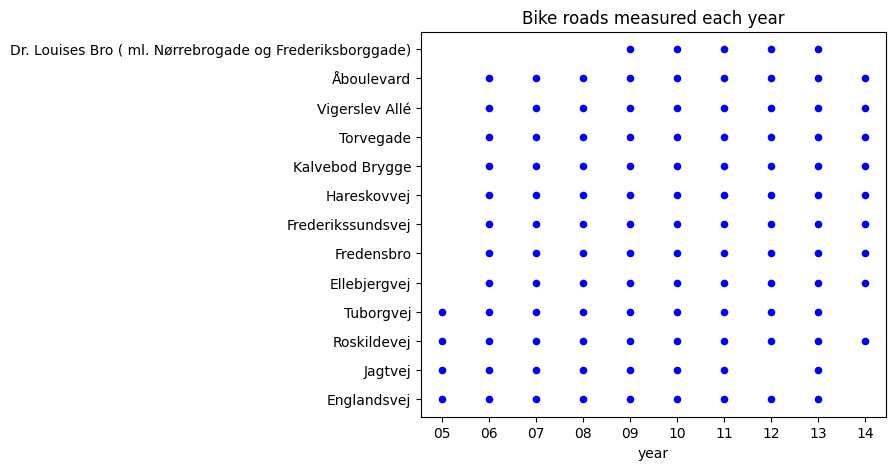

In [ ]:
years_bike = []
all_bike_roads = []

for year, road_names in year_2_roads_bike.items():
    # Add all pairs of years and road names for the bike data
    years_bike += [year]*len(road_names)
    all_bike_roads += road_names

# Disable seaborn plot style for this plot
matplotlib.rc_file_defaults()

plt.figure(figsize=(6,5))

# Plot bike data
plt.scatter(years_bike, all_bike_roads, s=20, color="blue")
plt.title("Bike roads measured each year")

plt.xlabel("year")
plt.show()

# Set style to searborn again
plt.style.use('seaborn-whitegrid')


It appears that many of the same roads are measured each year but with some changes. In particular, it seems like only a few roads where measured in the beginning and in the end which could make sense - they started out testing a few roads and then at the end they gradually stopped measuring when the necessary data was retrieved. 

This is an important observations when we later look into patterns on a yearly basis - we have to consider the *number* of conducted experiments that year and average upon that. Additionally, if we compare two different years with two different sets of locations, the comparison might very well be biased if roads included/excluded in either on average has more bicyclists. For example, we might expect there to be many more passing cyclists on the roads near the central copenhagen.

Apart from this temporal observation, we can also use the associated UTM coordinates to plot the locations and get a spatial understanding of where measurements are conducted. For this we use ``folium``. But in order to use ``folium`` we need to convert the UTM coordinates to longitude and latitude coordinates. Using the ``utm`` package, we can acheive this, if we also know the UTM-zone of Copenhagen. From \[CphUtm\] we see that Copenhagen lies in "zone 32, north". Using this, we can plot the locations of the counting spots:

In [ ]:
# Get unique positions
counting_positions = []
for (utm_x, utm_y, road_name) in zip(df_bike.X, df_bike.Y, df_bike.RoadName):

    counting_positions.append((utm.to_latlon(utm_x, utm_y, 32, northern=True), road_name))
    

# Only include unique positions
counting_positions = list(set(counting_positions))

# Then plot it using folium
CPH_map = folium.Map([55.676098, 12.568337], zoom_start=12, tiles="Stamen Toner")


loc = 'Map of Copenhagen'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

CPH_map.get_root().html.add_child(folium.Element(title_html))

for (lat, lon), road_name in counting_positions:
    folium.CircleMarker([lat, lon], color="red", radius=3, 
                        popup=road_name,
                        fill=True
                        ).add_to(CPH_map)


folium_deepnote_show(CPH_map)

This visualization is great at giving a spatial understanding of where measurements are conducted. It appears that most of the measured roads are near the central Copenhagen. Many people living near Copenhagen may also recognize lots of the road names in the above plot (click on a point to see the road name). These roads constitute many of the main routes used to travel towards and away from the central Copenhagen.

By clicking on the first marker above the 'n' in Cope**n**hagen (displayed in the map) we see this is the location of **Dronning Louises Bro**. To check how accurate these coordinates seem to be, we've zoomed in to find the precise location. Then we jumped into *Google Street View* on the same location. Below we've included a screenshot of what you find roughly 10 meters from the location:

![alt text](DrLouises.png)


We see that the cables used to count passing cyclists are actually there (right arrow)! Furthermore, if you've cycled here yourself, you might also have noticed the screen which tells how many cyclists have passed on the current day (left arrow). So although the location is not accurate down to centimeters, it seems like the specified locations are within reasonable distance to the actual ones. 

Finally, we also check the number of unique locations in the data set:

In [ ]:
print("Number of unique locations in data:", len(counting_positions))

Number of unique locations in data: 13


We see that there are only 13 locations, which is the same as the number of unique road names. This means that every measurement for a specific road were conducted on the same location across years! That is great news in terms of making the measurements comparable accross time.

### 2.2.2. How Frequently Are Measurements Done?
Now we'll look a little more into the amount of measurements in each year. First, let us see if all locations have observations for all 365 days of the different years:

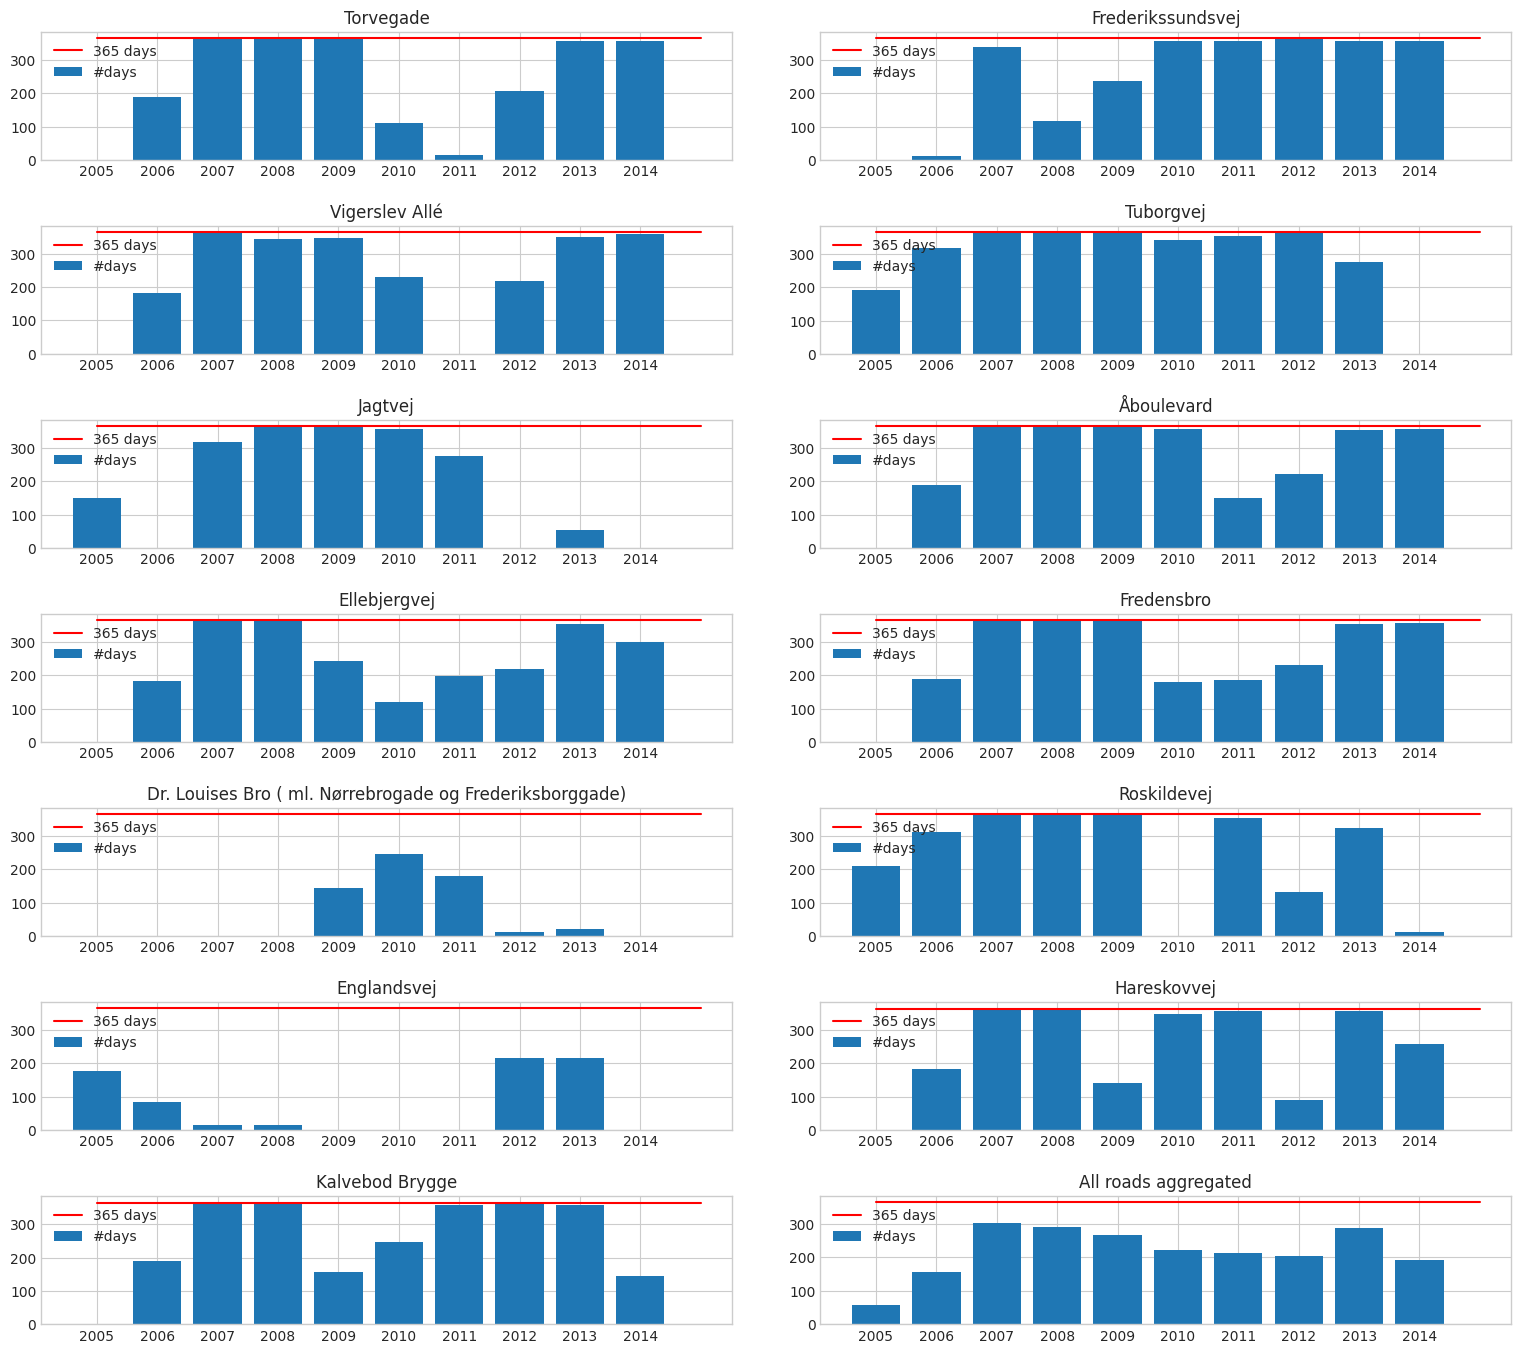

In [ ]:
roads = list(set(df_bike["RoadName"]))
years = range(2005, 2015)
all_roads_aggregrated = np.zeros(len(years))

fig, axes = plt.subplots(7, 2, figsize=(16,14))
fig.tight_layout(pad=3.0)

all_axes = axes.flatten()

for ax, road in zip(all_axes[:len(roads)], roads):

    road_data = df_bike[(df_bike["RoadName"] == road) & (df_bike["Direction"] == "T")]
    yearly_obs_on_road = np.zeros(len(years))


    for i, year in enumerate(years):
        dates = road_data[road_data["Date"].dt.year == year]["Date"]
        n_unique_dates = len(set(dates))
        yearly_obs_on_road[i] = n_unique_dates

    ax.set_title(road)
    ax.bar(years, yearly_obs_on_road, label="#days")
    ax.plot([2005, 2015], [365, 365], color="red", label="365 days")
    ax.set_xticks(years)
    ax.legend(loc="upper left")

    all_roads_aggregrated += yearly_obs_on_road

all_axes[-1].bar(years, all_roads_aggregrated/len(roads), label="#days")
all_axes[-1].plot([2005, 2015], [365, 365], color="red", label="365 days")
all_axes[-1].set_xticks(years)
all_axes[-1].set_title("All roads aggregated")
all_axes[-1].legend(loc="upper left")

plt.show()





From the different plots we see that we observe several things. There are several cases where measurements are conducted on;

1. all days throughout the year. For example, see Åboulevard from 2007-2010 and 2013-2014
2. only a few days in a year. For example, see Dr. Louises Bro in 2012 and 2013.
3. about half of the days in a year. For example, see Ellebjergvej from 2009-2012. 

It makes sense that every road is not complete with respect to days with measurements troughout every year. Road work might force the equipment to interrupt measuring, equipment might fail or maybe the measurements were interrupted due to funding reasons, or that all necessary data had been gathered for their original purpose, for that location.

**To conlude:** the gaps emphasize that conclusions done when comparing different roads should be made with caution. An example on this is shown below:

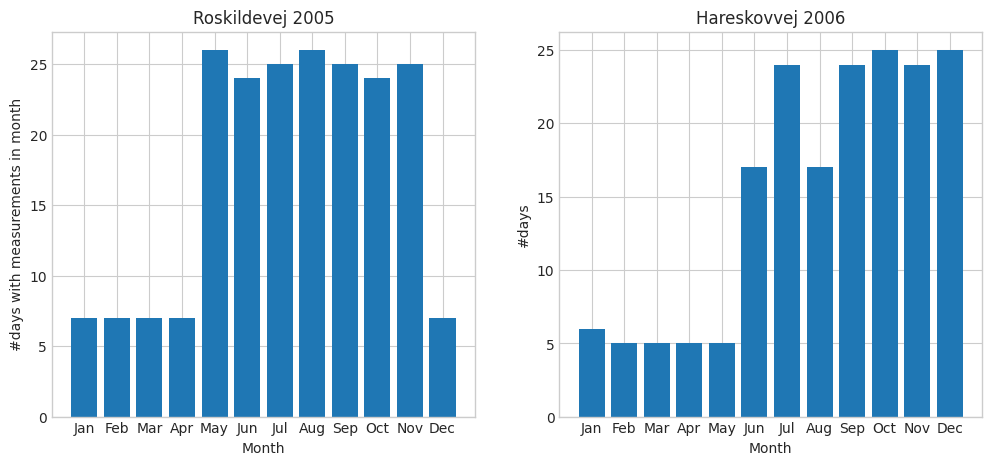

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sub_data = df_bike[(df_bike["RoadName"] == "Roskildevej") & (df_bike["Date"].dt.year == 2005) & (df_bike["Direction"].str.contains("T"))]
freqs_pr_month = np.array(sub_data.groupby(df_bike['Date'].dt.month).size())
ax[0].bar(months, freqs_pr_month, label="#days")
ax[0].set_xticks(months)
ax[0].set_xlabel("Month")
ax[0].set_ylabel("#days with measurements in month")
ax[0].set_title("Roskildevej 2005")

sub_data = df_bike[(df_bike["RoadName"].str.contains("Hareskovvej")) & (df_bike["Date"].dt.year == 2006) & (df_bike["Direction"].str.contains("T"))]
freqs_pr_month = np.array(sub_data.groupby(df_bike['Date'].dt.month).size())
ax[1].bar(months, freqs_pr_month, label="#days")
ax[1].set_xticks(months)
ax[1].set_xlabel("Month")
ax[1].set_ylabel("#days")
ax[1].set_title("Hareskovvej 2006")

plt.show()

As it appears on these two roads, only a couple of days during some of months are measured. And even though these roads might (roughly) contain measurements for equally many days in a certain time period (through 2005 and 2006 respectively), we see that one is measuring more frequently in the summer period and the other in the fall/winter. Therefore, it would be biased to compare which road were more trafficked on this data alone, as the seasonality might have an impact on the traffic.

When inspecting the above plot, we can furthermore notice something interesting - that on both roads there seem to be done a systematically low amount of measurements in some months. We inspect the dates of the first 5 months for *Hareskovvej* in 2006:

In [ ]:
hareskovvej2006 = df_bike[(df_bike["RoadName"].str.contains("Hareskovvej")) & (df_bike["Date"].dt.year == 2006) & (df_bike["Direction"].str.contains("T"))]
dates = hareskovvej2006[hareskovvej2006["Date"] < datetime.datetime(2006, 6, 1)].Date
dates = sorted(dates, key=lambda x: x.month)
for d in dates:
    print(d.date())
    if "-12" in str(d.date()):
        print("_________")


2006-01-07
2006-01-08
2006-01-09
2006-01-10
2006-01-11
2006-01-12
_________
2006-02-07
2006-02-08
2006-02-09
2006-02-11
2006-02-12
_________
2006-03-07
2006-03-08
2006-03-09
2006-03-11
2006-03-12
_________
2006-04-07
2006-04-08
2006-04-09
2006-04-11
2006-04-12
_________
2006-05-07
2006-05-08
2006-05-09
2006-05-11
2006-05-12
_________


In the above print, we see that the first 5 months of measurements on Hareskovvej in 2006 were only measured on the 7th-12th in every month. This pattern implies that it was decided to only measure on a few days each month - maybe due to one of the reasons previously touched upon (funding, scheduled road work, etc). 

### 2.2.3. Are There Missing Values in the Data?
As the final part of the initial exploration of the data, we'll look into how values are missing in the data and do a few statistics afterwards. First, we will see which features have missing values.

In [ ]:
pd.DataFrame([np.any(df_bike.isna().to_numpy(), axis=0)], columns=df_bike.columns)


,RoadID,RoadName,Lane,X,Y,Date,00-01,01-02,02-03,03-04,...,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,Direction
0,False,False,True,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False


Columns with 'true' indicate that there exists missing values for this feature. It appears that only the countings (``00-01``, ``01-02``, ...) have missing values, apart from the ``Lane`` feature, which we already knew had many missing values - remember that only ``Dr. Louises Bro`` has bike roads with lanes. Lets dive into the countings and see how many of the data rows have missing values:

In [ ]:
missing_values = len(df_bike[np.any(df_bike.iloc[:, 6:30].isna().to_numpy(), axis=1)])
data_set_size = len(df_bike)
print(f"{missing_values} rows out of {data_set_size} contains missing values ({round(missing_values/data_set_size*100, 2)}%)")

728 rows out of 92090 contains missing values (0.79%)


As these missing values constitute such small portion of the data, we could just throw them away rather than imputing new possible erroneously values. Especially as we previously saw that the data already has "gaps" in the dates where measurements were made, i.e. we would not expect that a few more gaps would have a significant impact on the analysis. However, we first want to check if the values seem to be missing systematically. If this is the case, as for example if all values are missing for a specific road, month or year, this could in worst case remove all information about some specific road. Therefore, we first we look for any systematical missing values for the roads:

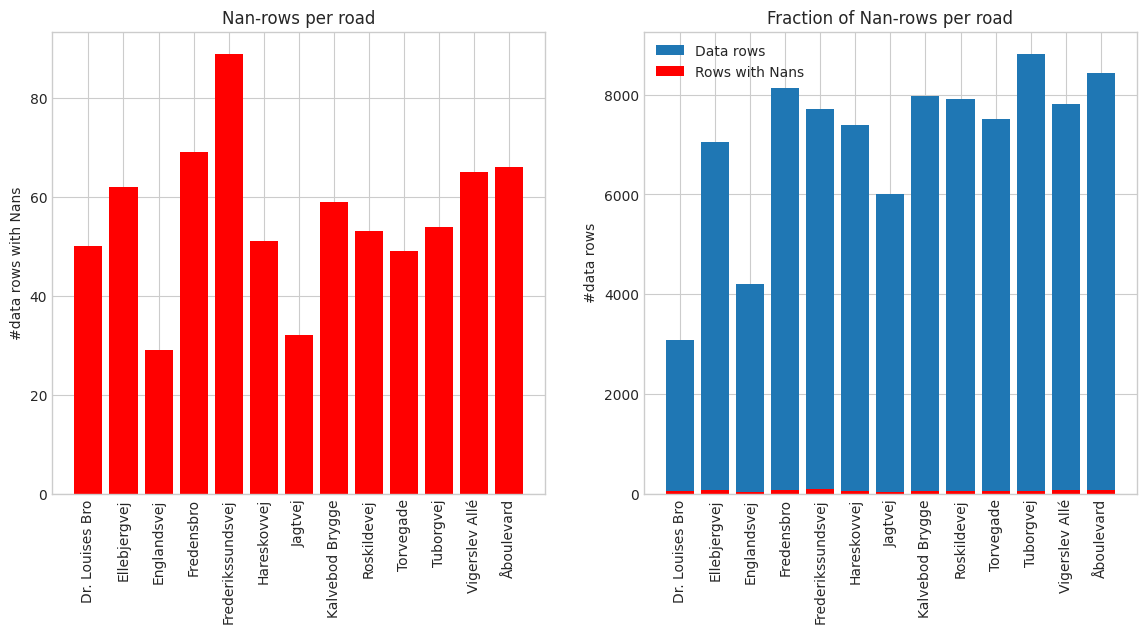

In [ ]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

nans_per_road = df_bike[np.any(df_bike.iloc[:, 6:30].isna().to_numpy(), axis=1)].groupby(df_bike['RoadName']).size()

total_per_road = df_bike.groupby(df_bike['RoadName']).size()

roads = np.array(nans_per_road.index)
roads[0] = roads[0][:15]

axes[1].set_title("Fraction of Nan-rows per road")
axes[1].bar(roads, total_per_road, label="Data rows")
axes[1].bar(roads, nans_per_road, label="Rows with Nans", color="red")
axes[1].set_xticklabels(roads, rotation=90)
axes[1].set_ylabel("#data rows")
axes[1].legend() 

axes[0].set_title("Nan-rows per road")
axes[0].set_ylabel("#data rows with Nans")
axes[0].bar(roads, nans_per_road,label="Rows with Nans", color="red")
axes[0].set_xticklabels(roads, rotation=90)
plt.show()

warnings.filterwarnings("default")



On the plot to the left, we see that Frederikssundsvej contains the most missing values. But other than that, it also appears that the missing values are relatively spread among all the different roads. On the plot to the right, we see that the number of missing values are insignificant compared to the total amount of data rows for each road. Thus, we can remove the missing values without loosing any significant amount of information about any of the locations.

Now, let us see if the values are missing systematically with regards to the temporal aspect of the data. For example, removing the Nan rows could potentially remove an entire month. We have chosen to inspect this by plot where we extract all the rows with nans. We then create a timeline for each year and plot the dates where values are missing with small peaks of height 1. In addition to this, if two consecutive days have missing values, we emphasize this by increasing the height of the peak at the subsequent day. That means if three consecutive days have missing values, the plot will contain three consecutive peaks with height 1, 2 and 3 respectively. The timeline for each year between 2005-2014 is plotted below:

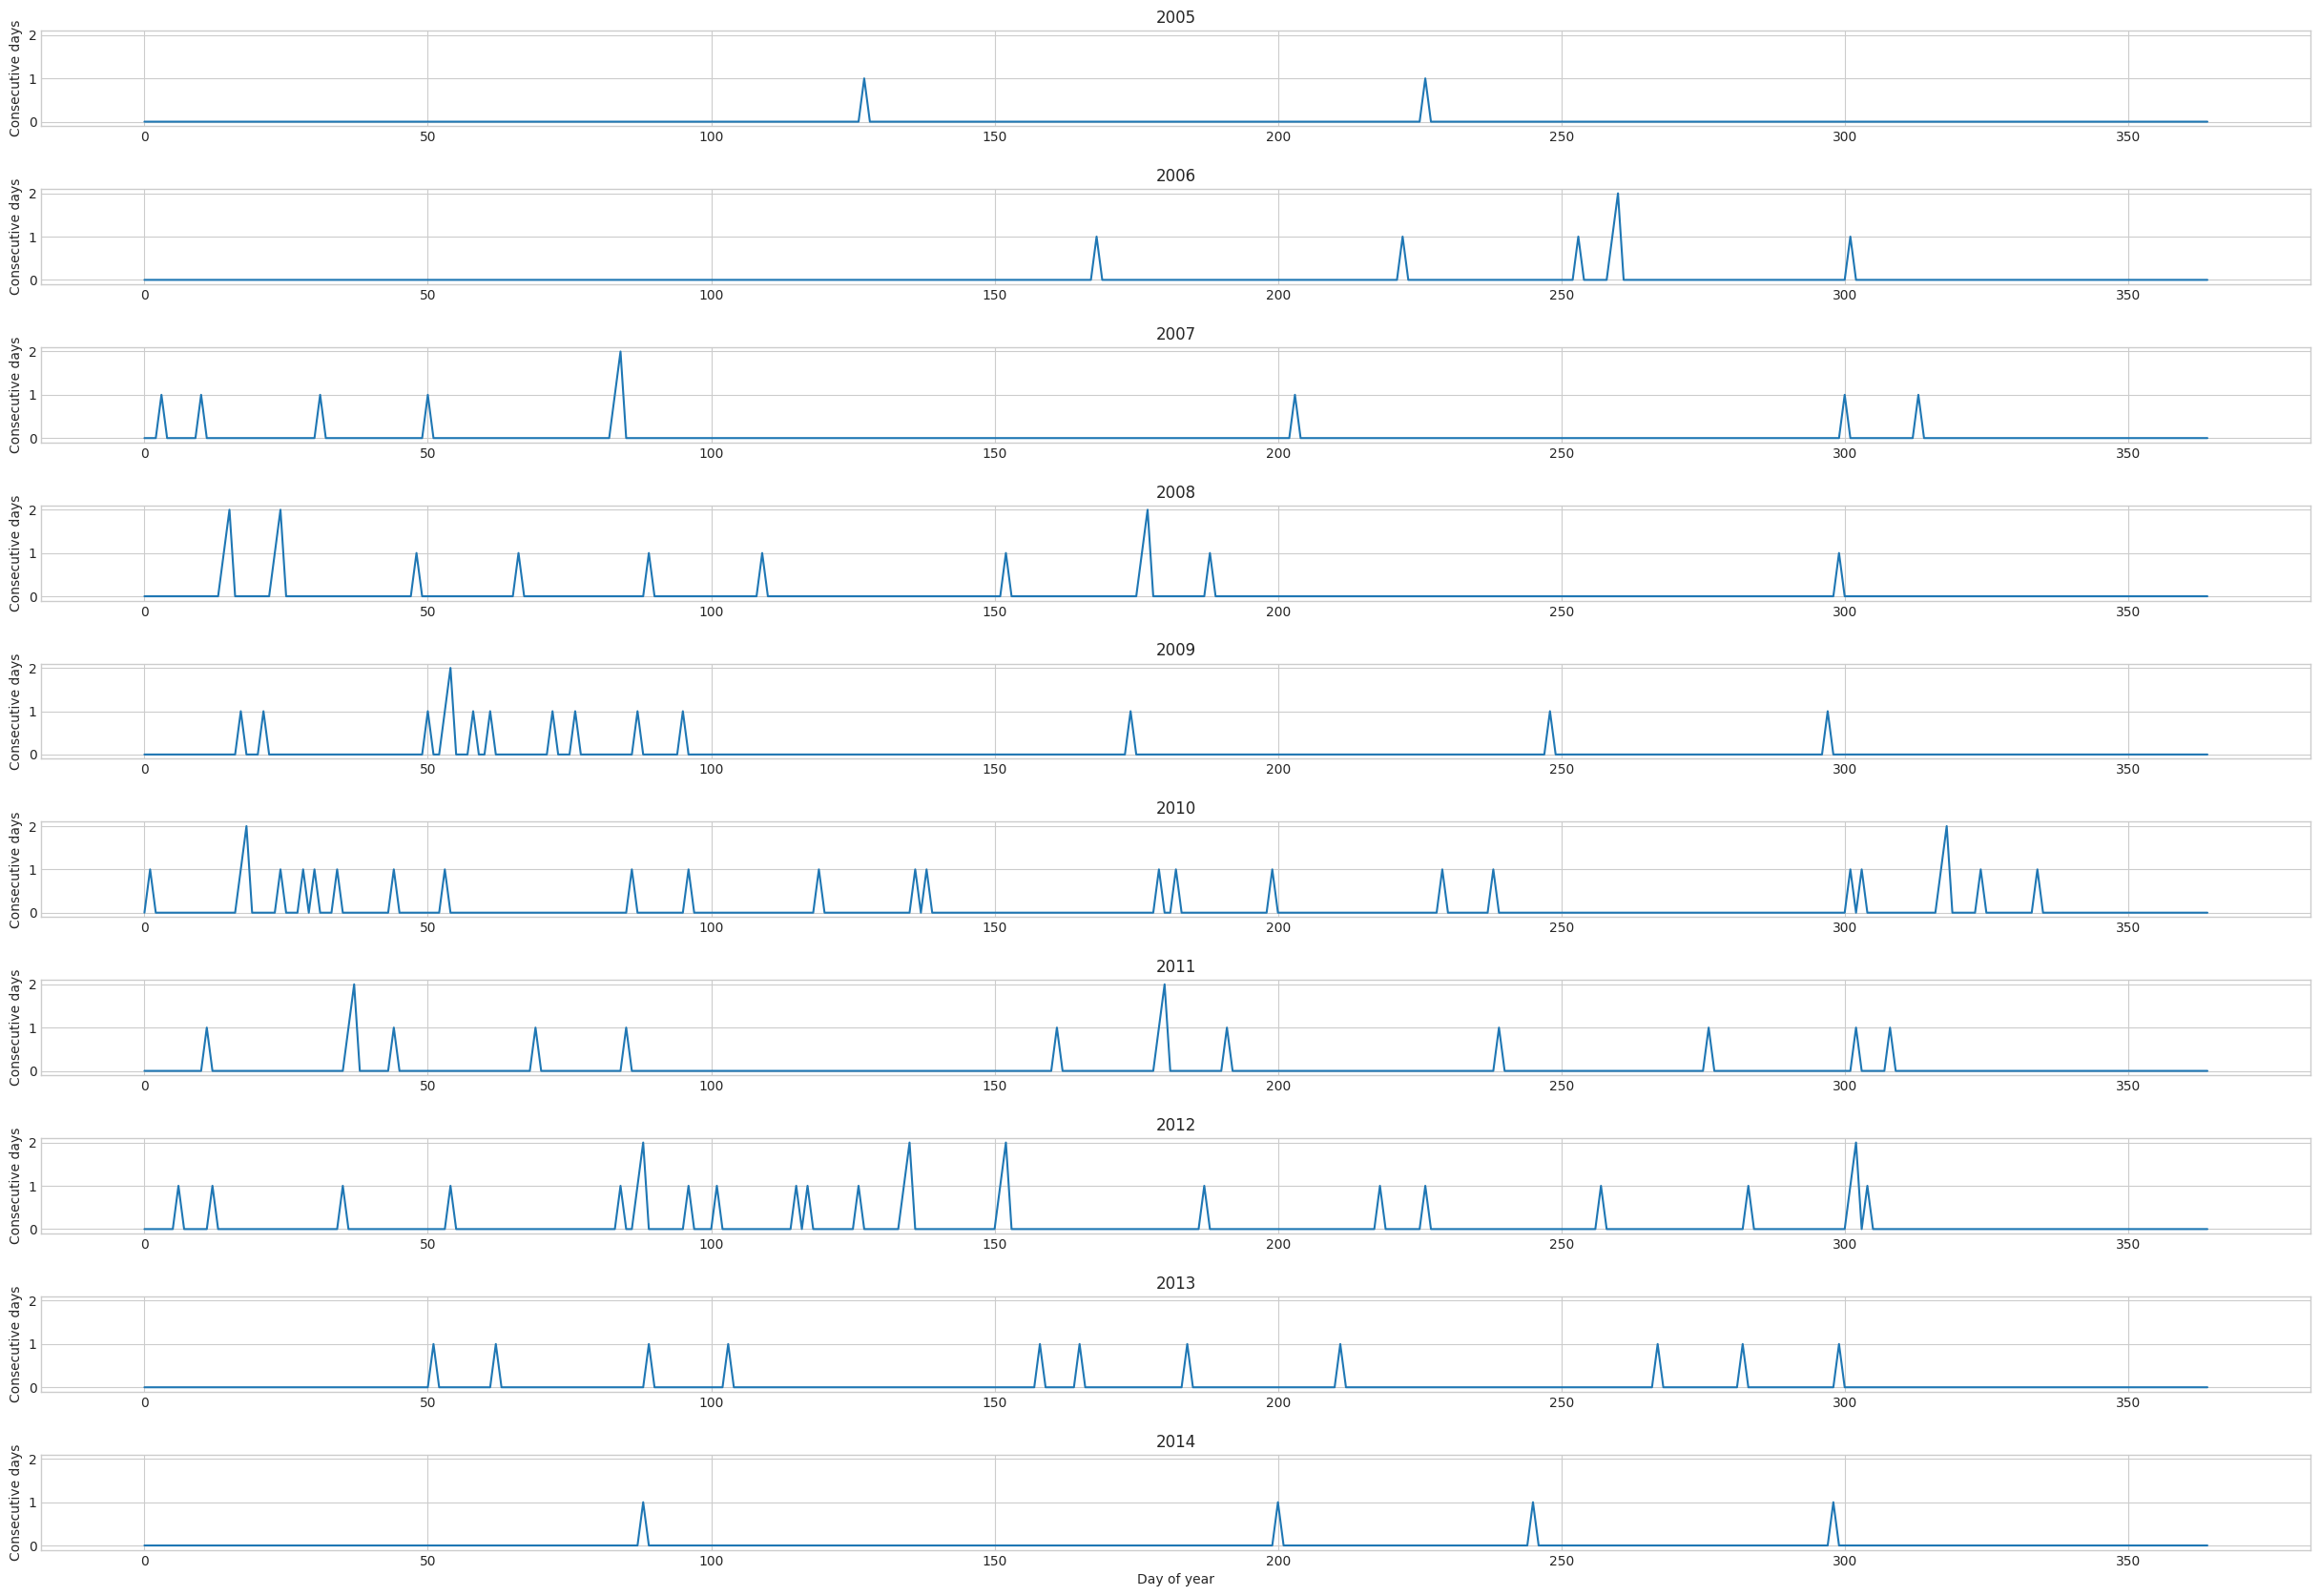

In [ ]:
years = np.arange(2005, 2015)
df_nans = df_bike[np.any(df_bike.iloc[:, 6:30].isna().to_numpy(), axis=1)]

fig, axes = plt.subplots(10, 1, figsize=(25,17), sharey=True)

fig.tight_layout(pad=3.0)


for year, ax in zip(years, axes.flatten()):
    # Extract only specific year of the values with nans
    df_year = df_nans[df_nans["Date"].dt.year == year]

    dates = list(df_year.Date)
    # Strp times so that we can convert to day of year
    days_of_year = [datetime.datetime.strptime(str(d.date()), "%Y-%m-%d") for d in dates]
    days_of_year = [d.timetuple().tm_yday for d in days_of_year]

    # Only keep unique days on that year
    days_of_year = list(set(days_of_year))
    
    # 0-index the days
    days_of_year = [d-1 for d in days_of_year]

    # Make array of 365 values where nans occur
    days_with_nans = np.zeros(365)
    consecutives = np.zeros(365)

    for i in days_of_year:
        days_with_nans[i] = 1


    # Count how many days occur in a row
    for day, _ in enumerate(days_with_nans):
        if day == 0:
            consecutives[0] = int(days_with_nans[day] == 1)
        elif days_with_nans[day] == 1 and days_with_nans[day-1] == 1:
            consecutives[day] = consecutives[day-1] + 1

        elif days_with_nans[day] == 1:
            consecutives[day] = 1

    ax.plot(np.arange(365), consecutives)
    ax.set_title(year)
    ax.set_ylabel('Consecutive days').set_rotation(90)

axes.flatten()[-1].set_xlabel('Day of year').set_rotation(0)

plt.show()


This plot immediately shows us that no spike exceeds a height of 2 - i.e. there are no dates where data are missing in more than two consecutive days. Furthermore, it appears that the dates with nans are relatively spread both among all years and during each year. 

Note also, that there seem to be relatively few spikes compared to the 728 missing rows we know exist in the data. This suggests that there are several data rows with missing values on the same dates. One very likely example of this could be that both measured directions on a single road contain nans. But this would only explain a few examples. We therefore hypothesis that several roads have nan-values on the same dates. We can check this by plotting the number of rows found with missing values, for each date.

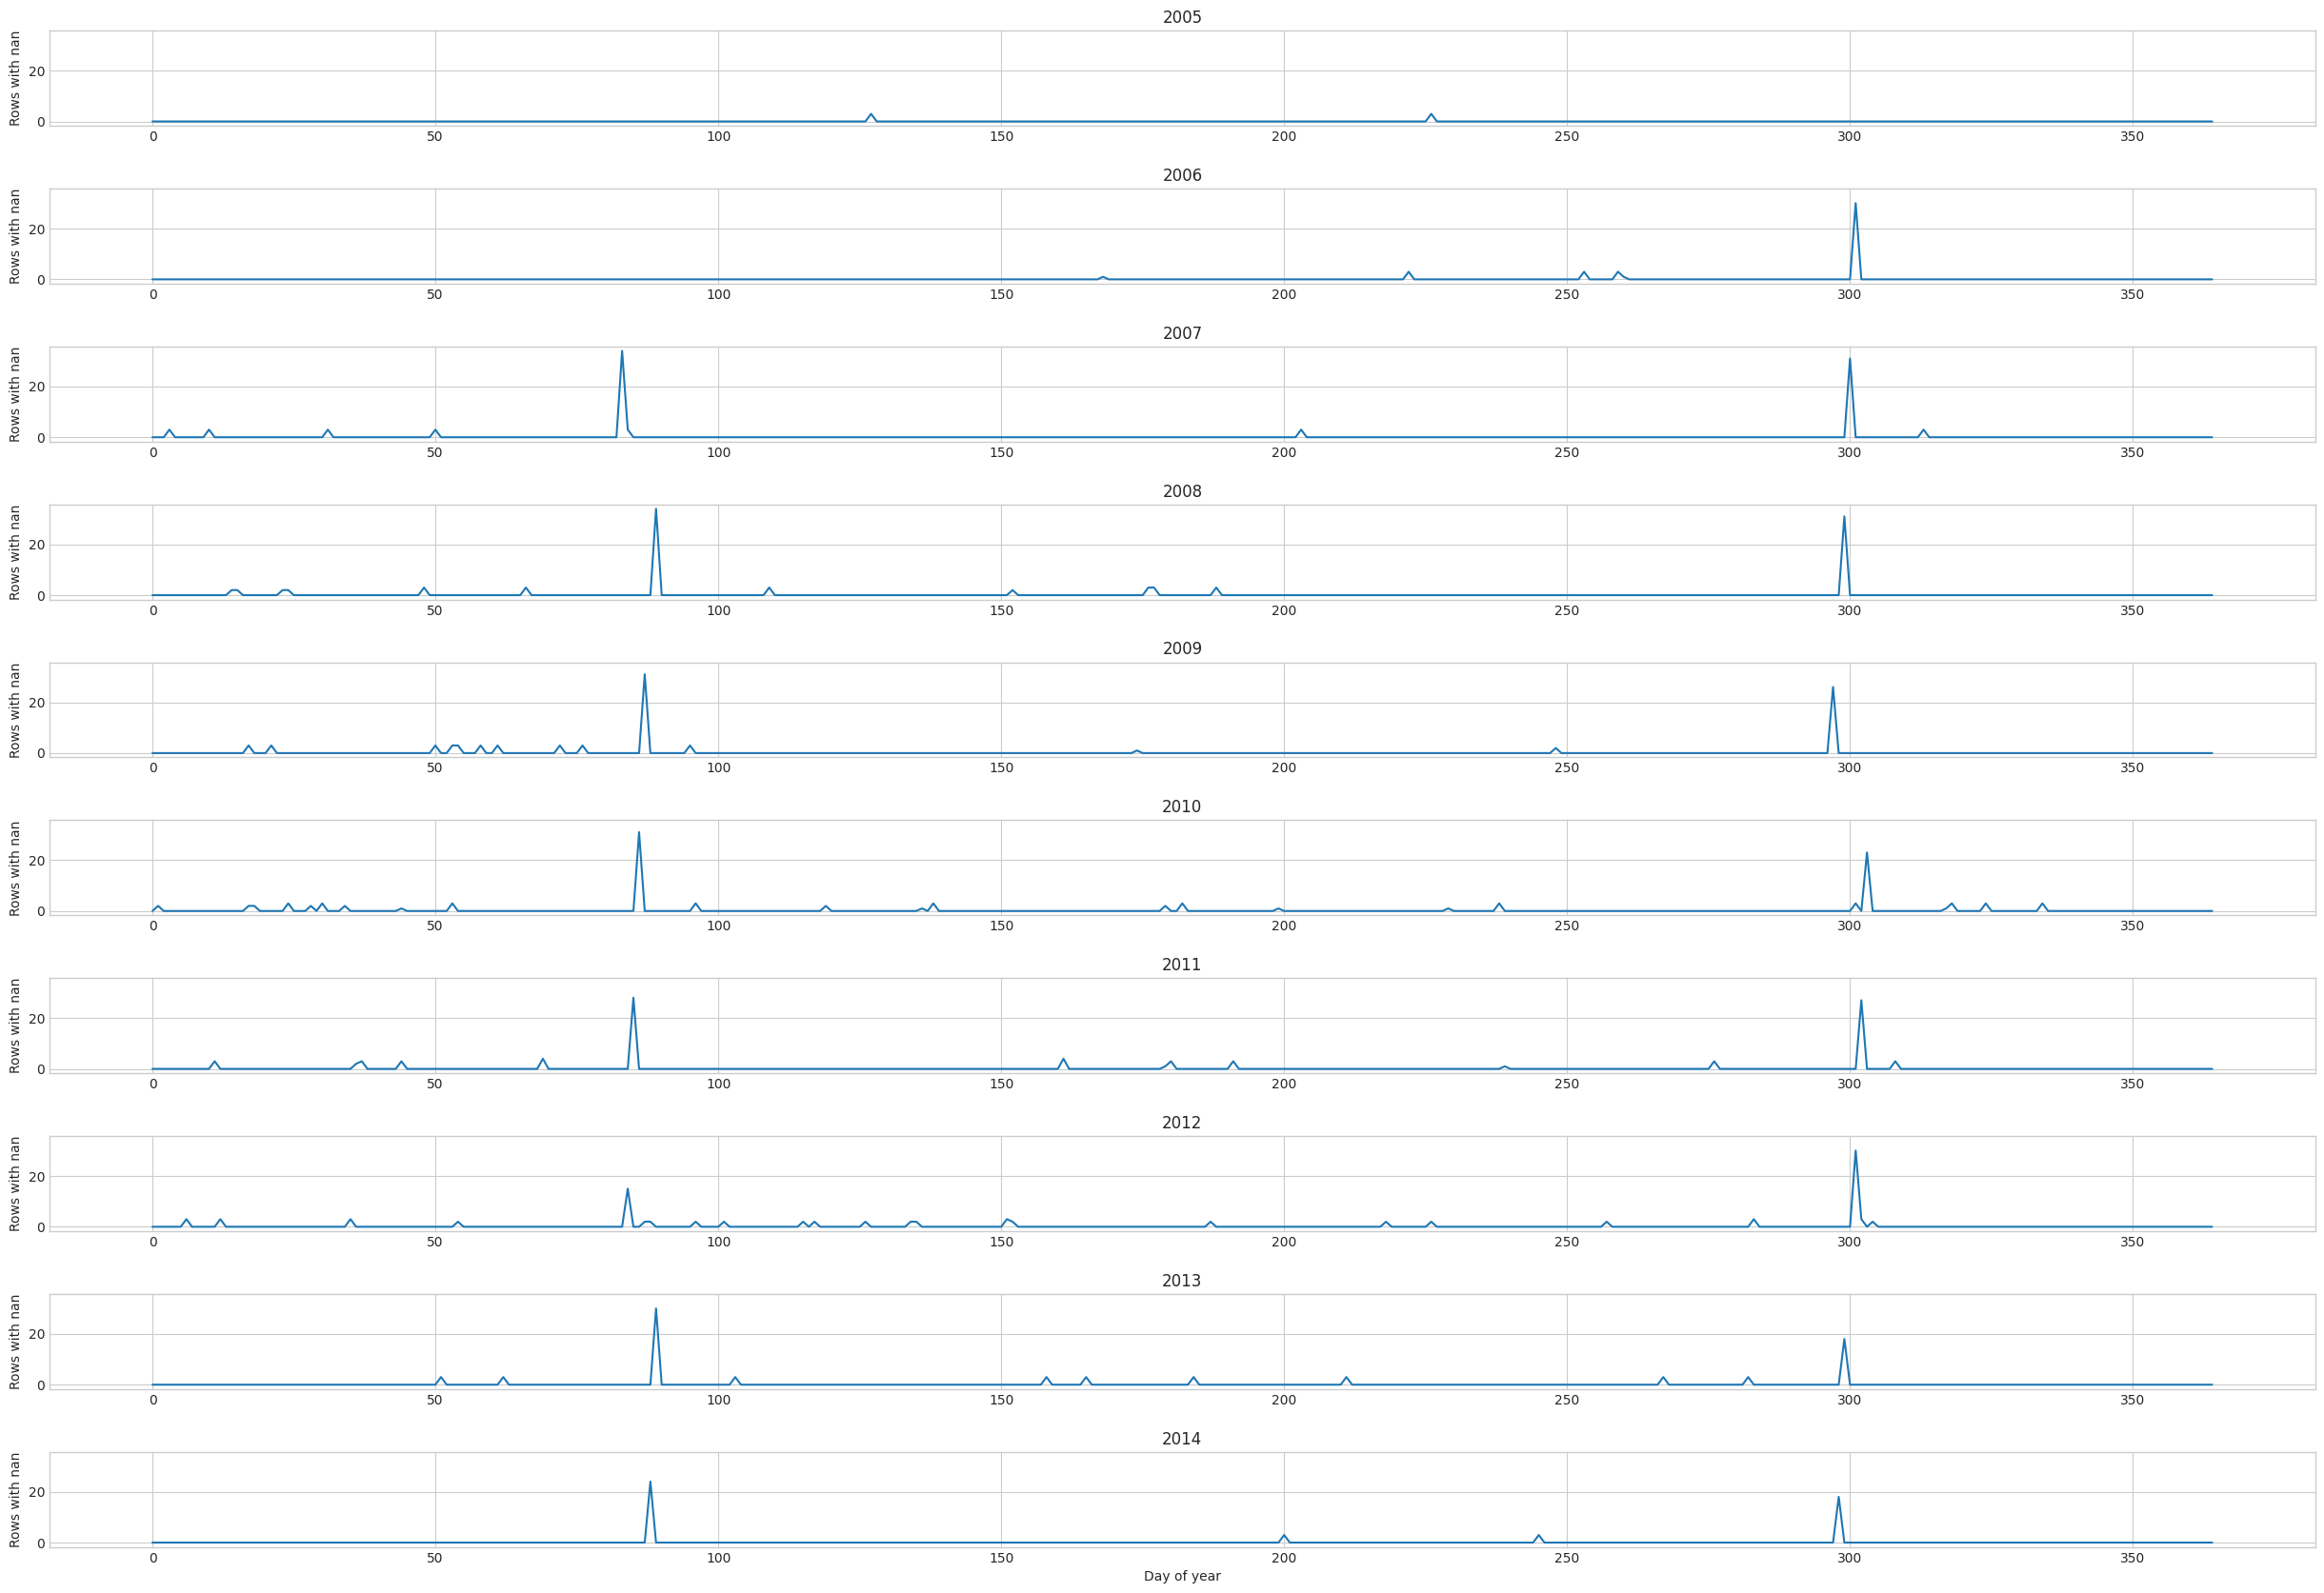

In [ ]:
years = np.arange(2005, 2015)
df_nans = df_bike[np.any(df_bike.iloc[:, 6:30].isna().to_numpy(), axis=1)]

fig, axes = plt.subplots(10, 1, figsize=(25,17), sharey=True)

fig.tight_layout(pad=3.0)


for year, ax in zip(years, axes.flatten()):
    # Extract only specific year of the values with nans
    df_year = df_nans[df_nans["Date"].dt.year == year]

    dates = list(df_year.Date)
    
    # Strp times so that we can convert to day of year
    days_of_year = [datetime.datetime.strptime(str(d.date()), "%Y-%m-%d") for d in dates]
    days_of_year = [d.timetuple().tm_yday for d in days_of_year]
    
    # 0-index the days
    days_of_year = [d-1 for d in days_of_year]

    # Make array of 365 values where nans occur
    days_with_nans = np.zeros(365)
    consecutives = np.zeros(365)

    for i in days_of_year:
        days_with_nans[i] += 1


    ax.plot(np.arange(365), days_with_nans)
    ax.set_title(year)
    ax.set_ylabel('Rows with nan').set_rotation(90)

axes.flatten()[-1].set_xlabel('Day of year').set_rotation(0)

plt.show()


This plot suddenly reveals a very interesting pattern. In most years, all of the roads seem to have missing values about day 90 and 300 of the year (i.e. around end March and end October). Note that the reason why the rows with missing values can exceed 13 (13 being the maximal number of roads measured in a year) is because the two directions (``+``, ``-``) and the aggregration (``T``) are measured per road. Thus, the maximum number of missing values is actually $13 \cdot 3 = 39$.

Below we extract the data rows for the first large peak in 2014 and take a closer look:


In [ ]:
warnings.filterwarnings('ignore')

columns = list(df_year.columns)
columns.remove("RoadID")
columns.remove("Lane")
columns.remove("X")
columns.remove("Y")


df_year[df_year["Date"] == datetime.datetime(2014, 3, 30)][columns]



,RoadName,Date,00-01,01-02,02-03,03-04,04-05,05-06,06-07,07-08,...,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24,Direction
84669,Ellebjergvej,2014-03-30,6.0,2.0,NaN,1.0,2.0,0.0,0.0,1.0,...,72.0,62.0,36.0,29.0,31.0,20.0,15.0,11.0,7.0,-
84968,Ellebjergvej,2014-03-30,6.0,9.0,NaN,7.0,1.0,12.0,16.0,9.0,...,99.0,98.0,93.0,45.0,31.0,13.0,24.0,13.0,6.0,+
85267,Ellebjergvej,2014-03-30,12.0,11.0,NaN,8.0,3.0,12.0,16.0,10.0,...,171.0,160.0,129.0,74.0,62.0,33.0,39.0,24.0,13.0,T
85566,Fredensbro,2014-03-30,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
85924,Fredensbro,2014-03-30,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
86282,Fredensbro,2014-03-30,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
86640,Frederikssundsvej,2014-03-30,126.0,134.0,NaN,71.0,25.0,33.0,57.0,69.0,...,424.0,276.0,299.0,260.0,178.0,168.0,111.0,98.0,41.0,-
86998,Frederikssundsvej,2014-03-30,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,+
87356,Frederikssundsvej,2014-03-30,126.0,134.0,NaN,71.0,25.0,33.0,57.0,69.0,...,424.0,276.0,299.0,260.0,178.0,168.0,111.0,98.0,41.0,T
87714,Hareskovvej,2014-03-30,8.0,7.0,NaN,3.0,3.0,3.0,9.0,12.0,...,129.0,127.0,92.0,62.0,24.0,23.0,12.0,12.0,4.0,-


Inspecting the above dataframe reveals that all the roads have nan values in ``02-03`` during this date. This actually reveals why the values are missing in this systematic way. If you google *Denmark 2014-03-30 02:00* and research a bit, you will find that this is the exact time where Denmark switches to summer-time! And this furthermore fits perfect with Denmark switching to winter-time around the end of October. When thinking about it, it also makes sense that values are missing in these time intervals: when switching to winter-time, that time interval doesn't exist! And when switching to summer-time, this hour would be measured twice! Therefore, as this is the case for every road that they are missing these values at the same time, removing these would typically not introduce any significant bias.

To sum it up; we found that if necessary, we might be able just ignore the rows with nans if we keep all the above observations in the back of our mind. These NaN values typically seem to be missing in a random pattern and only constitute a very small part of the entire date. Furthermore, in the case where they do miss systematically (winter/summer time), they are missing for every road at the same time which is only for two days a year.

# 3. Data Analysis
In this section, we will analyse the data in more detail, keeping in mind the observations we made on the date above in *section 2*. First we'll be investigating the temporal patterns of the data - exploring the most trafficked hours, days, months and years. Then we'll proceed to examine if the super bike lanes seems to have had an impact on how many bicycles around Copenhagen. And finally, we want to explore if the weather has an impact on the bicycle patterns in Copenhagen.

## 3.1. Investigating Temporal Patterns
In this first part of the data analysis, we'll look into the temporal patterns of the data to investigate questions like:

1. At which hours during the day do Danes bicycle the most? And to what extent is this towards and away from the center of the city?
1. Do danes bicycle more on some days than others? And at what times during these specific days?
1. In which months or season do Danes bicycle the most?
1. Have more or less people started using the bicycle lanes during 2005-2014?

For this purpose we use visualizations of averaged countings over time to make patterns more noticable. We asses that the visual attributes of the plots will make it easier to compare patterns over time, rather than just investigating a range of numbers. Note that we for this section exclude the small portion of nan-values, as we - based on the analysis in *section 2.2.3* - do not believe this will influence our analysis and exploration for the temporal patterns.

In [ ]:
df_bike = pd.read_csv("bike_data.csv", parse_dates=["Date"])
df_bike = df_bike[df_bike.notna()]

### 3.1.1. Hourly Patterns
So the first pattern we want to investigate is the hourly patterns during a day. First we want to examine which patterns appear from looking at the total number of passing cyclists in both directions throughout the hours of the day. However, when exploring the data, we saw that a total for both direction (``T``) was only included, if there was a corresponding ``+`` and ``-`` measurement on the same road and date. However, this was not the case for *Dr. Louises Bro*, which instead contained ``1+``, ``2+`` and ``3+`` but still has ``T`` "measurements". To investigate this further, we plotted how ``T`` was distributed during a day for *Dr. Louises Bro*:



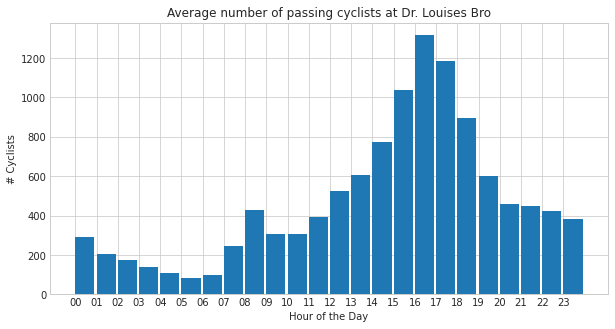

In [ ]:
# Group each
road_name = "Dr. Louises Bro"

hours = list(df_bike.columns[6:30])
hours = [h[:2] for h in hours]


counts = np.zeros(24)

df_road_T = df_bike[(df_bike['RoadName'].str.contains(road_name)) & (df_bike['RoadID'].str.contains(" T"))] #.groupby(df_bike['Date'].dt.date).size()

counts += np.array(df_road_T.iloc[:, 6:30].mean(axis=0))

 
plt.figure(figsize=(10,5))
plt.title("Average number of passing cyclists at Dr. Louises Bro")
plt.ylabel("# Cyclists")
plt.xlabel("Hour of the Day")
plt.bar(x=hours, height=counts, align="edge", width=0.9)
plt.show()




This reveal a somewhat different pattern from what we might have expected. We might expect that a similar amount of people would pass in both direction in the morning and in the afternoon - e.g. when going to and from work. This made us think that the three lanes (``1+``, ``2+`` and ``3+``) could all be measuring the same direction. Therefore, we contacted *Åse Boss Henrichsen*, who is responsible for the data and works in the municipality of Copenhagen as Traffic Coordinator in technique and environment. She confirmed our hypothesis that passing cyclists were only measured going out of the city, which makes great sense when comparing with the plot above. Most people are probably cycling to the center of Copenhagen in the morning as a lot of working places, train station etc. are located in the center. And on the other hand, people typically live outside the center, which means that they bicycle away from the city in the afternoon. And hence, we get the peak around the afternoon. You might also recall that the screenshot from google street view of the measuring spot was for the direction going out of the city!

We can now go back to our original goal of showing which patterns appear from looking at the total number of passing cyclists in both directions throughout the hours of the day. In order to not bias the distribution, we exclude ``Dr. Louises Bro`` as this road's ``T`` measurements is the sum of counts on lanes rather than a sum of different directions:


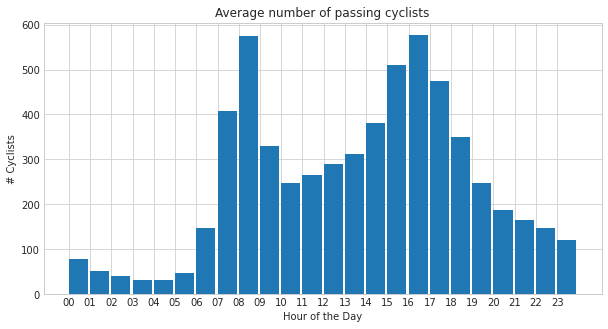

In [ ]:
hours = list(df_bike.columns[6:30])
hours = [h[:2] for h in hours]


# Include T direction and exclude Dr. Louises bro
df_road_T = df_bike[(df_bike['Direction'].str.contains("T")) & ~(df_bike["RoadName"].str.contains("Dr. Louises Bro")) ] 

counts = np.array(df_road_T.iloc[:, 6:30].mean(axis=0))

 
plt.figure(figsize=(10,5))
plt.title("Average number of passing cyclists")
plt.ylabel("# Cyclists")
plt.xlabel("Hour of the Day")
plt.bar(x=hours, height=counts, align="edge", width=0.9)
plt.show()




From the plot it appears that on average for all the roads, the two most traffic-heavy hours are from 08-09 and from 16-17. This fits well with the general patterns in the Danish society, as lots of people go to work, school, instutitions, etc. at around 08-09 and goes back home again at about 16-17. We also notice that if you for example are very concerned with corona and want to bicycle somewhere around Copenhagen on these roads with the least chance of meeting other people, you should aim for going in the middle of the night, late in the evening or around 10-11 in the morning. In the morning hours, about 250 cyclists on passes on these locations which means that on any minute during 10-11, there will on average be about $250/60\approx4$ cyclists passing. So this time slot is probably your best chance to avoid dense bicycle traffic!

However, if someone rather wants to know at what direction the traffic is the most dense rather than the overall patterns, we should also consider the direction of the cyclists. As with the plot of ``Dr. Louises Bro``, we see that the traffic is actually not very dense in the morning away from Copenhagen. In order to let the reader extract their desired information for the overall pattern, we can create a single interactive plot using ``Bokeh``. However, if we want to know more about the traffic towards the city and away from the city center respectively, we first need to google how the ascending house numbers (``+`` direction) relates to this. From inspecting google maps, we see that all roads which are not perpendicular to the center of Copenhagen actually have ascending house numbers going away from the city! This also fits with the European standard that house numbers starts from 1 at the center of the city (https://da.wikipedia.org/wiki/Husnummerering). The two perpendicular roads, "Tuborgvej" and "Jagtvej" is excluded from the plot as these do not tell us anything about the traffic towards and away from the city center. 

In order to make the Bokeh plot, we will include the above distribution for every direction in a dataframe:

In [ ]:
directions = ["\+", "-", "T"]
column_names = ["Away from city", "Towards city", "Total"]

direction_df = pd.DataFrame()

hours = list(df_bike.columns[6:30])
hours = [h[:2] for h in hours]
direction_df["hour"] = hours


for d, name in zip(directions, column_names):

    # Remember to exclude Dr. louises bro for T
    if d == "T":
            df_road_d = df_bike[(df_bike['Direction'].str.contains(d)) & ~(df_bike["RoadName"].isin(["Tuborgvej", "Jagtvej", "Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)"])) ] 
    else:
        df_road_d = df_bike[(df_bike['Direction'].str.contains(d)) & ~(df_bike["RoadName"].isin(["Tuborgvej", "Jagtvej"])) ] 

    # Extract counts for current direction
    counts = np.array(df_road_d.iloc[:, 6:30].mean(axis=0))

    direction_df[name] = counts


Then we pass this to the ``ColumnDataSource`` in order to make the data fit with the Bokeh framework and plot it:

In [ ]:
# Define data source
source = ColumnDataSource(direction_df)
 
# Create figure with x-range
p = figure(plot_width=800, plot_height=400, x_range = FactorRange(factors=hours), title="Avg. no. of bikes per hour") #p is a standard way to call figures in Bokeh

# Import colors
colors = ["red", "blue", "green"]

# indx, direction
for indx, cname in enumerate(column_names):
    ### we will create a vbar for each focusdirection
    p.vbar(x="hour", top=cname, source=source, 
                    legend_label=cname,  muted_alpha=0.02, 
                    color=colors[indx], width=0.7, alpha=0.7)
    
#cname stands for a column that we use, top=y; we are specifying that our numbers comes from column i

# Move legend to left of figure
p.add_layout(p.legend[0],'left')

# Mute the disabled categories instead of hiding
p.legend.click_policy="hide"

#Labeling x and y axis
p.xaxis.axis_label = 'Hour of the day'
p.yaxis.axis_label = 'Avg. number of passing cyclists'


# For local jupyter
#output_notebook()
#show(p)
bokeh_deepnote_show(p)

#output_file("output_file_name.html")
#save(p)

From toggling 'Total' only, we see that the same patterns as before appears. Now, if we toggle either 'Away from city' or 'Towards city' we see similar patterns to the total distribution, which was not what we expected. For example, we saw that *Dronnings Louises Bro* had a quite salient pattern when inspecting a single direction. This could imply that whether people primarily goes towards or away from the city is very dependent on the specific location. 

So we hypothesise that this is dependent on what part of Copenhagen we are considering. Therefore, to examine if there are any spatial patterns emerging from whether people bicycle towards or away from the city, we can use an interactive map which shows how many bicycles passes per hour. We want this map to show the relation between how many bicycles towards and away from the city center on a given hour. We can visualize this using ``folium``'s ``TimeStampedGeoJson``. Inspired by \[NYCbike\], we restructure our data into a new data frame sutiable for creating *features* for the ``TimeStampedGeoJson``. Essentially, each row of the dataframe will contain information of the size and position of its marker, at what time step it should be shown on the folium map and finally a color. We want the size of the marker to reflect the relation between the directions, and the color to show which direction is the dominating one at the given hour. This dataframe is constructed below:

In [ ]:
folium_df = pd.DataFrame()

# Get unique positions
counting_positions = []
for (utm_x, utm_y, road_name) in zip(df_bike.X, df_bike.Y, df_bike.RoadName):
    if road_name not in ["Tuborgvej", "Jagtvej", "Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)"]:
        counting_positions.append((utm.to_latlon(utm_x, utm_y, 32, northern=True), road_name))
    
# Only include unique positions
counting_positions = list(set(counting_positions))

#Define the hours
hours = list(df_bike.columns[6:30])

for (lat, lon), road_name in counting_positions:
    df_road = df_bike[df_bike["RoadName"] == road_name]
    
    # Make row per hour and per road name
    for i, hour in enumerate(hours):
        
        # + is away from city, - is towards
        count_p = df_road[(df_road["Direction"] == "+")][hour].mean()
        count_m = df_road[(df_road["Direction"] == "-")][hour].mean()
        relation = max(count_p, count_m)/ min(count_p, count_m)

        # Set color according to dominating direction
        color = "red" if count_p > count_m else "blue"
        new_data = pd.DataFrame( [[road_name, lat, lon, i, relation, color]], columns = ["RoadName", "lat", "lon", "hour", "count", "fillColor"])
        folium_df = folium_df.append(new_data,  ignore_index=True)

With this structure of the dataframe, we can borrow a function from the referenced work in order to make the display as desired:

In [ ]:
def create_geojson_features(df, scale_radius=3, apply_log_scale = False):
    features = []
  
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]

            },
            'properties': {
                'time': pd.to_datetime(row['hour'], unit='h').__str__(),
                'style': {'color' : ''},
                'popup': row["RoadName"],
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['fillColor'],
                    'fillOpacity': 0.7,
                    'stroke': 'true',
                    'radius': np.log(row['count']*scale_radius) if apply_log_scale else row['count']*scale_radius
                }
            }
        }
        features.append(feature)
    return features

start_geojson = create_geojson_features(folium_df)

Finally, we can create the map of Copenhagen and plot the interactive markers on top:

In [ ]:
from folium.plugins import TimestampedGeoJson
from folium import branca

CPH_map = folium.Map([55.676098, 12.568337], zoom_start=12, tiles="Stamen Toner")

TimestampedGeoJson(start_geojson,
                  period = 'PT1H',
                  duration = 'PT1M',
                  transition_time = 1000,
                  time_slider_drag_update=True,
                  date_options='[H]our: HH:mm',
                  auto_play = False).add_to(CPH_map)

#CPH_map.save('311.html')
folium_deepnote_show(CPH_map)

Finally we have the plot and are able to inspect in which regions traffic is headed either towards or away from the center. The color of the circle tells the dominating direction, where blue is towards the center of Copenhagen and red is away. The slider is used to manipulate the time and you can click each icon to tell the road name. If we use the slider to inspect between 02-04, we see that Roskildevej is suprisingly trafficed towards the city (the big blue circle to the left). More interestingly, we can inspect the rush hours. Starting at 08:00 it appears that the circles near the center of Copenhagen are both blue (towards) and red (away) as well as relatively large. If we then slowly slide the time to 17:00, we see that the circles change color at around 14:00 and then gradually increase in size, peaking at about 17:00. This reflects the expected pattern that people are headed towards somewhere in the morning and then back again in the afternoon. 

More specifically, we can see for the measured roads near the center that in the morning hours, the majority of bikes on the northern and western lanes are primarily headed towards the center (blue), and bikes on the souteast lanes are headed away (red) from the city. Then, in the afternoon we see the opposite although with slightly less dominating directions. This tells that our new hypothesis from inspecting the interactive bar plot was true; although the overall traffic around Copenhagen is not dominated by traffic either towards or away from the center - the traffic at *each* location is typically dominated in each directions at different locations in rush hours around Copenhagen! A possible explanation for this could be that many of the people headed towards the center are also continuing towards Amager through *Torvegade* (sourtheast from the center).


### 3.1.2. Weekly Patterns 
In this section we explore if Danes seem to bicycle more on some days compared to others based on the 13 measured roads. First, we inspect the average number of passing cyclists per day:

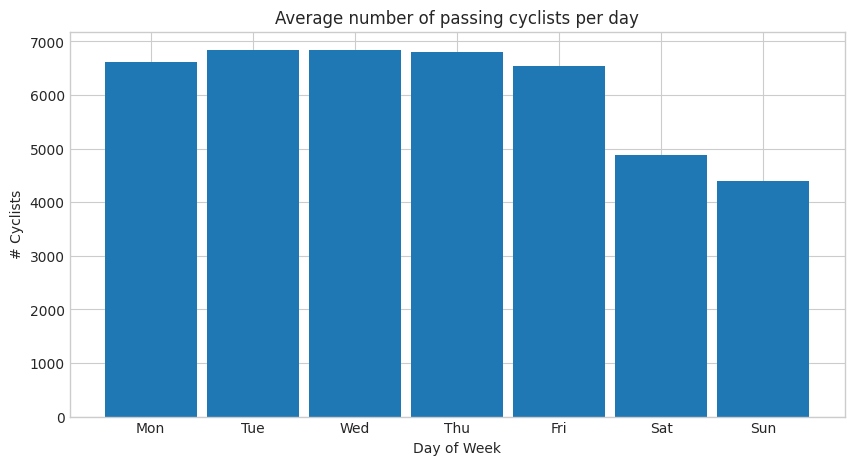

In [ ]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
avg_passed_cyclists_pr_day = []

# Inspect total
df_bike_T = df_bike[df_bike['Direction'].str.contains("T")]

# Extract average per week day
week_df = df_bike_T.groupby(df_bike_T['Date'].dt.day_name()).mean().iloc[:, 3:]
# Sum accross the entire day
day_df = week_df.sum(axis=1)


# Sort by days
for day in days:
    avg_passed_cyclists_pr_day.append(day_df[day_df.index.str.contains(day)].iloc[0])

plt.figure(figsize=(10,5))
plt.title("Average number of passing cyclists per day")
plt.ylabel("# Cyclists")
plt.xlabel("Day of Week")
plt.bar(x=days, height=avg_passed_cyclists_pr_day, width=0.9)
plt.show()


Here we clearly see that these bicycle lanes are significantly less occupied during weekends. There also seem to be a small tendency that people are more likely to ride the bike in the middle of the week rather than mondays and fridays. These patterns might be very different dependent on the hour of that day as well. We might hypothesis that more people are bicycling saturday night rather than monday night. We can check this by splitting each day into 24 hours:

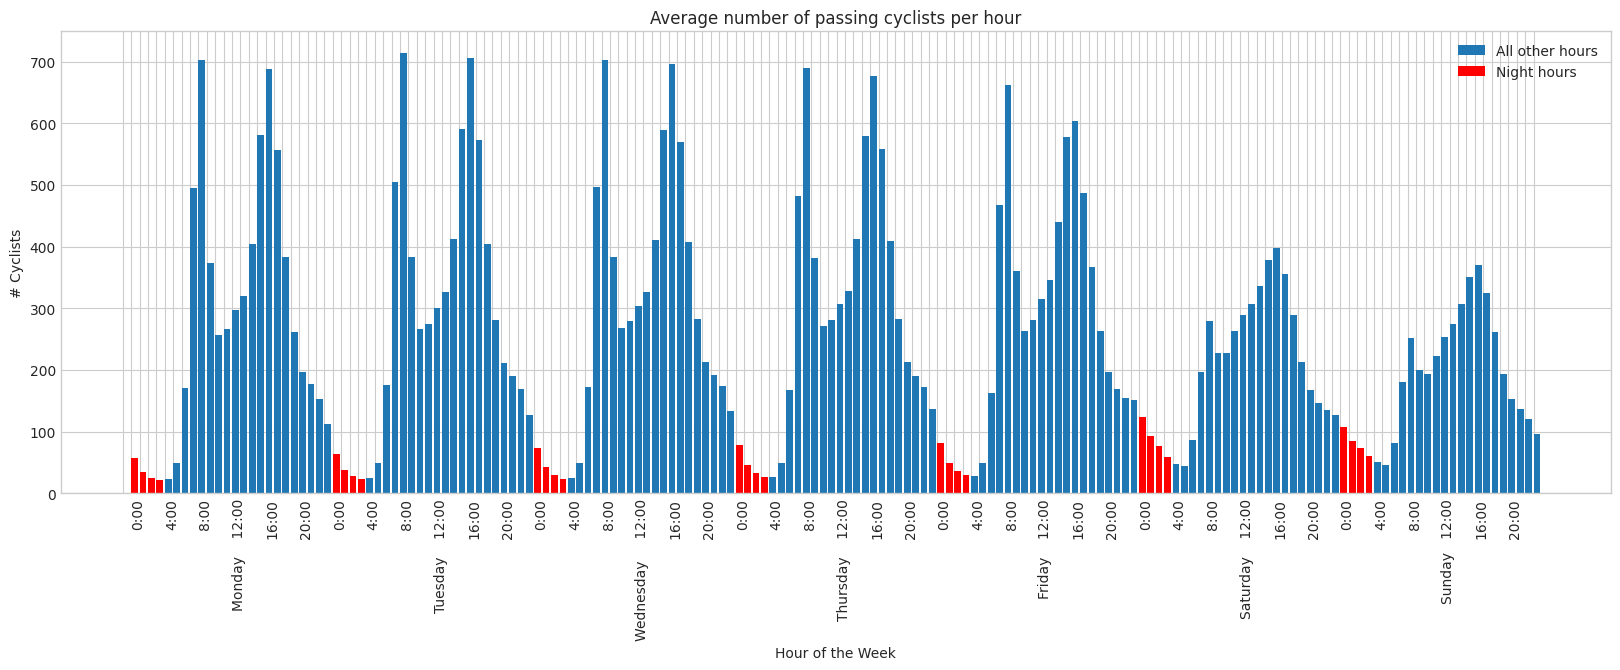

In [ ]:
# Inspect total
df_bike_T = df_bike[df_bike['Direction'].str.contains("T")]

# Extract average per week day
week_df = df_bike_T.groupby(df_bike_T['Date'].dt.dayofweek).mean().iloc[:, 3:]

hours = list(np.arange(24*7))
counts = []

for day, count in week_df.iterrows():
    counts += list(count)


fig, ax = plt.subplots(figsize=(20,6))

days = ['Monday ','Tuesday ','Wednesday  ','Thursday ','Friday ','Saturday ','Sunday']
labels = [""]
for day in days:
    labels += [str(i) + ":00" if (i % 4 == 0) else "" for i in np.arange(0, 12)]
    labels.append(day + "   12:00")
    labels += [str(i) + ":00" if (i % 4 == 0) else "" for i in np.arange(13, 24)]



ax.set_xticks(np.arange(len(labels))-1)
ax.set_xticklabels(labels, rotation=90, rotation_mode="anchor", ha="right")

ax.set_title("Average number of passing cyclists per hour")
ax.set_ylabel("# Cyclists")
ax.set_xlabel("Hour of the Week")
ax.bar(x=hours, height=counts, align="edge", label="All other hours")

night_counts = []
night_hours = []
for hour, count in zip(hours, counts):
    if (hour % 24) < 4:
        night_hours.append(hour)
        night_counts.append(count)

ax.bar(x=night_hours, height=night_counts, color="red", align="edge", label="Night hours")

plt.legend()
plt.show()

We see that monday-friday has similar patterns to the hourly patterns found in the previous section with large peaks in the morning and afternoon. These patterns are not appearent in the weekends, which implies that the spikes origins from people traveling to work, school, etc. We also notice that the peak at 17 on Friday is less salient than the other weekdays, which could suggest that people are typically leaving ealier or staying late for a beer. Interestingly, we can actually also see that during the late evening hours from 00:00-04:00 (marked with red), there is a significant higher amount of people bicycling Friday and Saturday - just as we hypothesised. This pattern is probably due to the the nightlife in the weekends.

We figured that it could also be interesting to see if you could get a spatial impression of where the nightlife is dominating in the city. For this purpose we made a interactive plot similar to earlier, were we let the size of the circles be proportional to the avg. number of passing cyclists at the specified hour on the given location:

In [ ]:
folium_df = pd.DataFrame()

# Get unique positions
counting_positions = []
for (utm_x, utm_y, road_name) in zip(df_bike.X, df_bike.Y, df_bike.RoadName):
    counting_positions.append((utm.to_latlon(utm_x, utm_y, 32, northern=True), road_name))
    
# Only include unique positions
counting_positions = list(set(counting_positions))

for (lat, lon), road_name in counting_positions:
    df_road = df_bike[(df_bike["RoadName"] == road_name) & df_bike['Direction'].str.contains("T")]
    
    # Extract average per week day
    df_road = df_road.groupby(df_road['Date'].dt.dayofweek).mean().iloc[:, 3:]

    # Look at Fridays and saturdays
    counts = []
    counts += list(df_road.iloc[4, :])
    counts += list(df_road.iloc[5, :])


    for hour, count in enumerate(counts):
        color = "red"
        new_data = pd.DataFrame( [[road_name, lat, lon, hour, count, color]], columns = ["RoadName", "lat", "lon", "hour", "count", "fillColor"])
        folium_df = folium_df.append(new_data,  ignore_index=True)


####


start_geojson = create_geojson_features(folium_df, scale_radius=1/100, apply_log_scale = False)

CPH_map = folium.Map([55.676098, 12.568337], zoom_start=13, tiles="Stamen Terrain")

TimestampedGeoJson(start_geojson,
                  period = 'PT1H',
                  duration = 'PT1M',
                  transition_time = 1000,
                  time_slider_drag_update=True,
                  date_options="[(Fri 00:00' - Sat 04:00')]   -----  HH:mm",
                  auto_play = False).add_to(CPH_map)
#CPH_map.save('312.html')
folium_deepnote_show(CPH_map)

As each circle is relative to the average number of passing cyclists, the biggest circle will be the location where most cyclists are passing at the hour specified by the slider (click on a circle to get the name of the location). This visualization actually shows that a Dr. Louises bro seem to be relatively more in use during the night hours. This can be seen by first moving the slider to the rush hours at 08:00 and then 16:00, where we in both cases can conclude that *Torvegade* seems to be the most used bikelane of the 13 measured on Fridays. If we then move the slider to somewhere between 00:00-04:00, we see that *Dr. Louises Bro* is now the most trafficed bike lane. This implies that many people are leaving the central Copenhagen at these hours to travel towards the suburbs of Copenhagen - probably after a couple of beers in the city. 

### 3.1.3. Monthly Patterns
Now, we enlarge the time-perspective a bit and look at the monthly and seasonal patterns. We want to address the question of whether the month has an impact on how many people chooses to bicycle. To address this, we will count how many bicycles passes on a given month and average across the locations:

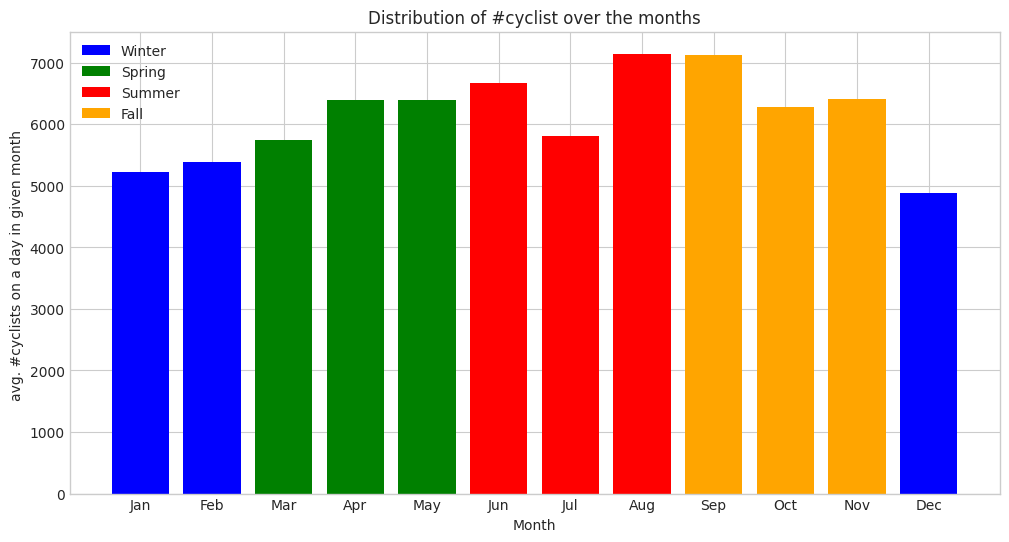

In [ ]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


df_bike_T = df_bike[df_bike['Direction'].str.contains("T")]
month_df = df_bike_T.groupby(df_bike_T['Date'].dt.month).mean().iloc[:, 3:]
avg_counts_per_month = list(month_df.sum(axis=1))

plt.figure(figsize=(12,6))
plt.title("Distribution of #cyclist over the months")
plt.ylabel("avg. #cyclists on a day in given month ")
plt.xlabel("Month")

plt.bar(x=months[0:2], height=avg_counts_per_month[0:2], color="blue", label="Winter")
plt.bar(x=months[2:5], height=avg_counts_per_month[2:5], color="green", label="Spring")
plt.bar(x=months[5:8], height=avg_counts_per_month[5:8], color="red", label="Summer")
plt.bar(x=months[8:11], height=avg_counts_per_month[8:11], color="orange", label="Fall")
plt.bar(x=months[11], height=avg_counts_per_month[11], color="blue")

plt.legend()
plt.show()

This plot clearly shows that there is a difference between how many people bicycles in a month. Most people are riding the bike in August and September, whereas the least are in December. 


The pattern seems to indicate that people more often chooses the bike in the warm months and seasons, which gives rise to hypothesising that the weather has an impact on the bicycle patterns. For example, Danes seem to on average bicycle ($7100/5200=1.36$) 36% more in September than January. It would be interesting to see to what extent different weather phenomeons like precipitation, temperature, wind speed and combinations of these impact the Danes bicycle patterns. 

We notice this hypothesis to some extent could be challenged from the fact that December has a significant less amount of passing bicyclists even though it typically isn't the coldest month in Denmark. And similarly for July despite that it usually offers very appealing weather for bicyclists. We plot the average countings for every week throughout the year to see if we can identify why this might be:

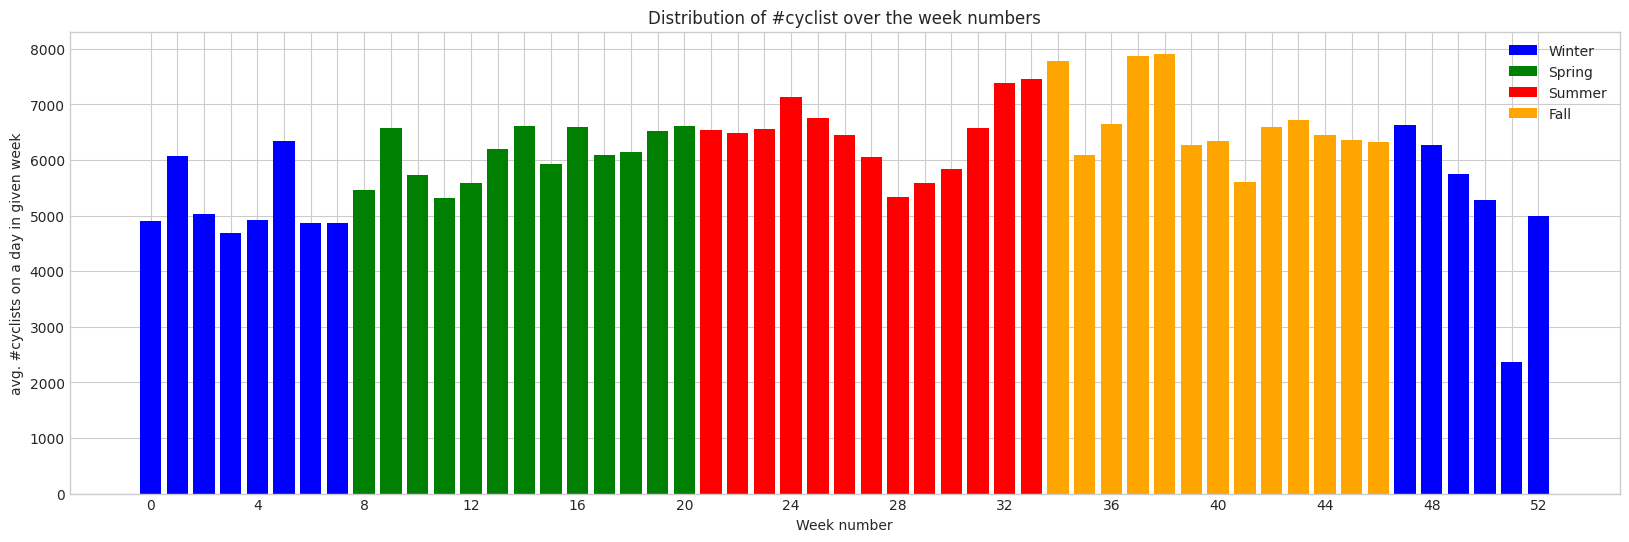

In [ ]:
weeks = np.arange(53)

df_bike_T = df_bike[df_bike['Direction'].str.contains("T")]
week_df = df_bike_T.groupby(df_bike_T['Date'].dt.isocalendar().week).mean().iloc[:, 3:]
avg_counts_per_month = list(week_df.sum(axis=1))

fig, ax = plt.subplots(figsize=(20,6))
ax.set_title("Distribution of #cyclist over the week numbers")
ax.set_ylabel("avg. #cyclists on a day in given week")

ax.set_xticks(np.arange(len(weeks)))
labels = [m if m%4==0 else "" for m in weeks]

ax.set_xticklabels(labels)

ax.set_xlabel("Week number")

#ax.bar(x=weeks, height=avg_counts_per_month)

plt.bar(x=weeks[0:8], height=avg_counts_per_month[0:8], color="blue", label="Winter")
plt.bar(x=weeks[8:21], height=avg_counts_per_month[8:21], color="green", label="Spring")
plt.bar(x=weeks[21:34], height=avg_counts_per_month[21:34], color="red", label="Summer")
plt.bar(x=weeks[34:47], height=avg_counts_per_month[34:47], color="orange", label="Fall")
plt.bar(x=weeks[47:], height=avg_counts_per_month[47:], color="blue")
plt.legend()
plt.show()

From the plot it appears that the weeks in December in general has more more passing bicyclists than the other winter months, except in week 51. But this also makes great sense as this is the week of Christmas eve where you would expect a lot of people spending the christmas hollidays. This might also explain why we see the decrease in July (week 27-29) as these are common weeks for spending the summer holidays. To conclude we still find it reasonable to hypothesis that there could be a connection to the weather, which we will investigate in in *section 3.3* and *3.4*.

### 3.1.4. Yearly Patterns
Finally we want to investigate whether there seem to be any patterns in how many people who uses these roads over the years. Here we have to be carefull with averaging over all roads, as all roads were not included in every year, which then might heavily bias the results. For example, the interactive plot from Friday 00:00 until Saturday 04:00 indicated that some roads on average had a lot more activity on the bike lanes. We can check the average number of passing cyclists on the different lanes:



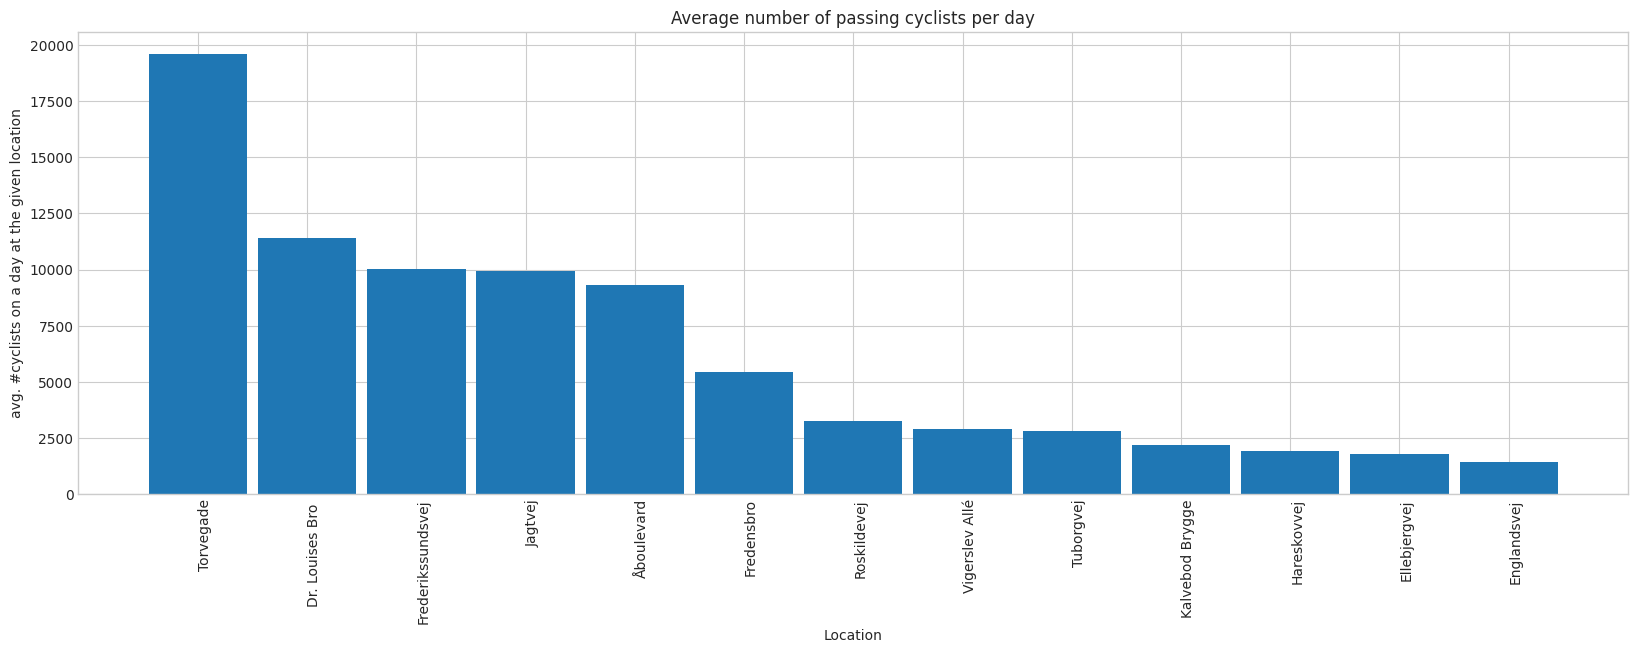

In [ ]:
roads = df_bike["RoadName"].unique()
avg_passed_cyclists_pr_road = []

# Inspect total
df_bike_T = df_bike[df_bike['Direction'].str.contains("T")]

for road in roads:
    x = df_bike_T[df_bike_T["RoadName"] == road].iloc[:, 6:30].sum(axis=1).mean()
    avg_passed_cyclists_pr_road.append((x, road))

# Sort by nr. of cyclists
avg_passed_cyclists_pr_road = sorted(avg_passed_cyclists_pr_road, key=lambda x: x[0], reverse=True)
roads = [r for (n, r) in avg_passed_cyclists_pr_road]
avg_passed_cyclists_pr_road = [n for (n, r) in avg_passed_cyclists_pr_road]

fig, ax = plt.subplots(figsize=(20,6))

ax.set_title("Average number of passing cyclists per day")
ax.set_ylabel("avg. #cyclists on a day at the given location")
ax.set_xlabel("Location")

roads = [r if len(r) < 20 else r[:16] for r in roads]
ax.set_xticks(np.arange(len(roads)))
ax.set_xticklabels(roads, rotation=90, rotation_mode="anchor", ha="right")

ax.bar(x=roads, height=avg_passed_cyclists_pr_road, width=0.9)
plt.show()


And truly, this varies a lot between roads. The plot shows that you would expect that years where e.g. Torvegade is included to have much more cyclists on average. But it doesn't end here. Recall that we have previously seen that
- the seasonality had an impact on how many seemed to bicycle
- measurements where not conducted on every day throughout the year

Thus, if we just look at the yearly tendencies without taking these observations into account, the results might be biased towards years where measurements where more frequently conducted in some seasons. One way of accounting for this is by plotting the following side by side:

1. the measurements per year colored by season
1. number of measurements per year

With this, we can see if any development throughout years are impacted on e.g. the summer months being overly represented for some year. This plot will be created below. To create the plot we first (roughly) define the seasons:



In [ ]:
spring = range(60, 151)
summer = range(151, 243)
fall = range(243, 333)

def day_to_season(x):
    if x in spring:
        return 'Spring'
    if x in summer:
       return 'Summer'
    if x in fall:
       return 'Fall'
    else:
       return 'Winter'


And then create the plot:

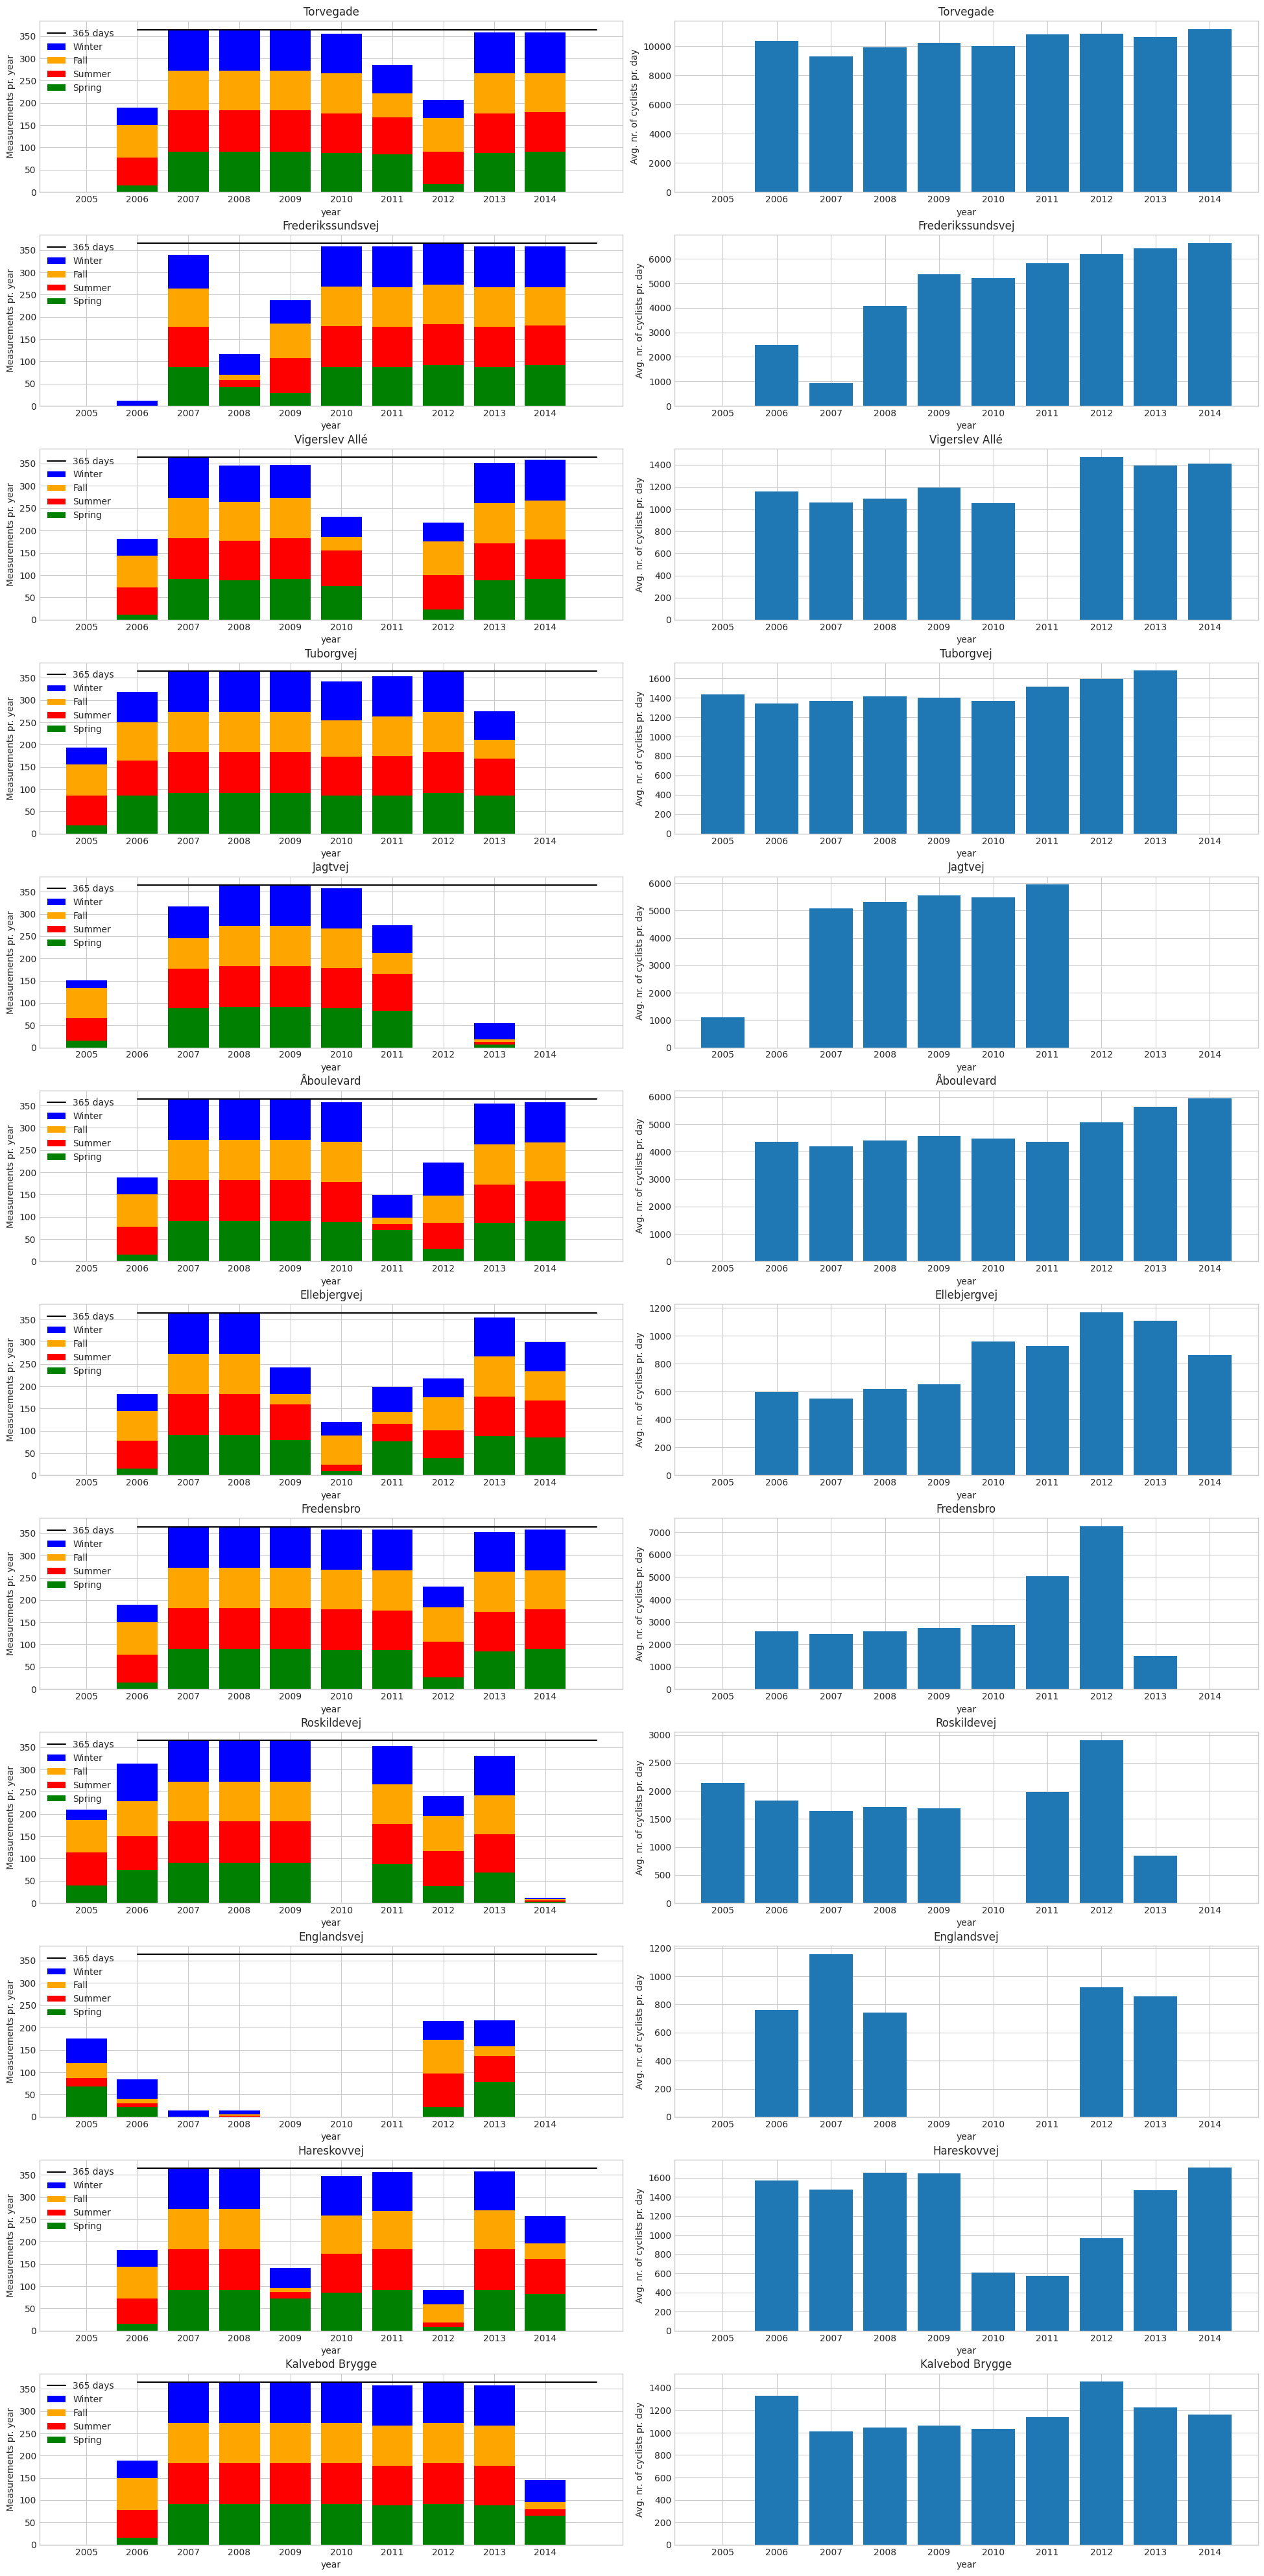

In [ ]:
roads = list(set(df_bike["RoadName"]))
roads.remove('Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)')

years = range(2005, 2015)
all_roads_aggregrated = np.zeros(len(years))

fig, axes = plt.subplots(12, 2, figsize=(20,40))
fig.tight_layout(pad=3.0)

avg_cyclist_pr_year = np.zeros(len(years))

# Loop over each road, and make subplot for each:
for j, road in enumerate(roads):

    # init data structures
    road_data = df_bike[(df_bike["RoadName"] == road) & (df_bike["Direction"] == "-")]
    yearly_obs_on_road = np.zeros(len(years))

    yearly_obs_on_road_spring = np.zeros(len(years))
    yearly_obs_on_road_summer = np.zeros(len(years))
    yearly_obs_on_road_fall = np.zeros(len(years))
    yearly_obs_on_road_winter = np.zeros(len(years))


    # Loop over the 10 years, on order to make a single subplot:
    for i, year in enumerate(years):
        # __________RAINBOW PLOT (SEASONAL COUNT):__________
        dates = road_data[road_data["Date"].dt.year == year]["Date"]
        n_unique_dates = len(set(dates))
        yearly_obs_on_road[i] = n_unique_dates

        season_df = road_data[road_data["Date"].dt.year == year]["Date"].groupby(road_data['Date'].dt.dayofyear.map(day_to_season)).size()
        

        for season in ["Spring", "Summer", "Fall", "Winter"]:
            if season not in season_df.keys():
                season_df[season] = 0

        yearly_obs_on_road_spring[i] = season_df["Spring"]
        yearly_obs_on_road_summer[i] = season_df["Summer"] + yearly_obs_on_road_spring[i]
        yearly_obs_on_road_fall[i] = season_df["Fall"] + yearly_obs_on_road_summer[i]
        yearly_obs_on_road_winter[i] = season_df["Winter"] + yearly_obs_on_road_fall[i]


        # __________ BICYCLE COUNTS PER YEAR: __________
        df_year = road_data[(road_data['Date'].dt.year == year)]

        n_measurements_year = len(df_year)

        # Sum accross columns and rows:
        total_counts_year = df_year.iloc[:, 6:30].sum().sum()

        if n_measurements_year > 0:
            avg_cyclist_pr_year[year-2005] = total_counts_year/n_measurements_year
        else:
            avg_cyclist_pr_year[year-2005] = 0


    # __________ PLOT RAINBOW (SEASONAL COUNTS) __________ 
    axes[j, 0].set_title(road)
    axes[j, 0].bar(years, yearly_obs_on_road_winter, label="Winter", color="blue")
    axes[j, 0].bar(years, yearly_obs_on_road_fall, label="Fall", color="orange")
    axes[j, 0].bar(years, yearly_obs_on_road_summer, label="Summer", color="red")
    axes[j, 0].bar(years, yearly_obs_on_road_spring, label="Spring", color="green")
    axes[j, 0].plot([2006, 2015], [365, 365], color="black", label="365 days")
    axes[j, 0].set_xticks(years)
    axes[j, 0].set_xlabel("year")
    axes[j, 0].set_ylabel("Measurements pr. year")
    axes[j, 0].legend(loc="upper left")


    # __________ PLOT BICYCLE COUNTS __________
    axes[j, 1].set_title(road)
    axes[j, 1].bar(years, avg_cyclist_pr_year, label="#days")
    axes[j, 1].set_xticks(years)
    axes[j, 1].set_xlabel("year")
    axes[j, 1].set_ylabel("Avg. nr. of cyclists pr. day")


plt.show()





The way to reason with this plot is to on the left plot find the years where measurements where done in most of the year (close to the 365 bar) as well as evenly distributed among the seasons (similar size of red, blue, green and yellow bar). The years for which this is true are then compareable on the right plot. Thus - Overall - it seems like the number of bicyclists has increased over the years:

- For *Frederikssundsvej*, the measurements are distributed evenly throughout the seasons from 2010-2014 (left plot). And on the right plot we clearly see an increasing tendency in the number of bicyclists over these years.
- Similar patterns (although with different magnitudes) can be observed for *Tuborgvej* from 2007-2012. The number of bicyclists increases even more in 2013, even though *Fall** is under-represented, which is the season where most people bicycle!
- Also we see the increasing pattern for *Kalvebod Brygge* from 2007-2012. However, it decreases again in 2013. But this is probably due to "extensive road work" (https://kk.sites.itera.dk/apps/kk_pub2/pdf/1446_5bJZcCkJCB.pdf).
- Looking at. *Vigerslev allé*, we see that comparing 2007-2009 with 2013-2014 there seem to be a signficant increase in the number of bicyclists. Note that we exclude 2012 from this comparison as it is over-repesented by summer and fall - i.e. probably biased towards too many cyclists in this year.
- Fredensbro also has an upward-going trend (ignoring the extreme increase in 2012 as it is probably related to over-represented summer and fall). We do however see an extreme decrease of bicyclists in 2013 and 2014. However, a bit of research showed that *Fredensbro* was under reconstruction in that period (https://da.wikipedia.org/wiki/Fredensbro), which might explain it. 
- Then comparing *Torvegade* from 2007-2011 with 2013-2014 also indicate a slight increase of bicyclists.
- Same goes for *Åboulevard* comparing 2007-2010 with 2013-2014
- And finally also for *Ellebjergvej* comparing 2007-2008 with 2013-2014

For the other roads, we observe that:
- *Roskildevej* is a bit ambiguous. It seems to increase from 2006-2009 compared to 2011-2012, however it has a huge drop in 2013 which we could not find any explanation for with a but of research. But the drop seems very extreme compared to the other roads and might therefore not be too representative.
- *Hareskovvej* has a similar extreme drop which we could not find any documentation for. But again, these jumps seem to extreme to conclude anything upon.
- *Englandsvej* is missing too many measurements to conclude anything.
- *Jagtvej* is mostly mesured in the initial years and therefore not as informative regarding the yearly development (although the trend for number of bicyclists seems to be increasing).

So the conclusion is that the data indicates an increasing number of bicyclists on these roads. However, these observations are based only on a few roads and years, where we ideally would have data for many roads. In that case, it would be more meaninfull to average across all the roads, as the biases from road work and over/under-represented seasons would to a larger extent be averaged out. 

Even though it would be tempting that this implies people in Copenhagen have started choosing the bike more, we need to keep in mind that the population of Copenhagen has also increased over the years. Below, we plot the population over the same range of years \[Popu\]:

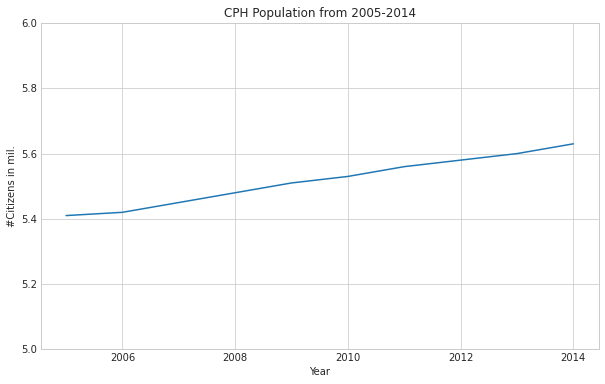

In [ ]:
population = [5.41, 5.42, 5.45, 5.48, 5.51, 5.53, 5.56, 5.58, 5.60, 5.63]
years = range(2005, 2015)



plt.figure(figsize=(10,6))
plt.plot(years, population)
plt.xlabel("Year")
plt.ylabel("#Citizens in mil.")
plt.title("CPH Population from 2005-2014")
plt.ylim(5,6)
plt.show()

The relation between the development in population size and nr. of bicycles would be very interesting to investigate even further in future work. Although, to get a brief impression of the relation, we compare the relative increase in population size with the relative increase of bicycles with some road - here for *Tuborgvej*:

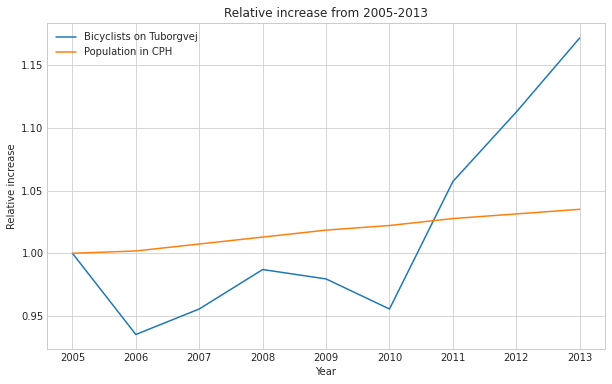

In [ ]:
road = "Tuborgvej"
population = [5.41, 5.42, 5.45, 5.48, 5.51, 5.53, 5.56, 5.58, 5.60]
years = range(2005, 2014)
road_data = df_bike[(df_bike["RoadName"] == road) & (df_bike["Direction"] == "-")]
avg_cyclist_pr_year = np.zeros(len(years))
# Loop over the 10 years, on order to make a single subplot:
for i, year in enumerate(years):
    df_year = road_data[(road_data['Date'].dt.year == year)]
    n_measurements_year = len(df_year)
    # Sum accross columns and rows:
    total_counts_year = df_year.iloc[:, 6:30].sum().sum()
    avg_cyclist_pr_year[year-2005] = total_counts_year/n_measurements_year


relative_increase_pr_year_bicyclists = [n/avg_cyclist_pr_year[0] for n in avg_cyclist_pr_year]
relative_increase_population = [n/population[0] for n in population]

plt.figure(figsize=(10,6))
plt.plot(years, relative_increase_pr_year_bicyclists, label="Bicyclists on Tuborgvej")
plt.plot(years, relative_increase_population, label="Population in CPH")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Relative increase")
plt.title("Relative increase from 2005-2013")
plt.show()




Here we see that although the increasing number of citizens might contribute to the increasing number of bicyclists on the road, it appears that the number of bicyclists increases signficantly more, which might suggest that more and more people *chooses* the bike over other alternatives! 

## 3.2 Impact of Super Bike Lanes

We've just seen that there seem to be a general tendency over the years towards people in Copenhagen choosing the bicycle more often. From an environmental perspective this is great news. And even better if we could make even more people ride the bike. Therefore, this has also been an agenda for the Danish government, which has started building "supercykelstier" (super bike lanes) all around Copenhagen. The purpose of these roads are to improve the bicycle conditions and thereby make more people choose the bike over less environmental-friendly alternatives. But do the super bike lanes seem to have an impact on the Danes' choice of transportation? And if so - to what extent?

Many of the bicycle lanes included in this data are actually bicycle lanes. However, most of them were not finished until 2017. But after some research it turns out that the measuring spot on *Hareskovvej* of our data, is part of one of the few bicycle lanes which opened before 2017. In fact, it opened in April 2013 \[Har2013\] which means we have data both before and after the opening. Below, you see the location of the measuring spot which is located in the north-western Copenhagen:



In [ ]:
road = "Hareskovvej"
utm_x, utm_y = df_bike[df_bike["RoadName"] == road].iloc[0].X, df_bike[df_bike["RoadName"] == road].iloc[0].Y
lat, lon = utm.to_latlon(utm_x, utm_y, 32, northern=True)


# Then plot it using folium
CPH_map = folium.Map([lat, lon], zoom_start=15, tiles="Stamen Terrain")


loc = 'Map of Hareskovvej'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

CPH_map.get_root().html.add_child(folium.Element(title_html))

folium.CircleMarker([lat, lon], color="red", radius=3, 
                    popup=road,
                    fill=True
                    ).add_to(CPH_map)


folium_deepnote_show(CPH_map)

In this section we will therefore investigate:

- Have more people started bicycling on *Hareskovvej* after the opening of the super bike lane in April 2013?
- If so, how many more?

As a first step, let us see at the data around the opening of the super bike lane:

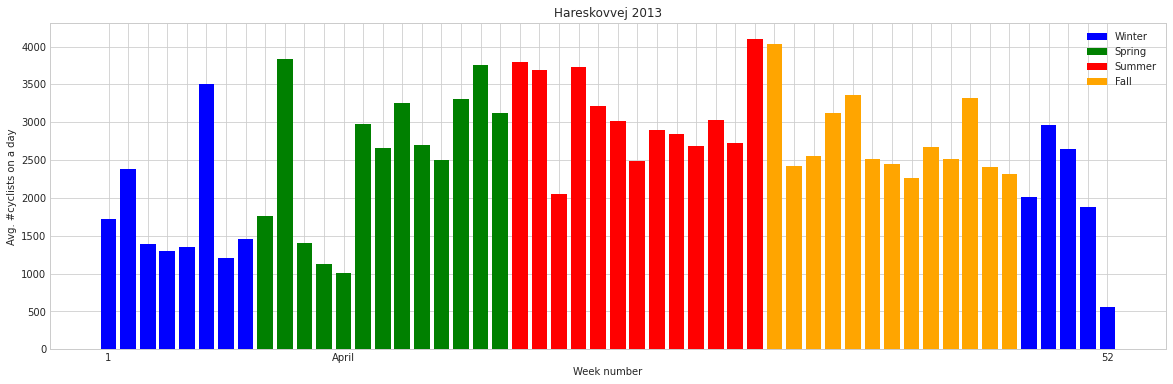

In [ ]:
weeks = np.arange(52)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


df_bike_T = df_bike[(df_bike['Direction'].str.contains("T")) & (df_bike['RoadName'] == "Hareskovvej") & (df_bike['Date'].dt.year == 2013)]
week_df = df_bike_T.groupby(df_bike_T['Date'].dt.isocalendar().week).mean().iloc[:, 3:]
avg_counts_per_month = list(week_df.sum(axis=1))

fig, ax = plt.subplots(figsize=(20,6))
ax.set_title("Hareskovvej 2013")
ax.set_ylabel("Avg. #cyclists on a day")

ax.set_xticks(np.arange(len(weeks)))
labels = ["" for m in weeks]
labels[0] = 1
labels[12] = "April"
labels[-1] = 52
ax.set_xticklabels(labels)
ax.set_xlabel("Week number")

plt.bar(x=weeks[0:8], height=avg_counts_per_month[0:8], color="blue", label="Winter")
plt.bar(x=weeks[8:21], height=avg_counts_per_month[8:21], color="green", label="Spring")
plt.bar(x=weeks[21:34], height=avg_counts_per_month[21:34], color="red", label="Summer")
plt.bar(x=weeks[34:47], height=avg_counts_per_month[34:47], color="orange", label="Fall")
plt.bar(x=weeks[47:], height=avg_counts_per_month[47:], color="blue")
plt.legend()
plt.show()

From inspecting the plot around the beginning of April, it definitely seems like the opening of the super bike lane is observable in the data - at the beginning of April we see a significant increase in the average number of bicyclists on a day. However, the sudden increase is more likely an outcome of the construction work finishing rather than a sudden increase in popularity. Also, seasonality might play a role as well.

Therefore, in order to see if the super bike lane had an impact, we'll choose some months and compare how many bicyclists there were each year in these months. For instance, we could then see if the avg. number of bicyclists in May 2013 and May 2014 is higher than May in 2005-2012. If so, we would find it likely that the super bike lane did have an impact (as it opened in April 2013). Moreover, the neat thing about comparing the same month across years is that it will account for seasonality. 

However, there is still one thing we need to consider. We previously saw that the countings during weekends were a lot lower than weekdays. Therefore, the average number of cyclists would be biased if May 2014 contained four weekends and May 2010 only three. We can account for this by including the same five week numbers in each year, as this would include five mondays, tuesdays... and sundays. 

But even with this, we cannot guarantee a fair comparison, as we've also seen that the data is missing values at some days. As an example, we have plotted the five weeks around July below for each year:

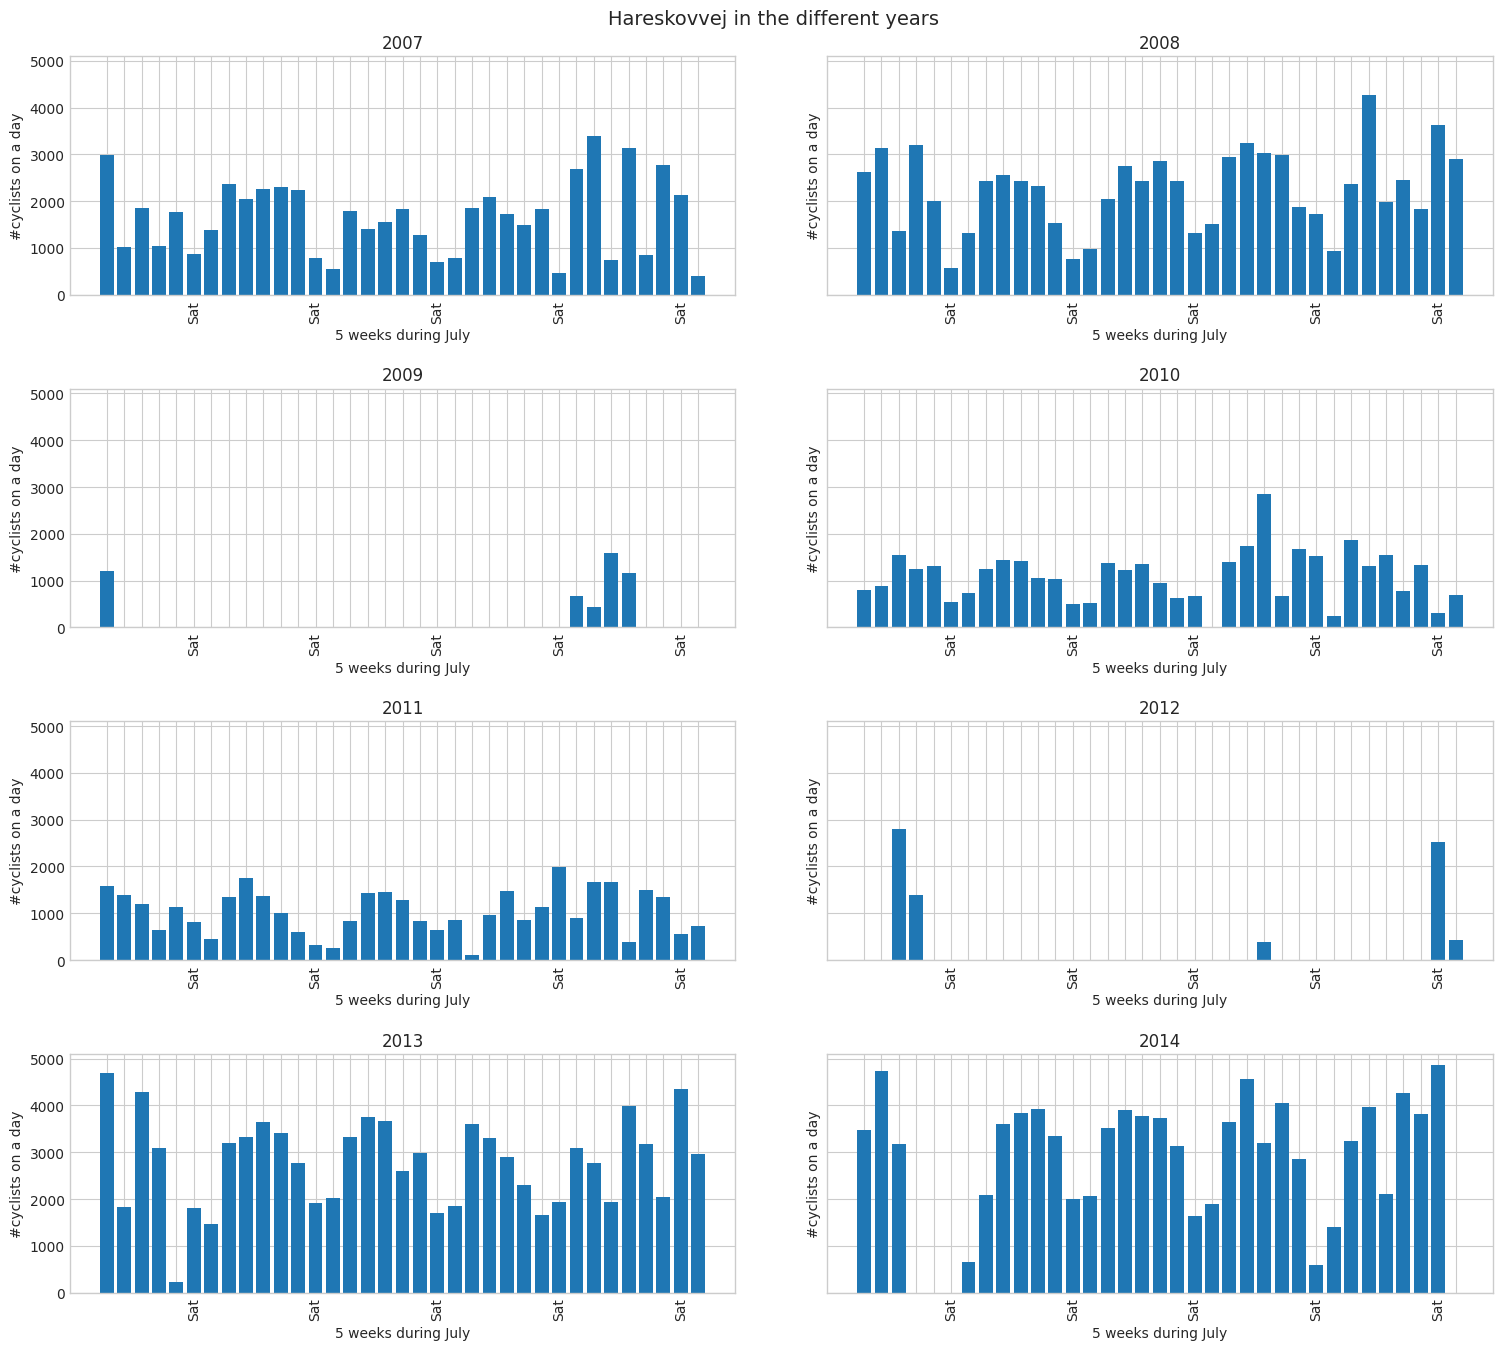

In [ ]:
weeks_in_may = [18, 19, 20, 21, 22]
# Translocate to July
weeks_in_may = [w+10 for w in weeks_in_may]
df_bike_T = df_bike[(df_bike['Direction'].str.contains("T")) & (df_bike['RoadName'] == "Hareskovvej") & (df_bike['Date'].dt.isocalendar().week.isin(weeks_in_may)) ]
years = range(2007, 2015)
days_in_may = range(35)

fig, axes = plt.subplots(4, 2, figsize=(16,14), sharey=True)
fig.tight_layout(pad=5.0)
for i, (ax, year) in enumerate(zip(axes.flatten(), years)):
    #year=2008
    year_df = df_bike_T[df_bike_T["Date"].dt.year == year]
    
    # Loop over the 35 days, starting from Monday in week 18 of that year
    next_date = str(year) + "-W28"
    next_date = datetime.datetime.strptime(next_date + '-1', "%G-W%V-%u")

    counts_per_day = np.zeros(len(days_in_may))
    for incr_day in days_in_may:

        counts = year_df[year_df["Date"].dt.date == next_date.date()].iloc[:, 6:30].sum(axis=1)
        counts_per_day[incr_day] = int(counts) if len(counts) > 0 else 0

        next_date += datetime.timedelta(days=1)

    ax.bar(days_in_may, counts_per_day)
    ax.set_title(year)
   
    ax.set_xticks(np.arange(len(days_in_may)))

    labels = ["" for m in days_in_may]
    for i in days_in_may:
        if i%7 == 5:
            labels[i] = "Sat"
    
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("5 weeks during July")
    ax.set_ylabel("#cyclists on a day")

fig.suptitle("Hareskovvej in the different years", fontsize=14)

plt.show()


Here it appears that 2009 and 2012 almost had no measurements in July. You can also observe that 2014 had some weekdays and a single saturday where no observations were made. This would bias the average number of bicyclists towards a lower value, as we've previously seen that weekends typically had less bicyclists than weekdays. Similar patterns can be observed for the other months where small biases would pull the average in either directions

A "fair comparison" would then be to only include the years where observations were made on all 35 days of the five weeks. Although, we might also expect the bias of weekdays vs. weekends is fairly small or evens out. Therefore, we make both analyses; one where we only compare among years with all 35 days included, and another where we compare the average nr. of cyclists no matter how manny of the 35 days were measured. First we extract these values:

In [ ]:
counting_columns = list(df_bike_T.columns[6:30]) # Columns with 0-1, 1-2, 2-3....

examined_months = ["May", "Jun", "Jul", "Aug"] #"Sep", "Oct", "Nov", "Dec"]

month2yearcounts = {}
month2comp_yearcounts = {}

weeks_in_may = [18, 19, 20, 21, 22]
for i, month in enumerate(examined_months):
    
    # Examine 5 weeks at the time (roughly a month) starting in may
    weeks = [w+5*i for w in weeks_in_may]
    df_bike_T = df_bike[(df_bike['Direction'].str.contains("T")) & (df_bike['RoadName'] == "Hareskovvej") & (df_bike['Date'].dt.isocalendar().week.isin(weeks)) ]

    # First, find years where there are at least 34 measurements:
    counts_per_year = df_bike_T.groupby(df_bike_T['Date'].dt.year).size()
    compareable_years = list(counts_per_year[counts_per_year>34].index)

    # Per group, count how many people bicycle on average per day, during these 5 weeks
    counts_every_year = df_bike_T.groupby(df_bike_T['Date'].dt.year)[counting_columns].mean().sum(axis=1)
    month2yearcounts[i] = counts_every_year


    # Make dataframe with only compareable years
    comp_counts_every_year = counts_every_year.copy(deep=True)


    for y in comp_counts_every_year.index:
        if y not in compareable_years:
            comp_counts_every_year[y] = 0   

    month2comp_yearcounts[i] = comp_counts_every_year
    

Then we plot the "fair comparisons" based on equal nr. of days to the left and the possibly biased (in both directions) to the right

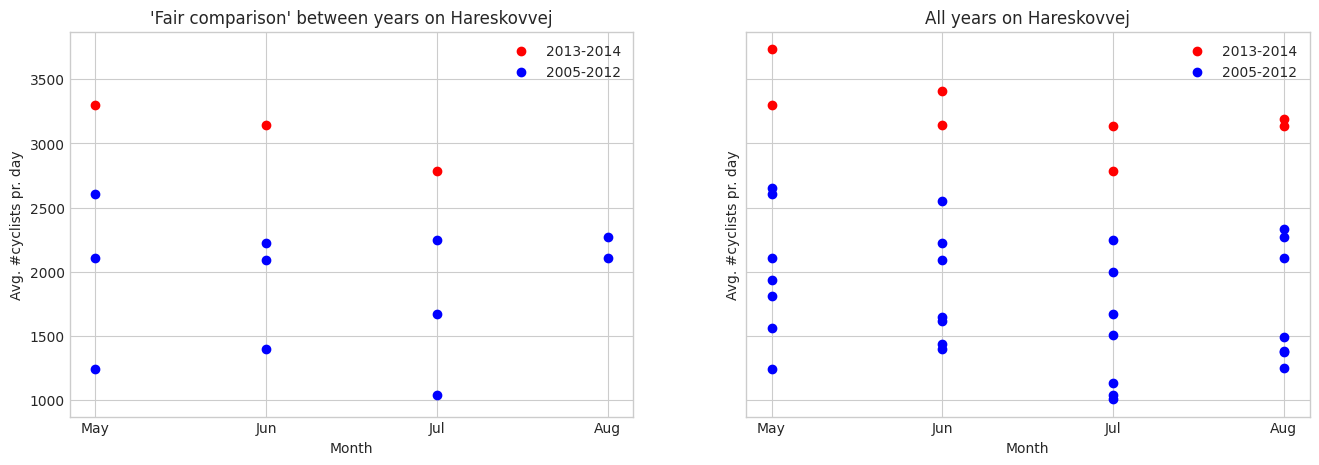

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5), sharey=True)
aft_x = [[], []]
aft_y = [[], []]
b4_x = [[], []]
b4_y = [[], []]


for year in range(2006, 2015):

    for i, m2yc in enumerate([month2comp_yearcounts, month2yearcounts]):
        x = []
        y = []
        for month, yearcounts in m2yc.items():
            if yearcounts[year] > 0:
                y.append(yearcounts[year])
                x.append(month)
        # only plot if any counts in month
        if sum(y) != 0:
            if year> 2012:
                aft_x[i] += x
                aft_y[i] += y
            else:
                b4_x[i] += x
                b4_y[i] += y

    

 
    # We only want data for the compareable years
   # for y in counts_every_year.index:
   #     if y not in compareable_years:
   #         counts_every_year[y] = 0   
labels = examined_months

for i in range(2):
    ax[i].scatter(aft_x[i], aft_y[i], label="2013-2014", color="red")
    ax[i].scatter(b4_x[i], b4_y[i], label="2005-2012", color="blue")
    ax[i].set_xticks(np.arange(len(examined_months)))
    ax[i].set_xticklabels(labels)
    ax[i].set_xlabel("Month")
    ax[i].set_ylabel("Avg. #cyclists pr. day")
    ax[i].legend()

ax[1].set_title("All years on Hareskovvej")
ax[0].set_title("'Fair comparison' between years on Hareskovvej")


plt.show()

In the plot, every point is the average number of bicyclists in the specified month. Each point in the same month (vertically) is then for different years, where the dots are colored red if they are after April 2013 (2013-2014) and blue if before (2005-2012). For example, the top left point in the 'fair comparison' plot means that in some year after the super bike lane opened (2013-2014), there were on average ~3300 daily cyclists during May. We can then observe that more bicyclists passed on *Hareskovvej* at every month and year after the opening of the super bike lane, as every red point is higher up than the blue ones. This implies that the super bike lanes do have an impact on how many people chooses the bike! 

We can give a rough estimate on how many more have chosen the bike since the super bike lane finished. If we inspect the plot, we see that the smallest increase from before and after the opening seems to be for July (smallest distance between a red and blue point). We extract these values and look at the relative increase:

In [ ]:
july_after2012 = aft_y[0][2]
july_before2013 = b4_y[0][6]

july_after2012/july_before2013

1.2387838009394438

So a pessimistic prediction would be that we see an 23% increase in the number of bicyclists on Hareskovvej after the super bike lane was introduced. Note that this "pessimistic" prediction on the increase of cyclists is much higher than the yearly increase in size of the Copenhagen population since 2005 (~2%) - and also higher than the general increase of cylists on the roads since 2005 (~17%). This confirms that the super bike lane did seem to have an impact on Hareskovvej. A more accuracte prediction would probably be to compute the increase of the average number of bicyclists before and after April 2013 on Hareskovvej:

In [ ]:
after2012 = np.mean(aft_y[0])
before2013 = np.mean(b4_y[0])

after2012/before2013

1.609688143263705

Which shows that we from the data can observe that 61% more people on average for the four chosen months are using the bikelane on Hareskovvej after the super bike lane was introduced. This fits very well with other analyses done on the the super bike lane of Hareskovvej. Analyses based on newer data going until 2018 shows that there has been an increase of 68% on weekdays and 108% in weekends \[Har2013\]. In connection to this, it is also worth mentioning that our work suggest that the government's goal of a 25% increase number of cyclists on this super bike lane is reached \[Goal2013\]. This was said to save 230 tons of $\text{CO}_2$ and 10.1 mill. danish kroner as gain in healthcare economics.  



## 3.3 Investigating the Impact of the Weather
We also want look into the relationship between the weather conditions in Copenhagen and the amount of cyclists. Specifically we want to investigate the:

- impact of temperature,
- impact of precipitation,
- and impact of wind – or, does tailwind increase the number cyclists?

The Danish Meterological Institute has an [open API](https://confluence.govcloud.dk/display/FDAPI/Getting+Started+with+DMI+data), which can be used to download historical weather data. It is possible to get data from a single weather station, all observations within a specified area or all observations for each month. As we are working with bicycle data from the Copenhagen area, we want to get localized data, so we get observations within a specified bounding box that covers the area our bicycle measurements are conducted. This results in measurements from three weather stations:

In [ ]:
# (lon, lat) 12.447848326393638, 55.606375666851676
# 55.73107930538074, 12.692825590170797

# Weather station coordinates
weather_stations = [(55.6878, 12.5742,'Botanical Garden'),( 55.6814, 12.5403,'Landbohøjskolen'),(55.7161, 12.5622, 'DMI')]

# Plotted using
CPH_map = folium.Map([55.676098, 12.568337], zoom_start=12, tiles="Stamen Toner")

loc = 'Map of weather stations'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)  

CPH_map.get_root().html.add_child(folium.Element(title_html))

for lat, lon, road_name in weather_stations:
    folium.CircleMarker([lat, lon], color="red", radius=3, 
                        popup=road_name,
                        fill=True
                        ).add_to(CPH_map)
folium.Rectangle([(55.606375666851676, 12.447848326393638),(55.606375666851676, 12.692825590170797), (55.73107930538074, 12.692825590170797),(55.606375666851676, 12.692825590170797)], fill=True,fill_color='#00ff00',fill_opacity=0.5)

folium_deepnote_show(CPH_map)

Looking at the various [parameters available](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616) for querying, we decided on the following:

- temp_mean_past1h (in celcius)
- precip_past1h (in mm)
- wind_speed_past1h (in m/w)
- wind_dir_past1h (in degrees)
- and the ["weather" parameter](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476621), which gives a code for the type of weather.

Which we get from the API and parse the returned JSON into a dataframe:


In [ ]:
api_key = '90bbf606-b242-4eac-819e-73a962476b02' # API key

In [ ]:
# (lon, lat) 12.447848326393638, 55.606375666851676
# 55.73107930538074, 12.692825590170797

#url = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?datetime=2005-01-01T00:00:00Z/2014-12-31T23:59:00Z&limit=300000&bbox=12.447848326393638, 55.606375666851676,12.692825590170797,55.73107930538074' # url for the current api version
url = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items' # url for the current api version
header={'X-Gravitee-Api-Key': api_key} #hidden 

param_list = ['temp_mean_past1h', 'wind_dir_past1h','wind_speed_past1h','precip_past1h', 'weather']

#Construct weather dataframe
df_weather = pd.DataFrame()

for param in param_list:

    # Specify query parameters
    params = {'datetime' : '2005-01-01T00:00:00Z/2014-12-31T23:59:00Z',
            'parameterId' : param,
            'limit' : '300000',
            # Use bbox from above
            'bbox' : '12.447848326393638,55.606375666851676,12.692825590170797,55.73107930538074'
            }


    r = requests.get(url,headers=header,params=params) # submit GET request based on url and headers
    print(r, r.url) # Print request status and url
    json_t = r.json()['features']
    df_weather_t = pd.json_normalize(json_t)
    df_weather = pd.concat([df_weather, df_weather_t])


<Response [200]> https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?datetime=2005-01-01T00%3A00%3A00Z%2F2014-12-31T23%3A59%3A00Z&parameterId=temp_mean_past1h&limit=300000&bbox=12.447848326393638%2C55.606375666851676%2C12.692825590170797%2C55.73107930538074
<Response [200]> https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?datetime=2005-01-01T00%3A00%3A00Z%2F2014-12-31T23%3A59%3A00Z&parameterId=wind_dir_past1h&limit=300000&bbox=12.447848326393638%2C55.606375666851676%2C12.692825590170797%2C55.73107930538074
<Response [200]> https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?datetime=2005-01-01T00%3A00%3A00Z%2F2014-12-31T23%3A59%3A00Z&parameterId=wind_speed_past1h&limit=300000&bbox=12.447848326393638%2C55.606375666851676%2C12.692825590170797%2C55.73107930538074
<Response [200]> https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?datetime=2005-01-01T00%3A00%3A00Z%2F2014-12-31T23%3A59%3A00Z&parameterId=precip_past1h&limit=300000&b

And then save it to a csv file.

In [ ]:
# Saving
df_weather.to_csv('weather_data.csv')
df_weather.head()

,id,type,geometry.coordinates,geometry.type,properties.created,properties.observed,properties.parameterId,properties.stationId,properties.value
0,126732fd-3a62-9553-73aa-2dd364fe17c6,Feature,"[12.562, 55.716]",Point,2021-01-20T01:28:46.593362Z,2014-11-06 12:00:00,temp_mean_past1h,06184,8.6
1,bcc36d09-60ac-65be-bcf7-fc59d3199868,Feature,"[12.562, 55.716]",Point,2021-01-20T01:28:46.370955Z,2014-11-06 11:00:00,temp_mean_past1h,06184,8.6
2,2c4fd93b-f018-8191-929d-1b44db415777,Feature,"[12.562, 55.716]",Point,2021-01-20T01:28:46.239143Z,2014-11-06 10:00:00,temp_mean_past1h,06184,8.4
3,550ab830-95b7-6f6e-5a73-4af6409a8f9e,Feature,"[12.562, 55.716]",Point,2021-01-20T01:28:46.087449Z,2014-11-06 09:00:00,temp_mean_past1h,06184,8.2
4,d5cf804a-3725-62ec-62cc-6f00bf008402,Feature,"[12.562, 55.716]",Point,2021-01-20T01:28:45.955665Z,2014-11-06 08:00:00,temp_mean_past1h,06184,8.1


### 3.3.1 Preprocessing the weather data
Looking at the above dataframe, it can be seen that there is a lot of data that is not useful. For all the 'past_1h' features, the measurements are each hour, but for the 'weather' code, the measurements are every 10 minutes. Furthermore it contains measurements for the same point in time, but for multiple weather stations. 

We want to process the data, so it's easier for us to work with. We start by converting the 'observed' property, which is the time of observation, into datetime and filtering out columns we don't need:

In [ ]:
# Load
df_weather = pd.read_csv('weather_data.csv')

# Convert to datetime
df_weather['properties.observed'] = pd.to_datetime(df_weather['properties.observed']).dt.tz_localize(None)

# Filter out the unneccesary columns
df_weather = df_weather[['properties.observed', 'properties.parameterId','properties.value']]
df_weather.columns = ['observed','parameter','value']

We then group each feature by the hour and average over multiple values for the same time for all the features except the 'weather' code, where we take the mode of the values within the hour, if present.

In [ ]:
# Select each feature and aggregate
df_t = df_weather[df_weather['parameter'] == 'temp_mean_past1h'].groupby(pd.Grouper(key='observed',freq='1h')).agg({ 'value': 'mean'})
df_p = df_weather[df_weather['parameter'] == 'precip_past1h'].groupby(pd.Grouper(key='observed',freq='1h')).agg({ 'value': 'mean'})
df_ws = df_weather[df_weather['parameter'] == 'wind_speed_past1h'].groupby(pd.Grouper(key='observed',freq='1h')).agg({ 'value': 'mean'})
df_wd = df_weather[df_weather['parameter'] == 'wind_dir_past1h'].groupby(pd.Grouper(key='observed',freq='1h')).agg({ 'value': 'mean'})
df_wc = df_weather[df_weather['parameter'] == 'weather']
df_wc = df_wc.groupby(pd.Grouper(key='observed',freq='1h')).agg({ 'value': lambda x: np.nan if scipy.stats.mode(x)[0].size == 0 else scipy.stats.mode(x)[0]})

Our bicycle data is aligned from 00:00-01:00 with the first hour being the index and as such it is looking into the next hour, whereas the weather data is from the past hour, as can be seen in the specification. We need to correct for this misalignent, so our index match. We chose to shift the weather data 1 hour back, so 00:00 marks the interval between 00:00-01:00, as is the case for the bicycle data.

In [ ]:
df_t = df_t.shift(-1,freq='h')
df_p = df_p.shift(-1,freq='h')
df_wc = df_wc.shift(-1,freq='h')
df_ws = df_ws.shift(-1,freq='h')
df_wd = df_wd.shift(-1,freq='h')

For each feature we want to investigate how complete the dataset is and how we should handle missing values. We start off by plotting all the features an inserting alternative values for the NaN values to make them easier to distinguish on the plots:

<AxesSubplot:title={'center':'Weather Code'}, xlabel='observed'>

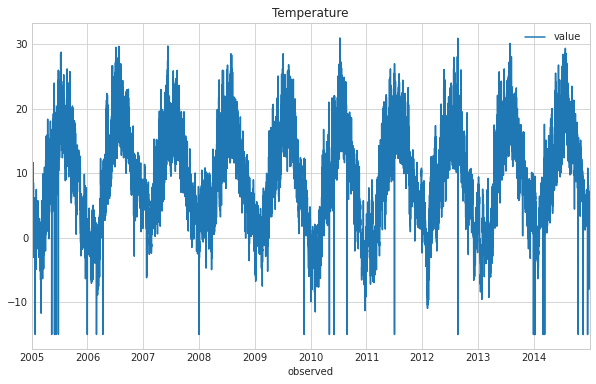

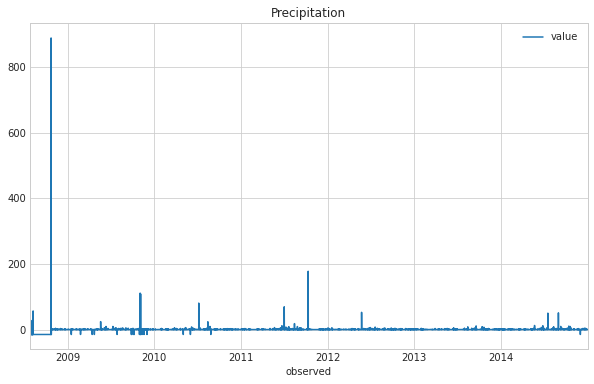

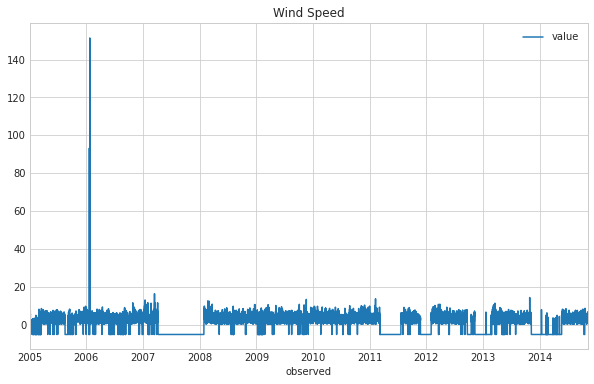

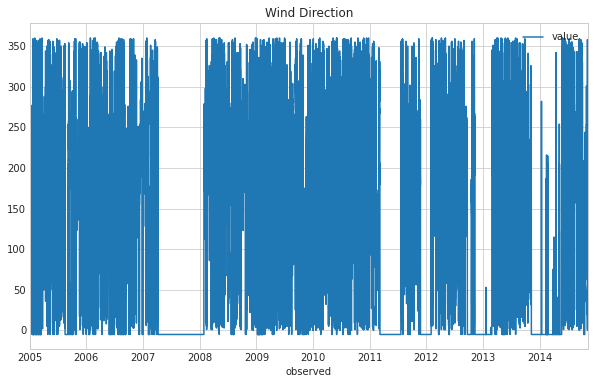

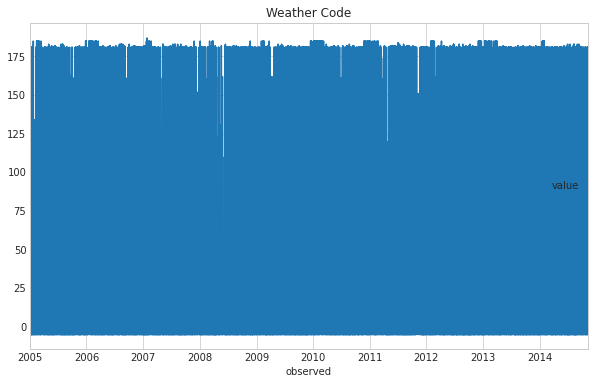

In [ ]:
ax = df_t.fillna(-15).plot(title="Temperature",figsize=(10,6))
df_p.fillna(-15).plot(title="Precipitation",figsize=(10,6))
df_ws.fillna(-5).plot(title="Wind Speed",figsize=(10,6))
df_wd.fillna(-5).plot(title="Wind Direction",figsize=(10,6))
df_wc.fillna(-5).plot(title="Weather Code",figsize=(10,6))

When observing the above plots, a few things stick out:

- The temperature looks seasonal, as one would expect, and without many missing values
- Precipitation starts a bit before 2009 and has a massive spike, which corresponds to this [news-story](https://vejr.tv2.dk/skivejr/article.php/id-14569204.html) about rainfall in 2008.
- Wind speed and wind direction seem to be the most uninterrupted in 2009-2011.
- And the weather code is missing a lot of data.

From this we decided to look further into the period between 2009-2011, as that is when we have the most complete dataset. 

### 3.3.2 Handling missing values

We want to look at how many values are missing in the dataset and what are the characteristics of the data, which might help us decide whether to impute some of the dataset or discard the rows, where the values are missing.

#### Temperature

Starting with temperature, we look at the amount of missing values and zooming in on such an occurrance:

Temperature: 17 rows out of 26280 contains missing values (0.06%)


<AxesSubplot:title={'center':'Temperature'}, xlabel='observed'>

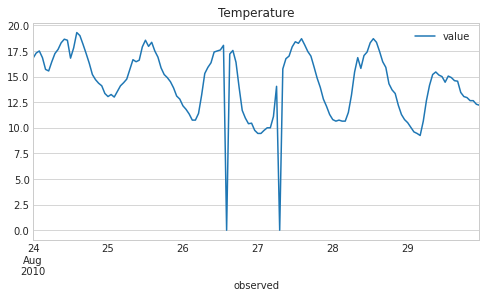

In [ ]:
def print_missing_rows(df, name =''):
    missing_values = len(df[np.any(df.iloc[:,:].isna().to_numpy(), axis=1)])
    data_set_size = len(df)
    print(f"{name}: {missing_values} rows out of {data_set_size} contains missing values ({round(missing_values/data_set_size*100, 2)}%)")

print_missing_rows(df_t['2009':'2011'], "Temperature")
df_t.loc["2010-08-24":"2010-08-29"].fillna(0).plot(title="Temperature",figsize=(8,4))

It can be seen that it is very few, single points that are missing from the dataset. Looking at the trends beside the missing values, it can be seen that imputing by linearly interpolating seems reasonable.

#### Precipitation
We discover the same for preciptation – we have a low amount of missing values and can linearly interpolate.

Precipitation: 117 rows out of 26280 contains missing values (0.45%)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



<AxesSubplot:title={'center':'Precipitation'}, xlabel='observed'>

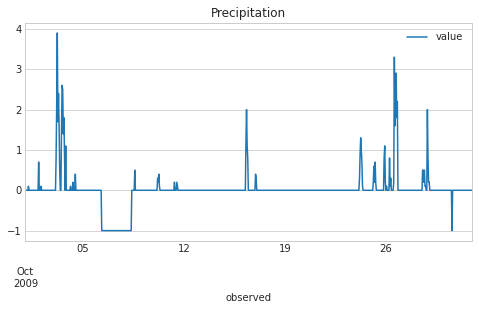

In [ ]:
print_missing_rows(df_p['2009':'2011'], "Precipitation")
df_p["2009-10"].fillna(-1).plot(title="Precipitation",figsize=(8,4))

#### Wind Speed and direction
With the wind speed an direction a large amont of points are missing, but zooming into a day with a lot of missing values, we can see that it is again reasonable to linearly interpolate, as the wind speed and direction doesn't change so abruptly.


Wind Speed: 4543 rows out of 26280 contains missing values (17.29%)
Wind Direction: 4543 rows out of 26280 contains missing values (17.29%)


<AxesSubplot:title={'center':'Wind Direction'}, xlabel='observed'>

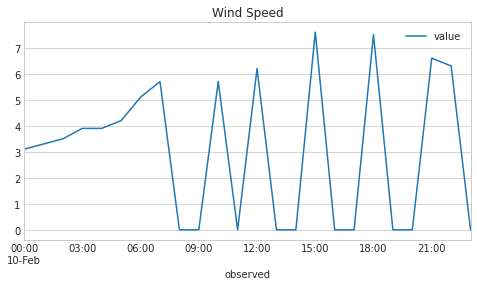

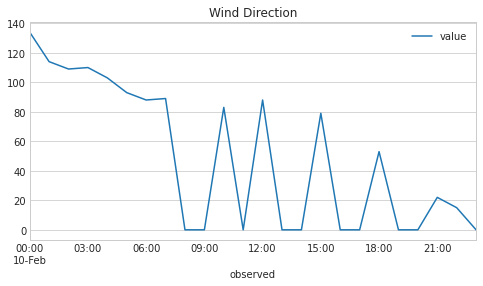

In [ ]:
print_missing_rows(df_ws['2009':'2011'],"Wind Speed")
print_missing_rows(df_wd['2009':'2011'],"Wind Direction")
df_ws.loc['2009-02-10'].fillna(0).plot(title="Wind Speed", figsize=(8,4))
df_wd.loc['2009-02-10'].fillna(0).plot(title="Wind Direction", figsize=(8,4))

This also makes sense when you think about it. Especially the wind direction would rarely undergo large change in direction.
#### Weather code

The weather code is even worse, with more than half the data points missing. We made the assumption that the most recent weather code is the active one until a new registration is made, but this could be completely wrong, so we won't do much further analysis on this.

Weather code: 14716 rows out of 26280 contains missing values (56.0%)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



<AxesSubplot:title={'center':'Weather Code'}, xlabel='observed'>

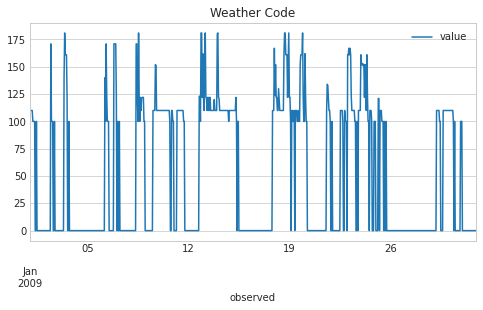

In [ ]:
print_missing_rows(df_wc['2009':'2011'],"Weather code")
df_wc["2009-01"].fillna(0).plot(title="Weather Code",figsize=(8,4))

#### Results of imputations
We impute the missing data as described above:

In [ ]:
df_t = df_t['2009':'2010'].interpolate()
df_p = df_p['2009':'2010'].interpolate()
df_ws = df_ws['2009':'2010'].interpolate()
df_wd = df_wd['2009':'2010'].interpolate()
df_wc = df_wc['2009':'2010'].fillna(method='ffill')

And see the fruits of our labor:

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



<AxesSubplot:title={'center':'Weather Code'}, xlabel='observed'>

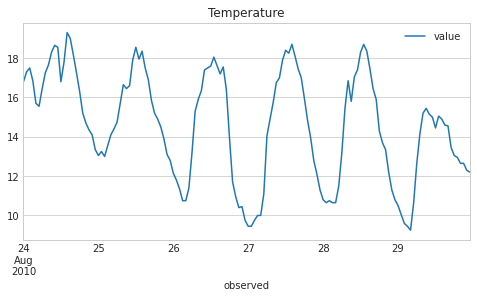

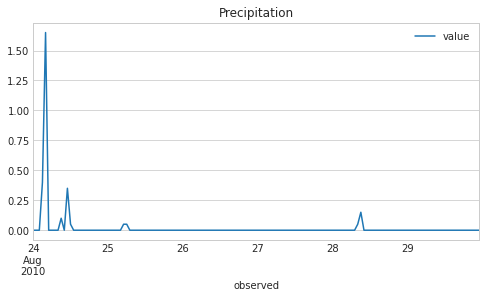

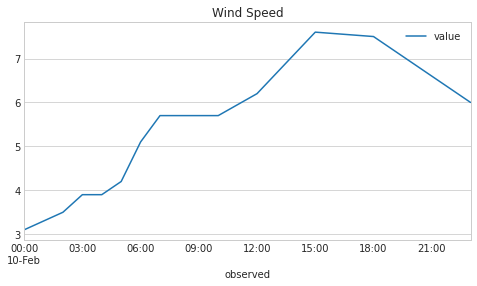

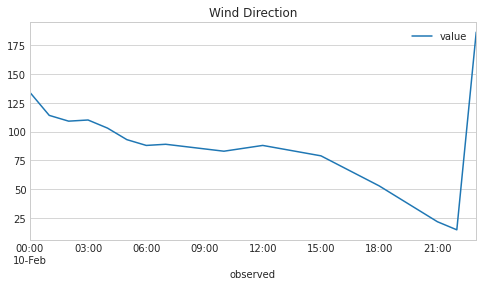

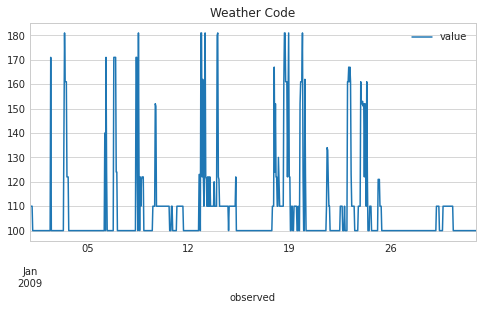

In [ ]:
df_t.loc["2010-08-24":"2010-08-29"].plot(title="Temperature",figsize=(8,4))
df_p["2010-08-24":"2010-08-29"].plot(title="Precipitation",figsize=(8,4))
df_ws.loc['2009-02-10'].plot(title="Wind Speed", figsize=(8,4))
df_wd.loc['2009-02-10'].plot(title="Wind Direction", figsize=(8,4))
df_wc["2009-01"].plot(title="Weather Code",figsize=(8,4))

Finally we concatenate all the individual features into one dataframe:

In [ ]:
df_weather_f = pd.concat([df_t,df_p,df_ws,df_wd,df_wc],axis=1)
df_weather_f.columns=["temperature", "precipitation", "wind_speed", "wind_direction","weather_code"] 
df_weather_f.head()

,temperature,precipitation,wind_speed,wind_direction,weather_code
observed,,,,,
2009-01-01 00:00:00,-0.30,0.0,2.0,248.0,110.0
2009-01-01 01:00:00,0.05,0.0,2.5,251.0,110.0
2009-01-01 02:00:00,0.10,0.0,2.5,267.0,110.0
2009-01-01 03:00:00,-0.40,0.0,1.8,289.0,110.0
2009-01-01 04:00:00,-0.70,0.0,2.0,288.0,110.0


#### Bike data

To analyse the weather data in conjunction with the bike data, we have to do a bit of pandas wrangling to get it in the correct format, so we can merge the two datasets:

In [ ]:
#Load bike data
df_bike = pd.read_csv("bike_data.csv", parse_dates=["Date"])
df_bike = df_bike[df_bike.notna()]

# Get total
df_bike_weather = df_bike[df_bike['RoadID'].str.contains('T')]
# Drop useless columns and set index
df_bike_weather = df_bike_weather.drop(columns=['RoadID','Lane', 'X', 'Y','Direction'])
df_bike_weather = df_bike_weather.set_index(['RoadName','Date'])

# Rename columns, to convert Date into datetime with correct hour
hour_columns = list(range(0,24))
df_bike_weather.columns = hour_columns
df_bike_weather = df_bike_weather.stack()
df_bike_weather = df_bike_weather.reset_index()
df_bike_weather.columns = ['RoadName','Date','Hour','Count']
df_bike_weather['Date'] +=  pd.to_timedelta(df_bike_weather.Hour, unit='h')
df_bike_weather = df_bike_weather.drop(columns=['Hour'])

#Pivot
df_bike_weather = pd.pivot(df_bike_weather,index='Date',values='Count',columns=['RoadName']) 
df_bike_weather.head()

RoadName,Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade),Ellebjergvej,Englandsvej,Fredensbro,Frederikssundsvej,Hareskovvej,Jagtvej,Kalvebod Brygge,Roskildevej,Torvegade,Tuborgvej,Vigerslev Allé,Åboulevard
Date,,,,,,,,,,,,,
2005-01-01 00:00:00,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
2005-01-01 01:00:00,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN
2005-01-01 02:00:00,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN
2005-01-01 03:00:00,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN
2005-01-01 04:00:00,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN


Looking at the amount of rows missing on the various roads, two are especially complete for the timeframe 2009-01-01 until 2010-12-31. We are looking at *Tuborgvej* and *Åboulevard*.

In [ ]:
df_bike_weather['2009':'2010'].isnull().sum(axis=0)

RoadName
Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)     8198
Ellebjergvej                                                 8843
Englandsvej                                                 17517
Fredensbro                                                   4450
Frederikssundsvej                                            3319
Hareskovvej                                                  5852
Jagtvej                                                       169
Kalvebod Brygge                                              7806
Roskildevej                                                  8759
Torvegade                                                    6072
Tuborgvej                                                     572
Vigerslev Allé                                               3666
Åboulevard                                                    181
dtype: int64

We will thus use these two roads as the basis for our weather analysis. As can be seen in 3.1.4 the two roads have about the same number of daily cyclists and have a large enough amount of cyclists to be representative for the dataset as a whole. We then merge with the weather data and drop the rows with missing values:

In [ ]:
# Select timeframe and roads
df_bike_weather = df_bike_weather['2009':'2010']
df_bike_weather = df_bike_weather.loc[:,['Åboulevard','Jagtvej']]

# Merge weather and bicycle data
df_bike_weather = pd.merge(df_weather_f,df_bike_weather,how="inner",left_index=True,right_index=True)
df_bike_weather = df_bike_weather.dropna()

### 3.3.3 Impact of temperature

Using these two roads and the polished weather data from 2009 and 2010, we want to see if temperature can have an impact on the average amount of cyclists. As we saw in section 3.1.3, there does seem to be a seasonal trend, of which temperature is correlated, so this seems likely to be the case.

We look at the same timeframe for each day 8:00-9:00, to cancel out the hourly variance and create a 'total' column for the combined count of the two roads:

In [ ]:
df_8am = df_bike_weather.between_time('8:00','8:59')

df_temp = df_8am.loc[:,['temperature']]
df_temp['total'] = df_8am['Jagtvej'] + df_8am['Åboulevard']

We divide the data into similarly sized bins using qcut, which removes possible variance:

In [ ]:
pd.qcut(df_temp['temperature'], q=6)

2009-01-01 08:00:00    (-8.950999999999999, 0.167]
2009-01-02 08:00:00    (-8.950999999999999, 0.167]
2009-01-03 08:00:00                 (0.167, 5.333]
2009-01-04 08:00:00    (-8.950999999999999, 0.167]
2009-01-05 08:00:00    (-8.950999999999999, 0.167]
                                  ...             
2010-12-27 08:00:00    (-8.950999999999999, 0.167]
2010-12-28 08:00:00    (-8.950999999999999, 0.167]
2010-12-29 08:00:00    (-8.950999999999999, 0.167]
2010-12-30 08:00:00    (-8.950999999999999, 0.167]
2010-12-31 08:00:00    (-8.950999999999999, 0.167]
Name: temperature, Length: 723, dtype: category
Categories (6, interval[float64]): [(-8.950999999999999, 0.167] < (0.167, 5.333] < (5.333, 9.5] < (9.5, 13.6] < (13.6, 17.983] < (17.983, 26.85]]

We group on each of the bins and take the mean, which yields the following plot:

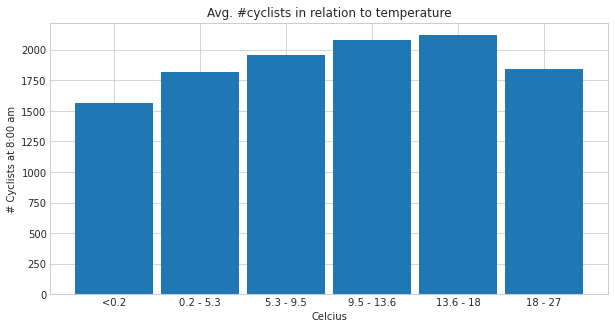

In [ ]:
temp_intervals = df_temp.total.groupby(pd.qcut(df_temp['temperature'], q=6,labels=['<0.2','0.2 - 5.3','5.3 - 9.5', '9.5 - 13.6', '13.6 - 18', '18 - 27']))
#temp_intervals = df_temp.total.groupby(pd.cut(df_temp['temperature'], [-10,0,5,10,15,20,30]))
t_mean = temp_intervals.agg('mean')

plt.figure(figsize=(10,5))
plt.title("Avg. #cyclists in relation to temperature")
plt.ylabel("# Cyclists at 8:00 am")
plt.xlabel("Celcius")
plt.bar(x=t_mean.index,height=t_mean, width=0.9)
plt.show()
print("Pearson:" + str(pearsonr(df_temp['temperature'],df_temp['total'])))


As expected, we have a trend that follows the seasonality from 3.13, however it is interesting to note that the bin with the highest temperatures has a drop in average cyclists compared to a milder temperature. This could be due to Copenhageners preferring that temperature-range, or it could be that in the summer months, when the temperature is at its highest, more people are on vacation and thus not bicycling around Copenhagen.

Looking at the output below the plot, which is the Pearson correlation coefficient and p-value for testing non-correlation, we can see that there is a very slight correlation that is significant.

### 3.3.4 Impact of precipitation

Looking at percipitation, we do something similar, but without qcut this time, as there aren't enough measurements for precipitation that are above 0 to create equally sized bins. We then chose to specify some bins ourselves:

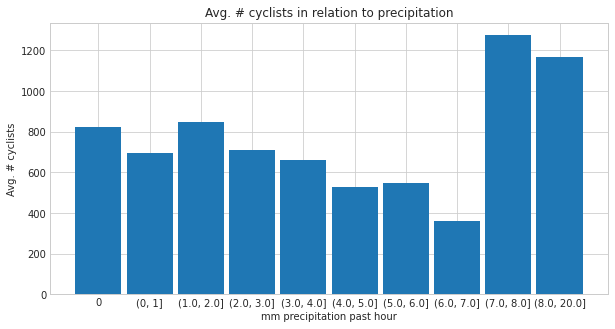

Pearson: (-0.007504555605976222, 0.32313339259853974)


In [ ]:
# Gather data – all times instead of just 8:00-9:00 and calcualte mean of bins
df_precip = df_bike_weather.loc[:,['precipitation']]
df_precip['total'] = df_bike_weather['Jagtvej'] + df_bike_weather['Åboulevard']
precip_intervals = df_precip.total.groupby(pd.cut(df_precip['precipitation'], [-0.01,0.0001,1, 2, 3, 4, 5, 6, 7, 8, 20]))
p_mean = precip_intervals.agg('mean')

# Plot
plt.figure(figsize=(10,5))
plt.title("Avg. # cyclists in relation to precipitation")
plt.ylabel("Avg. # cyclists")
plt.xlabel("mm precipitation past hour")

# Adjust index to string
str_indices = [str(ind) for ind in p_mean.index]
str_indices[0] = "0"
str_indices[1] = "(0, 1]"

plt.bar(x=str_indices,height=p_mean.values, width=0.9)
plt.show()

# Pearson?
from scipy.stats import pearsonr
print("Pearson: " + str(pearsonr(df_precip['precipitation'],df_precip['total'])))

This is not a trend one would expect. The first 8 bins follow a trend that confirms our bias that people are less likely to chose a bicycle, if it is raining, but the last couple see the biggest amount of average cyclists. The Pearson test also shows that there is not a statistically signicant correlation, however this could be due to the fact that our data is not normally distributed.

Looking a bit closer at the amount of samples in each bin: 

In [ ]:
precip_intervals.size()

precipitation
(-0.01, 0.0001]    15503
(0.0001, 1.0]       1458
(1.0, 2.0]           242
(2.0, 3.0]            72
(3.0, 4.0]            26
(4.0, 5.0]             8
(5.0, 6.0]            10
(6.0, 7.0]             3
(7.0, 8.0]             2
(8.0, 20.0]            6
Name: total, dtype: int64

In [ ]:
df_precip[df_precip['precipitation'] > 8]

,precipitation,total
2009-05-20 01:00:00,24.20,86.0
2009-06-11 20:00:00,9.40,755.0
2009-07-10 17:00:00,9.50,2108.0
2009-11-02 13:00:00,111.10,672.0
2009-11-02 14:00:00,55.65,808.0
2009-11-04 12:00:00,108.70,781.0
2010-07-07 11:00:00,80.65,855.0
2010-08-14 16:00:00,12.00,744.0
2010-08-14 17:00:00,14.20,798.0
2010-08-14 18:00:00,14.75,502.0


We can see that there are very few samples in the last bins compared to the first which has more than 90% of the samples! In general it seems to be a disproportionally low amount of rain in the Copenhagen area compared to common knowledge, which might suggest an error in the data from DMI or in our processing. If we assume the data is sound, then explanations for this could be:

- It has only rained that much on weekdays, where people are more inclined to bicycle.
- Looking at the times with more than 8 mm of rain, it can be seen that the samples with a high 'total' are in the summer months, which could mean that they got hit by a flash flood or were a part of an event that day.

Ideally we would have more samples, because the rest of the plot hints at there being a signal that says: More rain => less cyclists.

### 3.3.5 Does tailwind make more people bicycle?

And finally, we will look into the man, the myth, the legend – [Jakob Haugaard](https://www.dr.dk/nyheder/regionale/oestjylland/medvind-paa-cykelstierne-og-stoerre-julegaver-til-alle-i-dag-er-det-25)

He is a famous Danish comedian, who at a national election 25+ years ago promised, among other things, 'medvind på cykelstierne' or 'tailwind on the bike-lanes' as an election promise – and got elected!

Even though that is a bit of a tall campaign order to fill (spoiler alert: he didn't succeed) – does tailwind actually play a role in peoples bicycle patterns?

To investigate this we selected on the roads we have been working with – Jagtvej – and looked at its direction. When going in the '+' direction on Jagtvej one is bicycling at a 30 degree angle – so the opposite direction is 210 degrees. We start by getting the numbers for the '+' direction for Jagtvej:

In [ ]:
# Select + direction and Jagtvej
df_bike_wind = df_bike[df_bike['Direction'] == '+']
df_bike_wind = df_bike_wind[df_bike_wind['RoadName'] == 'Jagtvej']

# Drop useless columns
df_bike_wind = df_bike_wind.drop(columns=['RoadID','Lane', 'X', 'Y','Direction'])
df_bike_wind = df_bike_wind.set_index(['RoadName','Date'])

# Rename columns to hour and reshape frame to correct format
hour_columns = list(range(0,24))
df_bike_wind.columns = hour_columns
df_bike_wind = df_bike_wind.stack()
df_bike_wind = df_bike_wind.reset_index()
df_bike_wind.columns = ['RoadName','Date','Hour','Count']
df_bike_wind['Date'] +=  pd.to_timedelta(df_bike_wind.Hour, unit='h')
df_bike_wind = df_bike_wind.drop(columns=['Hour'])
df_bike_wind = pd.pivot(df_bike_wind,index='Date',values='Count',columns=['RoadName']) 

# Merge with wind data
df_bike_wind = pd.merge(df_weather_f.loc[:,['wind_direction','wind_speed']],df_bike_wind,how="inner",left_index=True,right_index=True)

We specify the direction and create a mask for wind that comes from the north (headwind) and the south (tailwind) with a 30 degree margin to either side.

In [ ]:
north_dir = 30
south_dir = 210

north_mask = (df_bike_wind['wind_direction'] <= (north_dir + 30)) & (df_bike_wind['wind_direction'] >= (north_dir - 30))
south_mask = ((df_bike_wind['wind_direction'] <= (south_dir + 30)) & (df_bike_wind['wind_direction'] >= (south_dir - 30)))

df_bike_wind_n = df_bike_wind[north_mask]
df_bike_wind_s = df_bike_wind[south_mask]

We start by looking at the headwind. Grouping by quantiles as before and then getting the mean for each wind interval: 

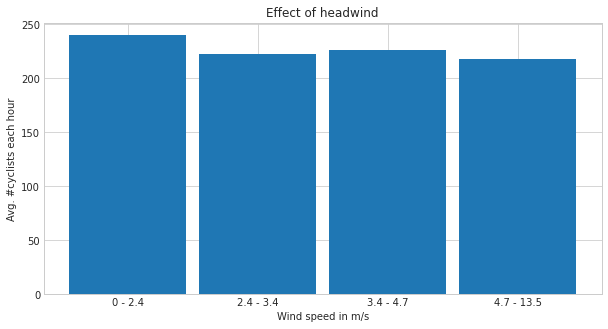

In [ ]:
wind_intervals = df_bike_wind_n.Jagtvej.groupby(pd.qcut(df_bike_wind_n['wind_speed'], q=4, labels=['0 - 2.4', '2.4 - 3.4', '3.4 - 4.7', '4.7 - 13.5']))
ws_mean = wind_intervals.agg('mean')
plt.figure(figsize=(10,5))
plt.title("Effect of headwind")
plt.ylabel("Avg. #cyclists each hour")
plt.xlabel("Wind speed in m/s")
plt.bar(x=ws_mean.index,height=ws_mean, width=0.9)
plt.show()

It looks as though a headwind has a slight downwards trend, so that fewer people on average bicycle the more headwind they have on Jagtvej.

The question is if they actually take this into account – or maybe they decide while cycling up Jagtvej in headwind to choose an alternative route.

Looking into the promised land - tailwind – we do the same as before and plot the resulting averages for the quantile bins:

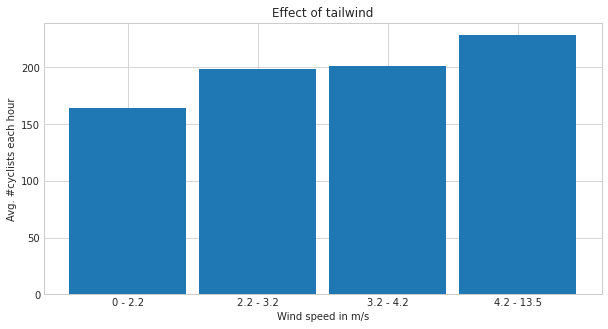

In [ ]:
wind_intervals = df_bike_wind_s.Jagtvej.groupby(pd.qcut(df_bike_wind_s['wind_speed'], q=4,  labels=['0 - 2.2', '2.2 - 3.2', '3.2 - 4.2', '4.2 - 13.5']))
ws_mean = wind_intervals.agg('mean')
plt.figure(figsize=(10,5))
plt.title("Effect of tailwind")
plt.ylabel("Avg. #cyclists each hour")
plt.xlabel("Wind speed in m/s")
plt.bar(x=ws_mean.index,height=ws_mean, width=0.9)
plt.show()

It seems that not only does promising tailwind win you elections, it apparantly has an effect on the amount of people bicycling north on Jagtvej!

## 3.4. Predictive model using weather data

In this section we want to predict the number of bicyclists between 8:00 am and 9:00 am each morning on the two roads that we've been working with – Jagtvej and Åboulevard. By using the weather data along with temporal information, we can hopefully gain a deeper understanding as to what, if any, role the weather plays in peoples bicycle patterns.

The models we have chosen to test out on the data set are:

- Random Forest
- Elastic Net
- Artificial Neural Network

### 3.4.1 Preparing the data
To prepare the data for training a model, we start by calculating the total amount of bicyclists on the two roads. We further assign a boolean to each row that indicates whether it is the weekend or not. We chose to drop the weather_code, as it doesn't seem to improve the models' performance, but keep the rest of the weather features – temperature, precipitation, wind speed and direction.

Finally we split the data in to training and test sets – keeping 10% of the data unseen during training to make the models' performance representative.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Calculate total?
df_8am['total'] = df_8am['Åboulevard'] + df_8am['Jagtvej']

# Is weekend?
df_8am = df_8am.assign(is_weekend=0)
df_8am.loc[df_8am.index.dayofweek >= 5, 'is_weekend'] = 1
# Drop useless columns
X = df_8am.drop(columns=['Åboulevard','Jagtvej','total','weather_code'])
#X = pd.get_dummies(X, columns=["weather_code"])
y = df_8am['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



As a baseline for comparing our models, we calculate the root mean-squared error on predicting the mean for the whole dataset:

In [ ]:
print("RMSE", np.sqrt(np.mean((y_test - np.mean(y_test))**2)))

RMSE 1255.7781002839545


### 3.4.2. Predicting with: *Random Forest*

Starting out with Random Forest, we need to choose the configuration parameters for the Random Forest model. When working with Random Forest, we can tweak various parameters, which can impact the performance of the model. We will focus on:

- ``max_depth`` controls the maximum depth of each tree in the forest. Deep trees introduce low bias and high variance.
- ``max_features``, controls the maximum number of features sampled, i.e. the number of features to consider in each split. Trees with many features introduce low bias and high variance.
- ``n_estimators`` the number of trees in the forest. Increasing the number of trees will lower the variance.

To find a set of parameters we can use, we do a. grid-search and estimate which configuration is best using cross-validation. By doing this, we can test all the various configurations on the model on small unseen test sets, which are not used to train the model, and reduce the variance of our estimate:

In [ ]:
from sklearn.metrics import mean_squared_error, make_scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

clf = RandomForestRegressor()

param_grid = {
    'n_estimators': [20,30,40,50,60],
    'max_depth': [2,3,5,10],
    'max_features': [1,2,3,4,5]
}

rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, scoring=rmse_scorer, verbose=2, n_jobs=-1)

# Fit the grid search model
rf_grid.fit(X_train, y_train)

print("Best model performance:")
print("# Estimators: ", rf_grid.best_estimator_.get_params()['n_estimators'])
print("Max Depth: ", rf_grid.best_estimator_.get_params()['max_depth'])
print("Max features: ", rf_grid.best_estimator_.get_params()['max_features'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best model performance:
# Estimators:  40
Max Depth:  3
Max features:  3


Normally random forests don't mind increasing the amount of estimators to reduce the variance, but in this case only 40 estimators are preferred.

The other two hyperparameters are plotted below:

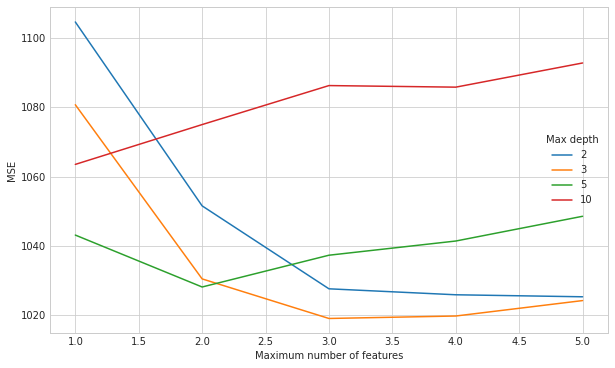

In [ ]:
df_rf = pd.DataFrame(rf_grid.cv_results_)
n_estimators = 40
df_rf = df_rf[df_rf['param_n_estimators']==n_estimators]
df_rf['mean_test_score'] = df_rf['mean_test_score'].mul(-1)

import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
_ = sns.lineplot(data=df_rf, x='param_max_features', y='mean_test_score', hue='param_max_depth', palette=sns.color_palette()[:4], ax=ax)
ax.set_xlabel('Maximum number of features')
ax.set_ylabel('MSE')
ax.legend(title='Max depth')


plt.show()

Calculating the root mean squared error yields a result that is marginally better than guessing the mean, but nothing extraordinary.

In [ ]:
print("RMSE", np.sqrt(np.mean((y_test - rf_grid.best_estimator_.predict(X_test))**2)))


RMSE 1131.3789327774077


### 3.4.3. Predicting with: *Elastic Net*
The next model we experimented with was elastic nets, which combine sparsity (i.e. number of features) and shrinkage (*how much* we let each feature matter), also known as the $L_1$ and $L_2$-norm respectively. Hence the loss which we are minimizing looks like this:

$$\min_{\beta} \frac{1}{2n}||Y-X\beta||^2_2 + \lambda(\frac{1}{2}(1-\alpha)||\beta||^2_2+\alpha||\beta||_1)$$

where $\beta$ are the model parameters (how much we weight each feature), $n$ the number of data points, $\lambda$ the regularization strength, $X$ the data, $y$ the response and $\alpha$ a trade-off between the $L_1$ and $L_2$-norm. 

The motivation behind testing this type of models comes from a couple of observations. First of all, we don't have an enourmous amount of data. The elastic model is also known as a sparse regression model, which is good at handling a few number of observations. Next, if any features are correlated, the model handles this through sparsity (the $L_1$ loss). And finally, we have experience with linear models performing well in regression problems. So if these observations are crucial, we believe that the elastic net could perform well. Below, we fit the model to the training data:

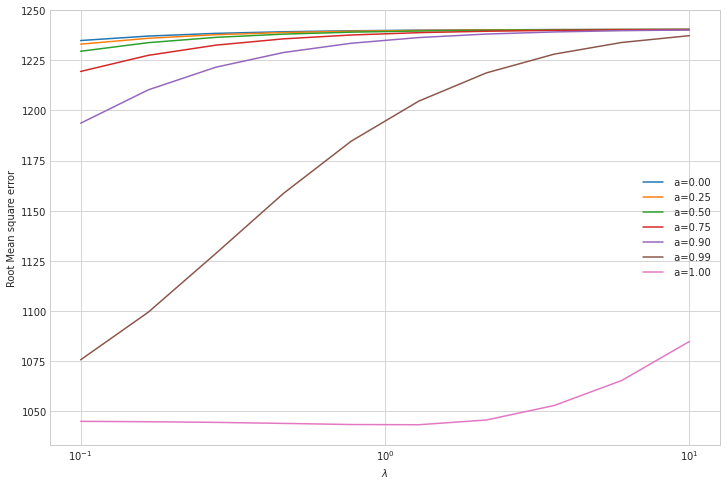

In [ ]:
from sklearn.metrics import mean_squared_error, make_scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False) # Det er også ok at have en lille en <3
from sklearn.model_selection import KFold


lambdas = np.logspace(-1, 1, num=10)
alphas = [0, .25, .5, .75, .9, 0.99, 1] # np.linspace(0.75, 1, num=10)


plt.figure(figsize=(12,8))

for alpha in alphas:

	# configure the cross-validation procedure
	n_splits = 10
	cv_outer = KFold(n_splits=n_splits, shuffle=True, random_state=1)

	# enumerate splits
	results = np.zeros((n_splits, len(lambdas)))
	models = []

	for i, (train_ix, test_ix) in enumerate(cv_outer.split(X)):
		
		# split data
		X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
		y_train, y_test = y[train_ix], y[test_ix]
		
		# define the models, search spaces and execute search
		with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
			warnings.simplefilter("ignore")
			

			# Train elastic net:
			for j, _lambda in enumerate(lambdas):
				model = linear_model.ElasticNet(alpha=_lambda, l1_ratio=alpha, normalize=True)
				model.fit(X_train, y_train)
				y_hat = model.predict(X_test)
				mse = mean_squared_error(y_test, y_hat)
				results[i, j] = mse
				if i==0:
					models.append(model)



	rmse_pr_lambda = np.sqrt(np.mean(results, axis=0))

	plt.semilogx(lambdas, rmse_pr_lambda, label=' a=%.2f' % alpha)


plt.xlabel(r'$\lambda$')
plt.ylabel('Root Mean square error')
plt.legend()
plt.show()

In [ ]:
best_model_ind = np.argmin(rmse_pr_lambda)
best_model = models[best_model_ind]

print("Optimal lambda: ", best_model.alpha)
print("Optimal alpha: ", best_model.l1_ratio)
opt_lambda = best_model.alpha
opt_alpha = best_model.l1_ratio

Optimal lambda:  1.291549665014884
Optimal alpha:  1


We can observe that the model performs the best for $\alpha=1$ - i.e (only the $L_1$ loss), which means that we focus more on deleting unimportant features rather than minimizing their magnitude (and thus importance). This suggest that some of the features are insignificant for the model's performance. Also, note that the model performs the best with a regularization strength of $\alpha=1.29$. The final performance of the model on the test set is then:

In [ ]:
print("RMSE", np.sqrt(np.mean((y_test - best_model.predict(X_test))**2)))

RMSE 1161.6170316083142


So for this model we see that we on average predict 1161 bicyclists too few or too many, which is slightly better than the baseline model. So the model has learned something!

### 3.4.4. Predicting with: *Neural Network*

The final model we tested was a neural network. This model was also included in the comparison, as it is a very flexible model which can fit highly complex patterns in the data - for example, if some of the features are non-linear, we would have to transform these in order to make them fit the elastic net. The challenge with neural networks are the combination of long trainings as well as the many configuration of hyper-parameters we need to test and optimize for.

Below we've defined the final neural network which we found performed the best. First of all, we found that three layers with 1024, 1024 and 512 hidden units (which controls the number of fitted parameters to the data) added significant complexity to pick up on the patterns in the data. For activation function we found that the ReLU worked the best. Moreover, in the initial tests, the network suffered a lot from overfitting to the data. Therefore we introduced different regularisations:

- L2 regularisation, similar to what was mentioned in the previous section about *Elastic Net*.
- Then we also used batch normalization layers placed after every activation, in order to normalize the input for each layer over a batch of samples. This helps our network to converge a lot faster as it addresses the problem of each layer’s input distribution changing over time, as the parameters of previous layers changes. Using batches in training also regularizes, as specific training samples no longer produce deterministic values. \[loffe and Szegedy, 2015\]
- Finally, we also used dropout, which randomly drops a certain rate of units and their connections for a single training step. This regularizes our network by forcing each hidden unit to work together with a randomly chosen set of other units, encouraging it to learn useful features on its own \[Srivastava et. al. 2014\].


The specific details of the network and the final training can be inspected below:


In [ ]:
#Creating base neural network
import keras
from keras import layers
from keras.regularizers import l2



dropout_rate1 = 0.2
dropout_rate2 = 0.5
l2_reg = 0.00001

epochs = 1000
lr = 0.0002
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=10000,
    decay_rate=0.9)

factor = 1

model = keras.Sequential([

    layers.Dense(factor*1024, activation='relu', kernel_regularizer=l2(l2_reg)),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate1),


    layers.Dense(factor*1024, activation='relu', kernel_regularizer=l2(l2_reg)),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate1),


    layers.Dense(factor*512, activation='relu', kernel_regularizer=l2(l2_reg)),
    layers.BatchNormalization(),


    layers.Dense(1, kernel_initializer='normal'),
])



from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#Compiling the model
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="mean_squared_error",
              optimizer=opt, metrics=rmse)

#Fitting the model
checkpoint = keras.callbacks.ModelCheckpoint('models/model{epoch:03d}.h5', period=1) 
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])




21/21 [==============================] - 1s 29ms/step - loss: 838911.6619 - rmse: 716.3261 - val_loss: 1460444.5000 - val_rmse: 975.8778
Epoch 502/1000
21/21 [==============================] - 1s 29ms/step - loss: 825762.0142 - rmse: 707.1622 - val_loss: 1579169.1250 - val_rmse: 1014.9410
Epoch 503/1000
21/21 [==============================] - 1s 29ms/step - loss: 860610.6676 - rmse: 715.0471 - val_loss: 1539156.7500 - val_rmse: 999.6584
Epoch 504/1000
21/21 [==============================] - 1s 29ms/step - loss: 898406.2159 - rmse: 732.1968 - val_loss: 1580951.0000 - val_rmse: 998.6484
Epoch 505/1000
21/21 [==============================] - 1s 29ms/step - loss: 824760.8693 - rmse: 703.8764 - val_loss: 1520559.2500 - val_rmse: 979.6353
Epoch 506/1000
21/21 [==============================] - 1s 29ms/step - loss: 915124.7017 - rmse: 732.3250 - val_loss: 1457429.6250 - val_rmse: 945.7456
Epoch 507/1000
21/21 [==============================] - 1s 28ms/step - loss: 774739.7443 - rmse: 672.4

To better comprehend how the training developed, we plot the rmse over time below:

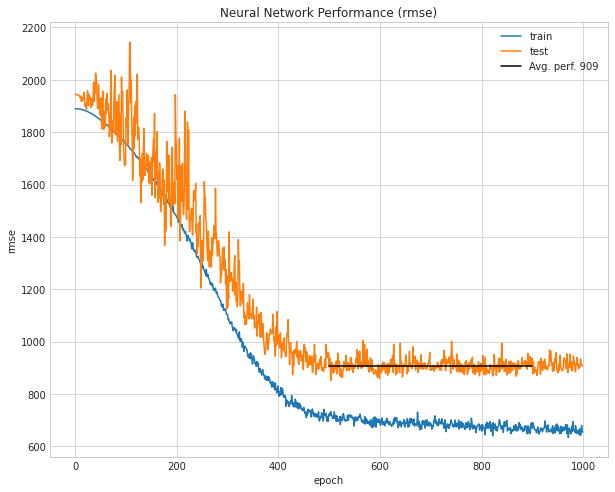

Best performing configuration: 851.7171020507812
Average performance in converged region: 908.840399017334


In [ ]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Neural Network Performance (rmse)')
plt.ylabel('rmse')
plt.xlabel('epoch')
i1 = 500
i2 = 900
min_rmse = np.mean(history.history['val_rmse'][i1:i2])
plt.plot([i1, i2], [min_rmse, min_rmse], color="black")
plt.legend(['train', 'test', "Avg. perf. " + str(round(min_rmse))], loc='upper right')
plt.show()

print("Best performing configuration: " + str(min(history.history['val_rmse'][i1:i2])))
print("Average performance in converged region: " + str(np.mean(history.history['val_rmse'][i1:i2])))

We see that after training for about 4-500 epochs, the network converged - i.e. the optimization algorithm settled into some region of parameters, which it found optimal to solve the problem. We see that the network converges at a rmse around 900, which seems better than both the elastic net and random forest model. However, it should be mentioned that this might partly be a result of overfitting to the validation data, whereas you ideally would keep a separate validation and test set. Nevertheless, we are not very interested in estimating how accurately we can predict the number of cyclists at 08:00, but rather find out which features a good model finds significant to model this problem. 

Enter, *permutation importance*


### 3.4.5. Significant features with permutation importance
As the final part of our analysis, we want to examine if the weather data helped the models predict the number of bicyclists on the roads at 08:00. If so, that would highly suggest that the weather does have an impact on the danes' bicycle patterns. In order to determine this, we will use *permutation importance*.

The concept is actually rather simple, which works by shuffling a single feature, and then feed all the test data to the model and compute how much the rmse deviated. By doing this 10 times, we can compute how much this feature on average impacted the performance. The results are shown below for the model at epoch 700:

In [ ]:
best_perf_model_ind = 700
saved_model = keras.models.load_model('models/model' + str(best_perf_model_ind) + '.h5', custom_objects={'rmse': rmse})

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(saved_model, scoring="neg_root_mean_squared_error",random_state=20, n_iter=10).fit(X_test,y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
338.2982 ± 107.7721,is_weekend
129.2497 ± 75.8687,temperature
21.7740 ± 50.7226,wind_speed
10.4598 ± 91.8341,wind_direction
6.2796 ± 14.9017,precipitation


The results above show that if we randomly shuffle the `ìs_weekend` feature, we on average guessed more inaccurate with 338 cyclists, with a standard deviation of 107. And similarly, we actually see that all the weather features had an impact on the performance too. However, we can only conclude that ``temperature`` is of signifiance, as the results of shuffling ``wind_speed``, ``wind_direction`` and ``precipitation`` all had too high variance. 

We found it a bit suprising that precipitation did not seem to have more impact, as you might expect people to leave the bike at home when it's raining. Some of the explanation might also origin from the relatively few days with rain in the data, which might make it more challenging for the model to pick up on any signal. In future work, we could try to oversample these days to see wheather it helped the model find any patterns. But maybe this just suggests that there is still a large portion of viking left in the danes - not even rain can keep danes from bicycling!

Regarding the significant features, we already had an idea that the weekend influenced how many bicycled at 08:00 from what we saw in section *3.1.2. Weekly patterns*. More interestingly, it appears that the temperature truly helps the model predict how many people bicycles in the morning! Therefore, we can conclude that the results strongly imply that weather does have an impact.


# 4. Genre

Choosing the appropriate genre depends on a variety of factors, including the complexity of the data, the complexity of the story, the intended audience and the intended medium \[Segel, E., & Heer, J\].

In *Narrative visualisation: Telling stories with data*, authors Segel and Heer analyse the design of narrative visualisations, how graphical techniques and interactivity can enforce various levels of structure and narrative flow. The authors then categorise storytelling techniques into *seven genres of narrative visualisation*: magazine style, annotated chart, partitioned poster, flow chart, comic strip, slide show, and film/video/animation. 
![Seven Genres](genres.png)
These genres can be combined with interactivity and messaging to produce varying balances of author-driven and reader-driven experiences. **Author-driven** content uses linear ordering of scenes and has no (or very limited) interactivity. **Reader-driven** content on the other hand does not have a prescribed order and has a high level of interactivity with the reader through data graphics.

The most fitting genre for accurately communicating the story in this project and present the findings, was thought to be an author-driven, magazine-style blog post, with additional interactivity and messaging elements - using some elements from *the interactive slideshow* mentioned in the paper. This combined genre is optimal as we want to communicate several scientific results, but at the same time avoid the story to become too text-heavy. 

**Visual Narrative**
- Visual structuring: Consistent Visual Platform
- Highlights: Feature distinction
- Transition guidance: Familiar Objects, Animated Transitions

In figure 7, Segel and Heer also present a design space analysis of narrative visualisation. Form the presented tools, in regard to the Visual narrative, we were really focused on keeping a consistent visual platform, with Feature distinction for highlighting the parts where it was considered necessary. For example, although the whole layout of the webpage is a single column text, switching from left to right and back, in the section where we present the interactive folium plots, we decided to set the visualizations to autoplay, in order to draw the reader's attention and identify that there is some interactivity these parts. Additionally, we added buttons under the folium plots, which open the map into a new browser tab for a full-screen view and better zooming to the points of interest. *Transitioning* is a very important tool when telling a story. Changing from one part to the next, while maintaining the viewer’s attention and consequently increase the overall *memorability* of the narrative \[Bateman, S.\]. To achieve this, our focus was on switching smoothly between the different sections, where what is written in one part would lead to the next, thus keeping its linear structure. We used Familiar objects and small Animated transitions while scrolling to maintain the readers attention during the transitions.

**Narrative Structure**
- Ordering: Linear
- Interactivity: Filtering / Selection / Search, Stimulating Default Views
- Messaging: Introductory text, Captions / Headlines, Annotations, Summary / Synthesis
 
For the Narrative structure, linear ordering was thought to be the optimal choice, as a lot of information had to be communicated in text. Therefore, we assesed that an easy guiding of the reader would remove all potential confusions regarding where to look next, so that the reader's capacity was primarily spent on understanding the content. As touched upon above we chose a zig-zag layout to give this magazine style feeling and appealing look. For the interactive plots, interactivity switches between Filtering / Selection / Search and Stimulating Default views. In the Folium map we use a play button to animate the plot automatically, an option to adjust the fps for more convenient viewing and a scrolling bar for manually focusing on the specific points. 
Messaging is the use of text in order to provide observations and explanations about what is being presented, while interactivity gives the ability to the reader to manipulate the visualisations and focus on specific data of interest. The visualisations and respective interactivity were carefully chosen with the purpose of engaging the audience and enhance story discovery, but not detract from the main presented story. We started with an introductory text and the motivation, then used captions / headlines for each section and summaries before or after the plots to present the findings and the points of interest. Thereby, the reader will both be met with appealing and informative visualisations, while the captions / headlines will guide them through the story and help them with the broader perspective.



# 5. Visualizations

Various visualizations have been chosen for best communicating our story. For the first part we present a scatter plot with the locations where the data for the main dataset were gathered from through the years. On the x-axis we have the years and on the y-axis the name of the various locations. If there is a measurement for that location in a specific year, then a blue dot is shown. This way it is easy for the viewer to quickly spot the gaps in the data with a glance, by seeing the missing dots. This is ideal in our case because of the number of measuring locations. Had the number been larger, we might have considered a different visualization, as too many dots could be difficult to comprehend.

![Scatter Locations](img/locations.png)

In the hourly patterns section, we present a bar plot to present the average number of bicycles per hour. We decided to use the interactivity that Bokeh offers, as we also wanted to show the direction of the cyclists and compare it to each other and the total. By checking the respective boxes the user can switch between the views and easily make comparisons. In this case, the Bokeh plots is very suitable as we only want to show a few different options to emphasize our point. As opposed to this when there are many options at once, the plot might suffer from being too messy and cumbersome to switch between different options.

![Bokeh](img/bokeh.png)

We continued with an interactive Folium map where we take the dominating cyclists’ direction for all our measuring locations over time. Folium as a tool is ideal for showing geospatial data such as our measuring locations, while giving the viewer a good understanding of the area we are investigating. 
By dragging the slider, the user gets to see the changes on the interactive map, in the form of colored circles. The size of the circle shows how much more the traffic is directed in one direction over the other, while the colors blue and red show whether they are going towards or away from the city center respectively. Note how this visualization offers very detailed information while still appearing relatively simple! At a quick glance, you can get an impression from the colors alone on where the traffick is headed at the given hour. And to support this impression, the size of the bubbles contributes to the impression of the direction. For example, if you see a lot of red, you know that a lot of traffick is headed towards the center! And combining this with a map and plotting it a bubbles at the various locations, you *also* get a indication of the local traffick rather than the global pattern alone.

![Folium](img/folium.png)

For the weekly patterns we used a static bar plot showing the number of cyclists per hour for every day of the week. Here we exploited using different colors in order to easily distinguish the night hours (in red) from the daily hours (blue). Then with just a single plot we can emphasize several patterns at once:

- The overall pattern when comparing both the red and blue bars - how the countings develop through the week.
- The patterns during the night hours of each day. By only focusing on the red bars you can easily see that the weekends have higher red bars than the weekdays.
- And finally the daily patterns, where it is easy to see from the blue bars that weekends are way less intensified on rush hours.

![Weekly barplot](img/weekly-1.png)

In the next part, when we looked into the number of bikers passing from each location, from the beginning of Friday to Saturday's early morning hours, we used the same concept using the folium plot, as we did above. This time though, the circles are only red-colored and they show the magnitude of total traffic on each of the spots. The neat thing about this is that we can use a familiar visualizations to communicate completely different information. This time, the size of the circles can be used to compare the amount of traffic between locations!

![Weekly barplot](img/folium-2.png)

For the monthly patters we used a similar strategy as we did for the weekly ones, although in this case, we distributed the cyclists over the week numbers and the coloring represented the four seasons. First of all, the coloring makes it easy to distinguish between the four seasonalities - imagine how difficult it would be to observe the seasonal patterns if all bars had identical colors! Furthermore, the categorization by color is also an easy way for creating this sense of familiarity and memorability which was briefly touched upon in the previous section, *Genre* - note how we re-use the colors in the yearly patterns described below.

![Weekly barplot](img/monthly.png)


To visualize the yearly patterns, one of the major challenges was that we now had to consider each road individually. And at the same time, we also needed additional information rather than just the counts - namely how "comparable" each year on the road was. For this, we used a side-by-side bar plot for each location. On the left side, the plots show the years where measurements were recorded throughout the year and at the same time divide them into each season with the same colors as the user had seen previously. And finally, to help people get an impression of how many days were recorded that year, we also included a 365 days line at the top to reflect the maximum value. On the right plot, we then show bicycle countings for the *same* years and keep the x-scale. Putting them side by side then makes it easy to first choose the comparable years on the left, and subsequently determine the yearly development on the right. Finally, by adding all these plot-pairs into a gallery, it provides a nice focus and smoother transition when the viewer wants to view the different streets continuously.

![Yearly plots](img/yearly.png)

To visualize the weather data, we chose the bar plot where the dataset is grouped into bins with similar size, which allows the read to easily see a possible trend emerge. We chose this, as it was a simple illustration of a rather complex statistical problem, where isolating the weathers influence in a way that is understandable for a casual viewer, might have been a bit too daunting. 
![Yearly plots](img/tailwind.png)

Lastly for investigating the effect of superbike lanes using the data for Hareskovvej, we made a scatter plot in which on the y-axis we put the average number of cyclists per day and on the x-axis the months we are comparing. The blue points represent the years 2005 – 2012 in the specified month of the column, while the red ones represents 2013 – 2014, i.e. after Hareskovvej was upgraded into a super bike lane. Following the same principals mentioned above, the dots again are easily identified and the colors provide easy identification of the before and after periods. The nice thing about plotting the comparison this way is that you can both look at a few points and extract local information, but you can also broaden the view and observe that the general pattern by just considering the overweight of red points in the upper part of the plot, and blue in the lower. And this specifically is why the plot is chosen - it clearly communicates the main point - that the average number of cyclists are *higher* after introducing the super bike lane. 

![Super bikelanes](img/sbikelanes.png)





# 6. Discussion
One of the great challenges with this data set has been the many gaps in the data - i.e. the days, weeks or months with no countings. This made it challenging to make fair comparisons between roads and time-periods, as factors like seasonality and weekdays seemed to have great impact on the bicycle patterns. For example, it would not have been a fair comparison to compare some road in 2013 with 2014, if 2013 only had measurements in the summer and 2014 only in the winter. 

This challenge was most dominant in the comparisons between years as opposed to when analysing weeks and months. With 13 roads over 10 years we maximally had $13\cdot10=130$ "year data points" if every road was included in every year. Whereas, we with months would have $13\cdot10\cdot12=1560$ "month data points". And the less data point we have, the more we would expect noise in data (from e.g. seasonality) to impact the results. A lot of effort were therefore put into making the comparison between years representative, were we to a larger extent would expect the noise in the hourly and daily comparisons to average out due to the large amount of data in this perspective. With this in mind, we are very happy about the final comparison on a yearly basis, were we went into a very detailed comparison of *each* road. By comparing each road in every year, and at the same time judge the representative power by accounting for the seasonality, we asses that we to a large extent took possible biases into account. 

However, those results may still be suffering "biasing events" during a year. For example, we primarily looked into how many days of the 365 possible who included countings. We did not go much deeper into the validity of the actual countings and search for possible biased regions of dates. For example, you might expect that when Denmark is hosting the Eurpean Championship in football this summer, that it may heavily bias how many people bicycles. Similarly, annual events like *Distortion* might also impact the roads near Nørrebro were the event takes place. In future work, it would be very interesting to dive even deeper into the data and try to filtrate for anomalies which may arise from events like these. One approach would be to use *Variational Auto Encoders* which have proven to detect ananomalies in time series with great success as an unsupervised learning method \[João2018\]. 

Alternatively to the way we chose to investigate the change of patterns between years, we could also have chosen to make the analysis similar to what we did with the super bike lanes. That way, it would be easier to account for some sources of errors due to less amount of data to oversee. For example, if we decided to just compare May across each year, we could visually inspect if there seem to be any anomalous patterns and at the same time avoid seasonal bias. However, the analyses would then also loose some of it generality, as May might not be representative for the entire year. 

Regarding our analysis of the direction of bicyclists near the city, it should also be empahsized that the results are only based on 5-6 roads around the center of Copenhagen. Ideally, we would have many more roads around the center in order to better estimate the traffic in both directions. But nevertheless, the measured roads are among the larger near Copenhagen. Here it also helps that Copenhagen is surrounded by water which forces most of the traffic to go through the roads on the bridges (e.g. *Fredensbro* and *Dr. Louises Bro*) which are among the measured roads. Therefore, we do still believe that the results are somewhat representative of the larger picture. 

Worth mentioning is also that that we in our comparisons typically aggregated the nr. of passing cyclists on a given day and then averaged across the roads. This means that the roads with many bicyclists contribute more to this average, which makes the averaged pattern more similar to the roads with many bicyclists. That is not necessarily a bad thing, but should rather be kept in mind for the different results. Alternatively, we could have made plots where we had every road contribute with a relative amount (normalize values of each roads' contribution so each sum to one). This might better account for situtations were the larger roads had large biases which would be visible in the data (e.g. if the largest road were a part of 2013 but not 2014, and then 2014 seemed to have less bicyclists per year). However, we might also imagine that the small roads have higher variance in their measurements, which would then to a larger extent transfer to the aggregated plots if they contributed equally with the large roads. We can also think of it in another way: in the way we have done it, each individual bicyclists contributes equally to the aggregation. If we normalize each roads' contribution, we instead let each road contribute equally. Therefore, our work is based on the assumption that the roads with many bicyclists are more representative for the general patterns of bicyclists in Copenhagen. In future work it would be interesting to investigate the same data with this alternative approach, and see if we arrived at the same conclusions.

With regards to the weather data, one of the major challenges was the amount of missing data. With more time, we might have been able to make a more complete data set by merging weather data from even more sources, and not only DMI. Here we could exploit that it is strongly expected that most weather stations would have similar measurements for features like precipitation, temperature and wind speed. It would also have been interesting to look deeper into conducting a sensitivity analysis on the weather data to better gauge the amount that the various types of weather features affect the amount of cyclists. Further, it would have been good if we could incorporate the temporal aspect of the data a bit more in the predictive model, as we can see that the bicycle patterns follow various temporal patterns.

For future work it should also be mentioned that we have found several data sources which may contribute to anlysing bicycle and traffic patterns in Copenhagen. First of all, very similar data to what we have been working with has been gathered for cars on many of the same roads. In the beginning of the project, we made some preliminary analysis of the compatibility of the car and bike data. First of all, we could see that the car and bike data had the same features for every year between 2005-2014:

One of things we wanted to explore is to see if we can see any connection to passing cars on the same roads. Therefore, we've also downloaded this data set in order to see how easily we add the car data to the bike data:

In [ ]:
df_2005 = pd.read_excel('data/cykeltaellinger-2005.xlsx',skiprows=10,usecols="A:AD")
data_set_years = ["05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]

for i in data_set_years:

    df_bike_i = pd.read_excel('data/cykeltaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")
    df_car_i = pd.read_excel('data/faste-trafiktaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")

    if (df_2005.columns != df_bike_i.columns).all():
        print("Different car columns: ", df_bike_i.columns)
    elif (df_2005.columns != df_car_i.columns).all():
        print("Different car columns: ", df_car_i.columns)
    else:
        print("Car and bike columns are identical for year 20" + i)


Car and bike columns are identical for year 2005
Car and bike columns are identical for year 2006
Car and bike columns are identical for year 2007
Car and bike columns are identical for year 2008
Car and bike columns are identical for year 2009
Car and bike columns are identical for year 2010
Car and bike columns are identical for year 2011
Car and bike columns are identical for year 2012
Car and bike columns are identical for year 2013
Car and bike columns are identical for year 2014


And moreover, by collecting the car data for every year into a single dataframe, similar to what we did for the bike data:

In [ ]:
# The initial DF which we will concat with the other dfs
merged_car_df = pd.read_excel('data/faste-trafiktaellinger-2005.xlsx',skiprows=10,usecols="A:AD")

# Merge datasets
for i in ["06", "07", "08", "09", "10", "11", "12", "13", "14"]:
    df = pd.read_excel('data/faste-trafiktaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")
    merged_car_df = pd.concat([merged_car_df, df], ignore_index=True)

merged_car_df.columns = ['RoadID','RoadName', 'Lane', 'X', 'Y', 'Date', '00-01', '01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24']

# Now add new column for direction encoding (+, -, T)
final_letters = []

for i in range(len(merged_car_df)):
    final_letter = merged_car_df["RoadID"][i][-1]

    # Ignore the +1, +2 or +3 and include them as +
    if final_letter not in ['+', '-', 'T']:
        final_letter = merged_car_df["RoadID"][i][-2]

    assert final_letter in ['+', '-', 'T']
    final_letters.append(final_letter)

# include the Direction feature in the dataframe
merged_car_df["Direction"] = final_letters

# And save it to a csv file for easy use in the future
merged_car_df.to_csv("car_data.csv", index=False)


We could see how many of the same roads the car and bike data covered:

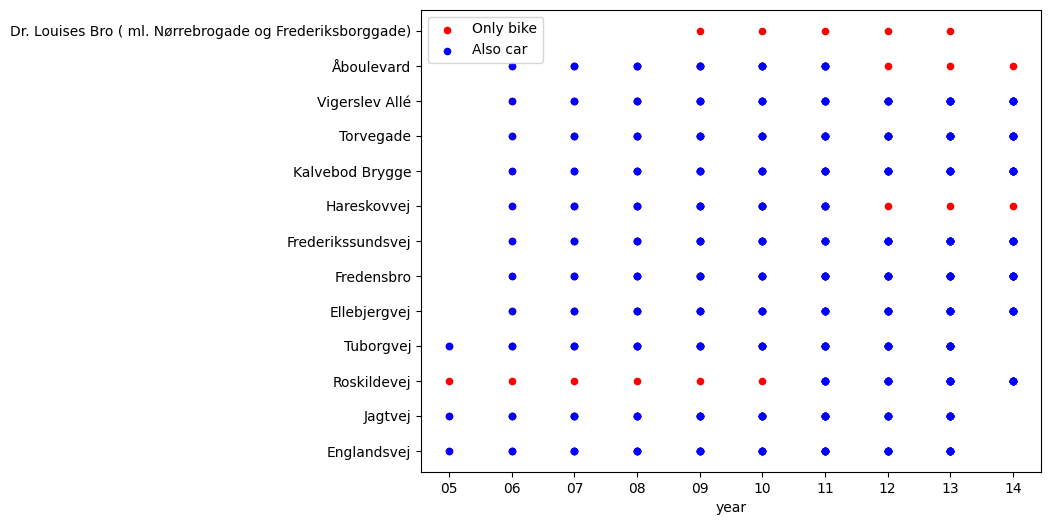

In [ ]:
# However, although they have the same features, there are still some challenges when comparing between years and vehicles. Especially concering the roads which are measured for: 

year_2_roads_bike = {}
year_2_roads_car = {}

data_set_years = ["05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]


for i in data_set_years:

    # Find unique bike road names
    df_bike_i = pd.read_excel('data/cykeltaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")
    unique_bike_roads = list(set(df_bike_i["Vejnavn"]))
    year_2_roads_bike[i] = sorted(unique_bike_roads)

    # Find unique car road names
    df_car_i = pd.read_excel('data/faste-trafiktaellinger-20' + i + '.xlsx',skiprows=10,usecols="A:AD")
    unique_car_roads = list(set(df_car_i["Vejnavn"]))
    year_2_roads_car[i] = sorted(unique_car_roads)


years_bike = []
all_bike_roads = []

years_car = []
fitting_car_roads = []


for year, road_names in year_2_roads_bike.items():
    # Add all pairs of years and road names for the bike data
    years_bike += [year]*len(road_names)
    all_bike_roads += road_names

    # For all bike roads which are also in the car data, include in new lists
    for road_name in all_bike_roads:
        if road_name in year_2_roads_car[year]:
            years_car.append(year)
            fitting_car_roads.append(road_name)

# Disable seaborn plot style for this plot
matplotlib.rc_file_defaults()

plt.figure(figsize=(8,6))

# Plot bike data
plt.scatter(years_bike, all_bike_roads, s=20, color="red", label="Only bike")

# Plot car data on top
plt.scatter(years_car, fitting_car_roads, s=20, color="blue", label="Also car")

plt.legend()
plt.xlabel("year")
plt.show()


# Set style to searborn again
plt.style.use('seaborn-whitegrid')

All the blue points reflect that there is data on both the bicycle and car data for that year. Hence, this tell us that the two data sets allow for many comparisons. For example, it would be intersting to see if the increase in bicyclists across the years was observable in the car data. Alternatively, the car data could also have been used to correct for the increase in the traffic due to increase in the population size of Copenhagen. However, we chose to not focus on including the car data, as we expected there to many underlying factors which were difficult to account for. 

Finally, there are also other data set which might contribute with additional perspectives to the bicycle data analysed in our work. *opendata.dk* provides access to live sensors at different locations around Copenhagen, which measure similar data live. You could sample data over a couple of weeks and compare them with the slightly older data analysed in this work to see any developments. Also, they provide data for different countings on bicycle parkings all around Copenhagen. It would be compelling to examine if these countings implied similar increases in the amounts of bicyclists in Denmark. 

Make sure to visit our web-page telling our story at http://bicyclepatterns.com/

# 7. Contributions

**Notebook sections**:

- 1 Motivation: *Thomas*
- 2 Basic Stats: *Thomas*
- 3 Data Analysis 
    - 3.1: Investigating Temporal Patterns: *Thomas* 
    - 3.2: Impact of Super Bike Lanes: *Thomas*
    - 3.3: Investigating the Impact of the Weather: *Noah*
    - 3.4: Predictive model using weather data: *Noah*
- 4 Genre: *Fotios*
- 5 Visualizations: *Fotios*
- 6 Discussion: *Thomas*


**Web page**: *Fotios*

**Retrievel of weather data**: *Noah*

# 8. References
1. \[CphUTM\]: "Den primære kortprojektion i Danmark" (https://sdfe.dk/media/2917583/001-etrs89-utm.pdf), 2017-04-01, *Geomatics*
1. \[Husnum\]: (https://da.wikipedia.org/wiki/Husnummerering)
1. \[Pop\]: https://www.dst.dk/da/Statistik/emner/befolkning-og-valg/befolkning-og-befolkningsfremskrivning/folketal
1. \[NYCbike\]: (https://www.linkedin.com/pulse/visualizing-nyc-bike-data-interactive-animated-maps-folium-toso/)
1. \[Segel, E., & Heer, J\]. (2010). Narrative visualization: Telling stories with data. IEEE Transactions on Visualization and Computer Graphics, 16(6), 1139–1148. https://doi.org/10.1109/TVCG.2010.179
1. \[Bateman, S.\], Mandryk, R. L., Gutwin, C., Genest, A., McDine, D., & Brooks, C. (2010). Useful junk? The effects of visual embellishment on comprehension and memorability of charts. Conference on Human Factors in Computing Systems - Proceedings, 4, 2573–2582. https://doi.org/10.1145/1753326.1753716
1. \[Har2013\]: https://supercykelstier.dk/farumruten-c95/
1. \[Goal2013\]: https://supercykelstier.dk/ny-cykelsupersti-abner-til-april/
1. \[João2018\]: Pereira, João & Silveira, Margarida. (2018). Unsupervised Anomaly Detection in Energy Time Series Data Using Variational Recurrent Autoencoders with Attention. 1275-1282. 10.1109/ICMLA.2018.00207. 
1. \[loffe and Szegedy, 2015\] loffe and Szegedy, 2015, https://arxiv.org/abs/1502.03167
1. \[Srivastava et. al. 2014\], Srivastava et. al. 2014, https://jmlr.org/papers/v15/srivastava14a.html

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e84bb487-8036-4264-ae5d-1ce02971e193' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>